In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.filters.hp_filter import hpfilter
from scipy.stats import linregress
from statsmodels.tsa.arima.model import ARIMA
from pyts.decomposition import SingularSpectrumAnalysis
from pmdarima.arima import auto_arima
import warnings
import itertools
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import periodogram
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter
import rpy2.robjects as ro
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox
from scipy.stats.mstats import winsorize
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
import pywt
from sklearn.decomposition import PCA
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.utils.extmath import randomized_svd
from PyEMD import EMD
from sklearn.cluster import KMeans
from scipy.stats import skew, kurtosis
from pykalman import KalmanFilter
import torch
import torch.nn as nn
from statsmodels.tsa.stattools import kpss

# Подавляем только FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Сводная таблица методов при работе с временными рядами

Классификация по цели: 🟦 тренд, 🟩 сезонность, 🟨 дисперсия, 🟥 выбросы, 🟪 масштабирование/шум

| №  | Метод                              | Категория | Как работает                     | Для чего используется                   | Когда не стоит использовать                |
| -- | ---------------------------------- | --------- | -------------------------------- | --------------------------------------- | ------------------------------------------ |
| 1  | Дифференцирование                  | 🟦        | `y(t) - y(t-1)`                  | Удаление тренда                         | Стационарный ряд — создаёт шум             |
| 2  | Сезонное дифф.                     | 🟩        | `y(t) - y(t-s)`                  | Удаление сезонности                     | Нет сезонности                             |
| 3  | Логарифмирование                   | 🟨        | `log(y)`                         | Уменьшение дисперсии                    | Нули, отриц. значения                      |
| 4  | Корень (sqrt, pow)                 | 🟨        | `sqrt(y)` или `y^λ`              | Сглаживание                             | Малые значения                             |
| 5  | Box-Cox                            | 🟨        | Оптимизация степени λ            | Стабилизация дисперсии                  | y ≤ 0                                      |
| 6  | Z-преобразование                   | 🟪        | `(x - μ) / σ`                    | Центрирование и шкалирование            | Не делает стационарным                     |
| 7  | STL-декомпозиция                   | 🟦🟩      | Тренд + сезонность + остатки     | Раздельный анализ компонентов           | Сложность, медленно                        |
| 8  | Hodrick–Prescott                   | 🟦        | Сплайн-фильтрация тренда         | Отделение тренда                        | Артефакты                                  |
| 10 | Эксп. сглаживание                  | 🟪        | Убывающее сглаживание            | Локальная гладкость                     | Тренд сохраняется                          |
| 11 | Удаление тренда                    | 🟦        | Вычитание лин. или полин. тренда | Центрирование                           | Нелинейный тренд — плохо                   |
| 12 | Seasonal Adjustment                | 🟩        | Эконометр. методы (X-13 и др.)   | Удаление сложной сезонности             | Очень специфично                           |
| 13 | Cumsum-обратное                    | 🟦        | Обратное накоплению              | Обратное интеграции                     | Не применимо к базовым рядам               |
| 14 | Winsorization                      | 🟥        | Ограничение экстремумов          | Сглаживание выбросов                    | Искажение данных                           |
| 15 | Удаление выбросов                  | 🟥        | Z-оценка, IQR и др.              | Удаление "шумов"                        | Потеря важных событий                      |
| 16 | Мин-Макс масштабирование           | 🟪        | Приведение к \[0,1]              | Для ML-алгоритмов                       | Не помогает со стационарностью             |
| 17 | Fourier-фильтрация                 | 🟩        | Удаление сезонных частот         | Удаление периодики                      | Потеря интерпретации                       |
| 18 | Wavelet-декомпозиция               | 🟪        | Местное разложение сигнала       | Извлечение тренда/шума                  | Сложность                                  |
| 19 | Темпы роста (`pct_change`)         | 🟦        | `(y(t)/y(t-1)) - 1`              | Из уровня в темп                        | Потеря интерпретируемости                  |
| 20 | Прирост (`delta`)                  | 🟦        | `y(t) - y(t-1)`                  | Преобразование тренда                   | Стационарный ряд — ухудшает                |
| 21 | Бинаризация/кластеризация          | 🟪        | Категоризация значений           | Упрощение паттернов                     | Потеря деталей                             |
| 22 | Робастное шкалирование             | 🟪        | `(x - медиана) / IQR`            | Нормализация с устойчивостью к выбросам | Потеря абсолютной шкалы                    |
| 23 | SVD                                | 🟪        | Снижение размерности/фильтрация  | Сглаживание, шумоподавление             | Потеря интерпретируемости компонент        |
| 24 | PCA                                | 🟪        | Извлечение главных компонент     | Удаление шумов, коррел.                 | Требует много данных, не сохраняет порядок |
| 25 | SSA (Singular Spectrum Analysis)   | 🟦🟩      | Декомпозиция слайсами + SVD      | Удаление тренда и сезонности            | Высокая вычисл. сложность                  |
| 26 | Empirical Mode Decomposition (EMD) | 🟪        | Итеративное разложение           | Выделение осцилляций                    | Плохо на шумных данных                     |
| 27 | Rolling stats (mean/std)           | 🟦🟨      | Скользящая средняя и дисперсия   | Выявление/удаление локальных трендов    | Искажает структуру                         |
| 28 | ARIMA differencing                 | 🟦🟩      | Встроенное в ARIMA `d` и `D`     | Автоматическое стационирование          | Непрозрачно, переобучение                  |
| 29 | Kalman filter                      | 🟪        | Оценка скрытых компонент         | Шумоподавление, оценка трендов          | Сложно реализовать                         |
| 30 | Преобразование лог-разностей       | 🟨🟦      | `log(y) - log(y-1)`              | Темпы с устранением масштаба            | Отрицательные значения невозможны          |
| 31 | Holt’s Linear Trend Method         | 🟪        | Двойное сглаживание              | Удаление шумов, коррел.                 | Не учитывает сеозонность                   |
| 32 | Holt-Winters                       | 🟪        | Тройное сглаживание              | Удаление шумов, коррел.                 | Треует данных по сезонности                |


| Категория                 | Цвет       | Методы                                           |
| ------------------------- | ---------- | -------------------------------------------------|
| 🟦 Удаление тренда        | синий      | 1, 7, 8, 11, 13, 19, 20, 25, 27, 28, 30          |
| 🟩 Удаление сезонности    | зелёный    | 2, 7, 12, 17, 25, 28                             |
| 🟨 Стабилизация дисперсии | жёлтый     | 3, 4, 5, 27, 30                                  |
| 🟥 Работа с выбросами     | красный    | 14, 15                                           |
| 🟪 Масштабирование и шум  | фиолетовый | 6,10, 16, 18, 21, 22, 23, 24, 26, 27, 29, 31, 32 |


# Как проверить на стационарность (инстументы для работы с временныим рядами)

## 1. Автокорреляционная функция (ACF)
Что это?
- ACF — это функция, которая измеряет корреляцию временного ряда с самим собой, но с разными задержками (лагами). То есть, насколько текущее значение связано с прошлым значением, отсталым на k шагов.
Формула для лаг k:


Что показывает?
— Если значения с лагом k сильно коррелируют, значит ряд имеет зависимость на таком отдалении.
— Помогает выявить сезонность и структуру автозависимостей.

График ACF:
- На графике обычно изображают корреляцию по лагам с доверительными интервалами (например, ±2/√N). Если значение за пределами интервала — статистически значимая автокорреляция.


## 2. Частичная автокорреляционная функция (PACF)
Что это?
- PACF измеряет прямую автокорреляцию на лаг k, исключая влияние промежуточных лагов (1..k-1).

Почему важно?
- Иногда автокорреляция на лаг k возникает просто потому, что лаги 1, 2, ..., k-1 тоже коррелированы. PACF учитывает только «чистую» связь.

Пример:
- PACF для лага 1 — это просто корреляция с предыдущим значением.
- PACF для лага 2 — корреляция с задержкой 2 после удаления влияния лага 1.

График PACF:
- Аналогично ACF, строится по лагам с доверительными интервалами.

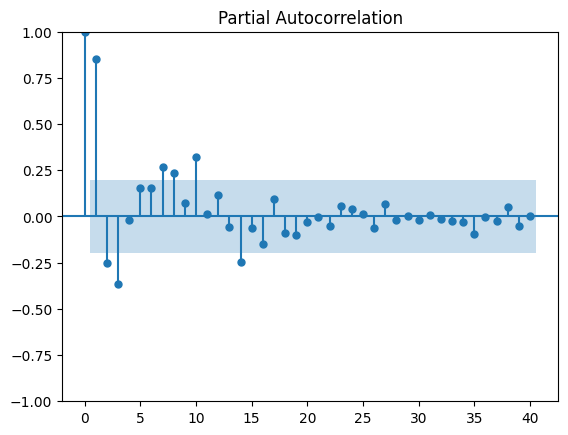

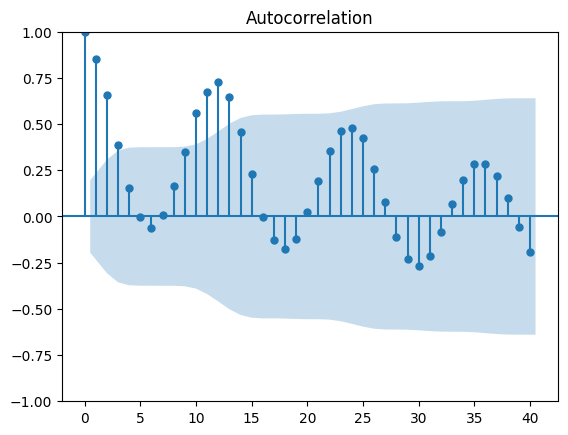

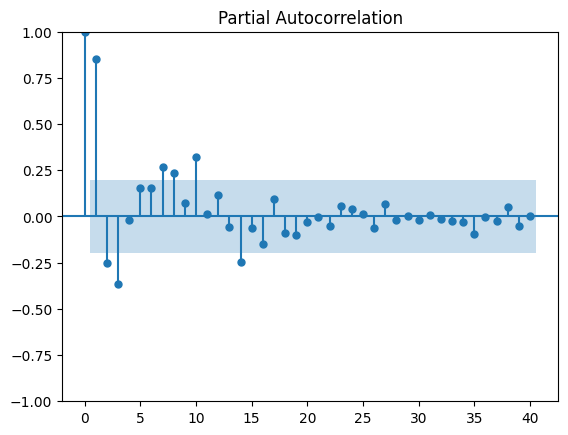

In [121]:
# Построение графиков ACF и PACF
plot_acf(series, lags=40)
plot_pacf(series, lags=40)

Для чего нужны ACF и PACF вместе?
Они помогают выбирать порядок моделей ARIMA:
— ACF показывает, сколько лагов MA-компоненты нужно (скользящее среднее)
— PACF — сколько лагов AR-компоненты (авторегрессия)



## 3.KPSS-тест (Kwiatkowski-Phillips-Schmidt-Shin)
Что проверяет?
- В отличие от ADF, где нулевая гипотеза — нестационарность, у KPSS наоборот — нулевая гипотеза — стационарность.

Почему полезен?
- Позволяет дополнительной проверкой подтвердить или опровергнуть выводы ADF.

Идея:
- Тест проверяет, есть ли в ряде тренд, который нельзя убрать простым преобразованием.

Выводы:
- Если p-value < 0.05 — отвергаем стационарность (ряд нестационарен)
- Если p-value > 0.05 — нет оснований отвергать, ряд можно считать стационарным



In [119]:
stat, p_value, lags, crit = kpss(series, regression='c')
print(f'KPSS Statistic: {stat}, p-value: {p_value}')

KPSS Statistic: 1.190187082648837, p-value: 0.01


## 4. ADF-тест Augmented Dickey-Fulle
from statsmodels.tsa.stattools import adfuller 

Индекс	Значение в result	Что это
0	test_statistic	Статистика теста (ADF-статистика)
1	p-value	p-значение теста
2	usedlag	Количество лагов, использованных в тесте
3	nobs	Число наблюдений (размер выборки)
4	critical_values	Критические значения для разных уровней значимости (1%, 5%, 10%)
5	icbest	Значение информационного критерия (AIC или BIC) для лучшей модели

Если p-value > 0.05 → ряд нестационарный

In [122]:
result = adfuller(series)
print(f'p-value: {result[1]}')

p-value: 0.9988819908452856


#  Приведение временного ряда к стационарности 

🔍 Шаг 0. Первичный анализ
- Строим график ряда: plt.plot(series)
- Смотрим на сезонность/тренд — видна ли она на глаз?
- Делаем ADF-тест (Augmented Dickey-Fuller):

🛠 Шаг 0.5 Предообработка ряда
- Чистим ряд от высокочастоного шума EMD (Empirical Mode Decomposition)

🛠 Шаг 1. Удаление тренда
✅ Если виден тренд:

- Вычесть линейный тренд: scipy.stats.linregress, series - trend
- Если тренд сложнее - использовать один из методов по выделению тренда (например сглаживание, локальную регрессию (LOESS), или STL-декомпозицию)

🔁 Шаг 2. Удаление сезонности
✅ Если есть сезонность (по графику или автокорреляции):
- Сезонное дифференцирование: series.diff(periods=s).dropna()
- Если сезонность сложнее 0 использовать один из методов по выделению сезонности

🌀 Шаг 3. Стабилизация дисперсии
✅ Если дисперсия нестабильна (амплитуда растёт):
- Используем один методов для стабилизации дисперсии

🧹 Шаг 4. Удаление выбросов и шумов
✅ Если наблюдаются  всплески:
- Используем один методов для работы с выбросами/шумами

🧪 Шаг 5. Повторный ADF-тест
После каждого этапа:
Повторный ADF-тест

✅ Цель: p-value < 0.05 → ряд можно считать стационарным

📊 Шаг 6. Визуальная проверка
- Построить график: среднее и дисперсия должны быть постоянны во времени
- Построить скользящее среднее и стандартное отклонение:

series.rolling(window=50).mean().plot(label='mean')
series.rolling(window=50).std().plot(label='std')


# Методики обработки

## Методы борьбы с трендом:

Методы:
- Дифференцирование (разности)
- STL-декомпозиция
- Hodrick–Prescott фильтр
- Удаление линейного тренда
- Обратное к кумулятивной сумме
- Преобразование в темпы роста (pct_change)
- Преобразование в прирост (delta)
- SSA (Singular Spectrum Analysis)
- Скользящая средняя (Rolling stats)
- ARIMA-диссференцирование

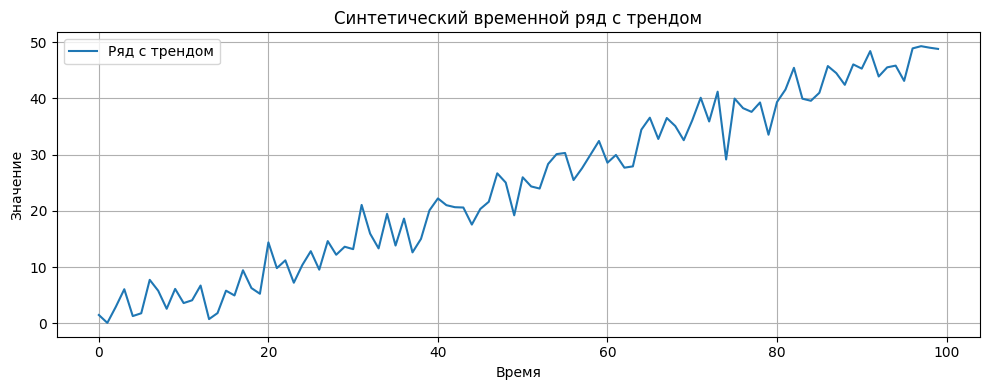

In [19]:
# Генерация синтетического временного ряда с трендом
np.random.seed(42)
t = np.arange(100)
trend = 0.5 * t
noise = np.random.normal(0, 3, size=100)
time_series = pd.Series(trend + noise)

# Построение графика
plt.figure(figsize=(10, 4))
plt.plot(time_series, label="Ряд с трендом")
plt.title("Синтетический временной ряд с трендом")
plt.xlabel("Время")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
result = adfuller(time_series)
print(f'p-value: {result[1]}')

p-value: 0.9621935287067286


**p-value > 0.05 → ряд нестационарный**

### Метод 1: Дифференцирование. Дифференцирование — устраняет тренд, оставляя "скачки", но увеличивает шум.
📌 Метод 1: Дифференцирование (Differencing)
📈 Что делает:
Вычисляет разности между соседними точками:
𝑦𝑡′=𝑦𝑡−𝑦𝑡-1
 
Это убирает линейный тренд, поскольку разность между последовательными точками на прямой — постоянна.

🧠 Зачем:
- Преобразует нестационарный ряд с трендом в стационарный
- Особенно полезно для моделей ARIMA (там d — порядок дифференцирования)

⚠️ Недостатки:
- Увеличивает шум
- Может "передифференцировать" (т.е. убрать полезную информацию)

🔧 В коде:
diff_series = series.diff().dropna()

In [12]:
diff_series = time_series.diff().dropna()
diff_result = adfuller(diff_series)
print(f'p-value: {diff_result[1]}')

p-value: 9.019393985742122e-06


**p-value < 0.05 → ряд стационарный**

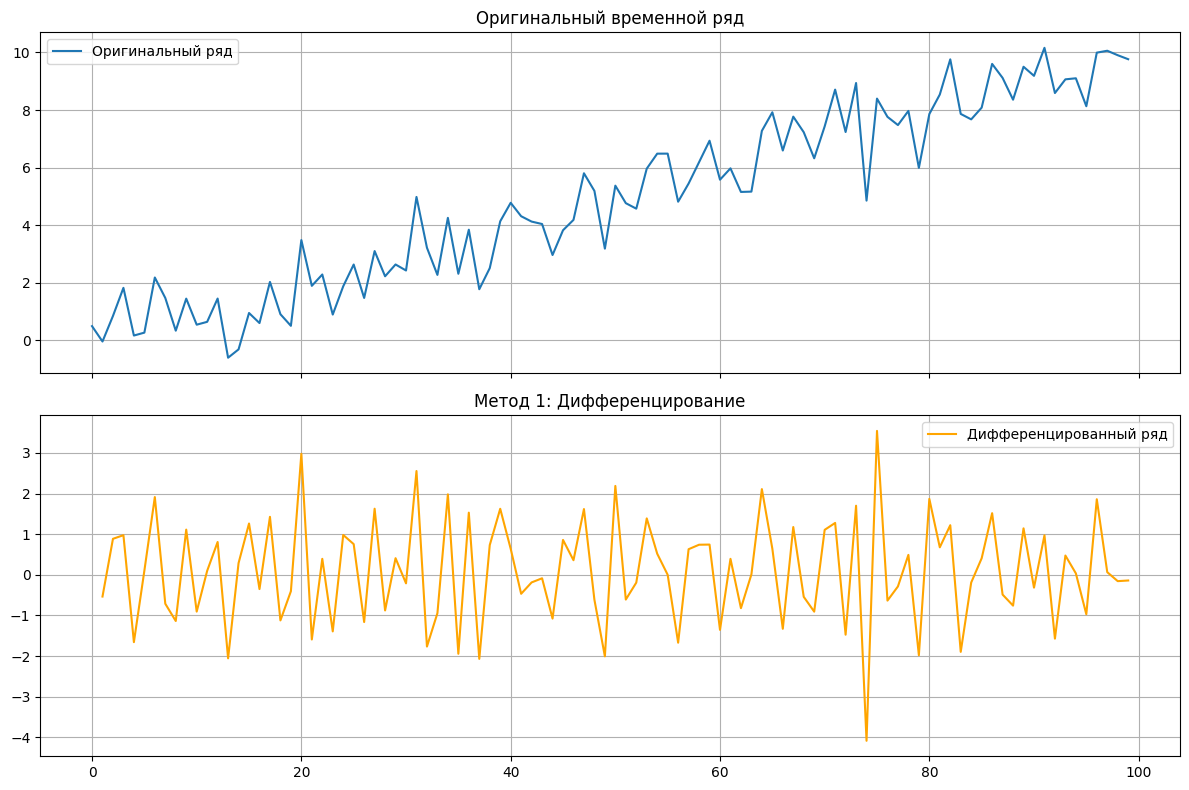

In [19]:
# Визуализация результатов
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axs[0].plot(time_series, label="Оригинальный ряд")
axs[0].set_title("Оригинальный временной ряд")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(diff_series, color='orange', label="Дифференцированный ряд")
axs[1].set_title("Метод 1: Дифференцирование")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

### Метод 2: STL-декомпозиция (с вычитанием тренда)

📌 Метод 2: STL-декомпозиция (Seasonal-Trend decomposition using Loess)
📈 Что делает:
Разлагает временной ряд на 3 компоненты:
𝑦𝑡=𝑇𝑡+𝑆𝑡+𝑅𝑡y 
где:
𝑇𝑡 — тренд (гладкая "основная форма" ряда)
𝑆𝑡 — сезонность (циклические повторения)
𝑅𝑡 — остатки (шум, аномалии, нерегулярность)

Использует LOESS (локальную регрессию) для плавного сглаживания

🧠 Зачем:
- Позволяет аккуратно вычесть тренд, не увеличивая шум
- Особенно полезен, если тренд нелинейный или сезонность переменная

⚠️ Недостатки:
- Не идеально работает на коротких рядах
- Требует настройки параметров (period, seasonal, trend)

🔧 В коде:

from statsmodels.tsa.seasonal import STL
stl = STL(series, period=13)
res = stl.fit()
trend_removed = series - res.trend

⚙️ Как работает STL-декомпозиция внутри?
- STL использует итеративную схему.
1. Начальная оценка тренда и сезонности
Предположим, что 
𝑇=0 и получим сезонность, усреднив по периодам.

2. Цикл: уточнение компонент
(а) Удаление тренда:
𝐷𝑡=𝑦𝑡−𝑇𝑡
Оценивается сезонная компонента из этого "детрендированного" ряда 
D — берутся сглаженные медианы по соответствующим фазам периода.
(б) Удаление сезонности:
𝑦𝑡−𝑆𝑡⇒𝑇𝑡
То есть из ряда убирают текущую сезонность, и на этом строят LOESS-регрессию, чтобы сгладить тренд (находится плавная кривая).
(в) Остатки:
𝑅𝑡=𝑦𝑡−𝑇𝑡−𝑆𝑡
После этого оценивается уровень шума.

3. Повторение цикла
Эти шаги повторяются несколько раз (обычно 10–20 итераций), пока компоненты не стабилизируются.

🧠 Что такое LOESS (LOWESS)?
Это локальная регрессия, которая:
- Строит малые регрессионные модели для подмножеств точек
- Весит точки по близости ко времени 𝑡
- Позволяет ловить нелинейные тренды



In [20]:
stl = STL(time_series, period=13)  # Период — произвольный, для тренда он не критичен
res = stl.fit()
stl_detrended = time_series - res.trend

stl_result = adfuller(stl_detrended)
print(f'p-value: {stl_result[1]}')

# Извлекаем компоненты
trend = res.trend
seasonal = res.seasonal
resid = res.resid

p-value: 1.551535515823251e-06


**p-value < 0.05 → ряд стационарный**

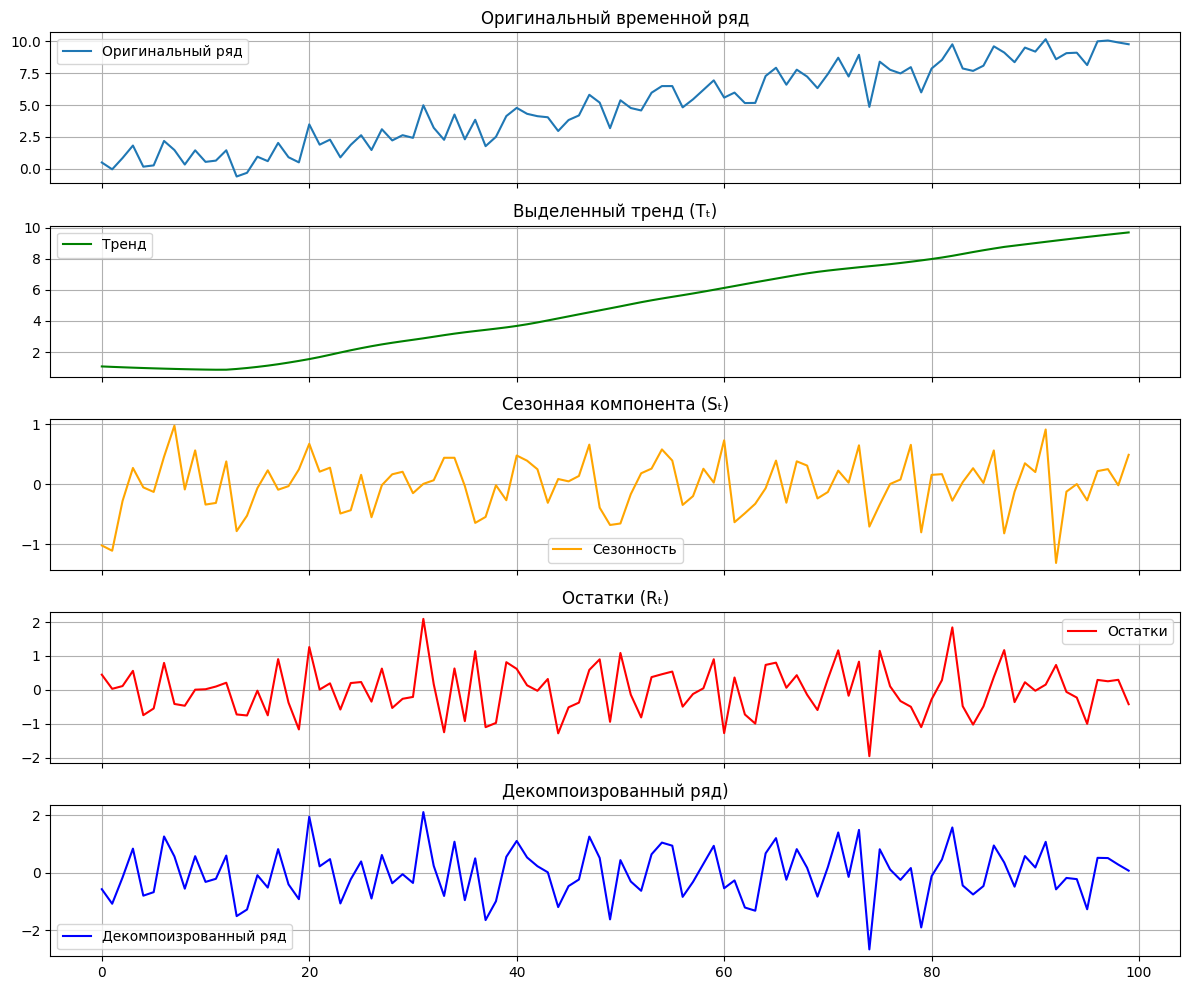

In [22]:
# Визуализация компонент
fig, axs = plt.subplots(5, 1, figsize=(12, 10), sharex=True)

axs[0].plot(time_series, label="Оригинальный ряд")
axs[0].set_title("Оригинальный временной ряд")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(trend, color="green", label="Тренд")
axs[1].set_title("Выделенный тренд (Tₜ)")
axs[1].legend()
axs[1].grid(True)

axs[2].plot(seasonal, color="orange", label="Сезонность")
axs[2].set_title("Сезонная компонента (Sₜ)")
axs[2].legend()
axs[2].grid(True)

axs[3].plot(resid, color="red", label="Остатки")
axs[3].set_title("Остатки (Rₜ)")
axs[3].legend()
axs[3].grid(True)

axs[4].plot(stl_detrended, color="blue", label="Декомпоизрованный ряд")
axs[4].set_title("Декомпоизрованный ряд)")
axs[4].legend()
axs[4].grid(True)

plt.tight_layout()
plt.show()

### Метод 3: Hodrick–Prescott фильтр

Математическая цель:
Разделить ряд 𝑦𝑡  на:𝑦𝑡=𝜏𝑡+𝑐𝑡
𝜏𝑡 — гладкий тренд
𝑐𝑡 — циклическая (детрендированная) часть
Оптимизируем функционал:

min𝜏∑𝑡=1𝑇(𝑦𝑡−𝜏𝑡)2+𝜆∑𝑡=2𝑇−1((𝜏𝑡+1−𝜏𝑡)−(𝜏𝑡−𝜏𝑡−1))2 
Первая часть: как хорошо 𝜏 аппроксимирует 𝑦
Вторая часть: насколько гладкий тренд (разность разностей = вторая производная)
λ управляет этим компромиссом:
Высокое λ → сильное сглаживание (долгосрочный тренд)
Малое λ → тренд близок к исходным данным

In [24]:
cycle, hp_trend = hpfilter(time_series, lamb=1600)
hp_detrended = time_series - hp_trend

hp_result = adfuller(hp_detrended)
print(f'p-value: {hp_result[1]}')

p-value: 5.437897905852547e-06


**p-value < 0.05 → ряд стационарный**

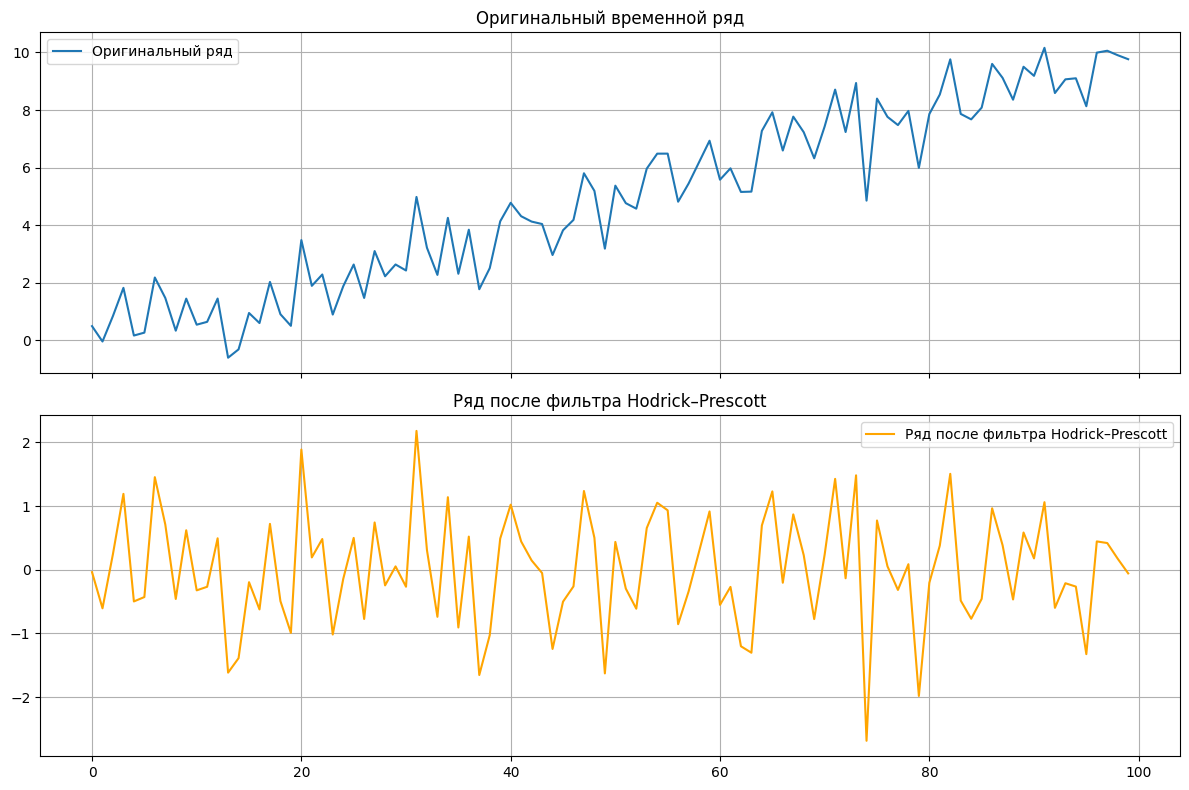

In [25]:
# Визуализация результатов
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axs[0].plot(time_series, label="Оригинальный ряд")
axs[0].set_title("Оригинальный временной ряд")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(hp_detrended, color='orange', label="Ряд после фильтра Hodrick–Prescott")
axs[1].set_title("Ряд после фильтра Hodrick–Prescott")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

### Метод 4: Удаление линейного тренда через регрессию
Используется обычная линейная регрессия:

𝑦𝑡=𝛽0+𝛽1⋅𝑡+𝜀𝑡
𝛽1— наклон (тренд)
𝛽0— смещение

Вычитание 𝛽0+𝛽1𝑡 из 𝑦𝑡  даёт детрендированный ряд
Эффективно, если тренд действительно линейный

In [29]:
slope, intercept, *_ = linregress(t, time_series)
linear_trend = slope * t + intercept
lin_detrended = time_series - linear_trend

hp_result = adfuller(lin_detrended)
print(f'p-value: {hp_result[1]}')

p-value: 9.718988875411622e-18


**p-value < 0.05 → ряд стационарный**

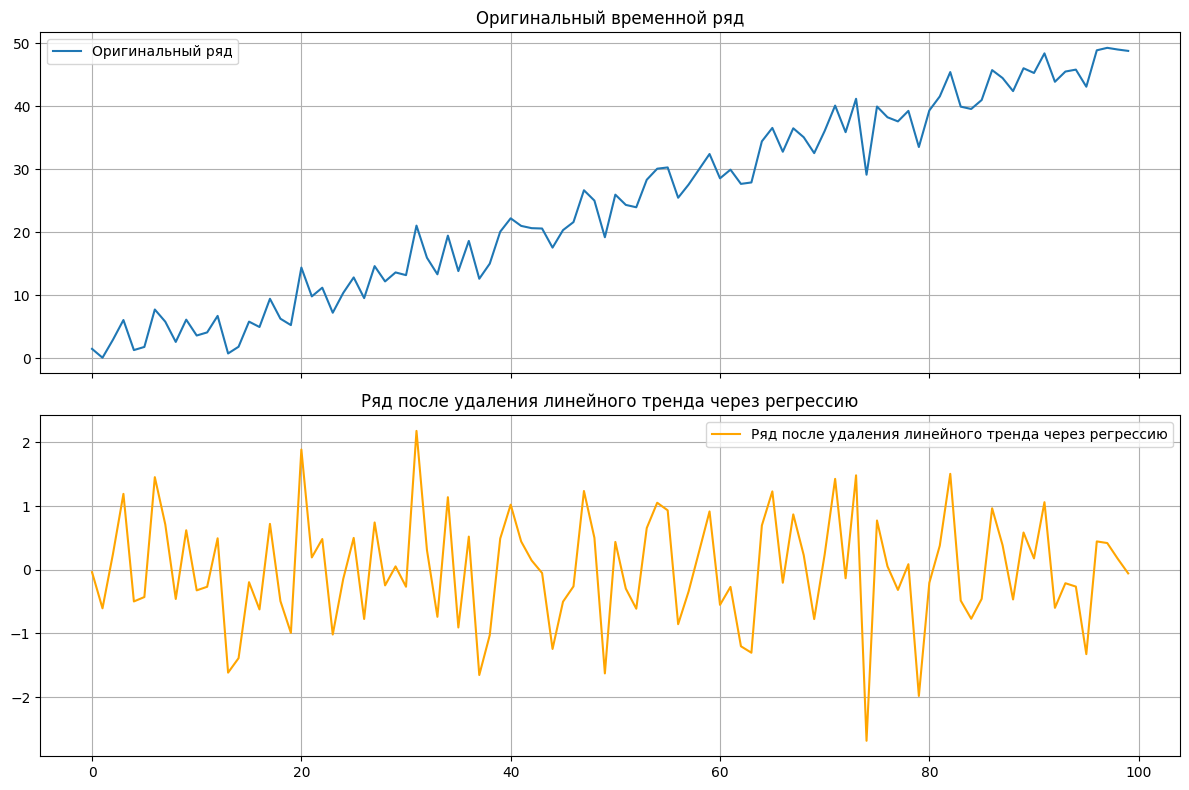

In [30]:
# Визуализация результатов
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axs[0].plot(time_series, label="Оригинальный ряд")
axs[0].set_title("Оригинальный временной ряд")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(hp_detrended, color='orange', label="Ряд после удаления линейного тренда через регрессию")
axs[1].set_title("Ряд после удаления линейного тренда через регрессию")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

### Метод 5: Обратное к cumsum (по сути - восстановление из кумулятивных сумм) (Данные с нарастающим итогом)
Идея: если данные были накоплены, "распаковать" их обратно
Т.к. наш ряд не является накопленным, для демонстрации "сожмём" его в cumsum, а затем обратно

Обычно применяется в прямом виде:

Δ𝑦𝑡=𝑦𝑡−(𝑦𝑡−1)
 
Это первый порядок разностей. Его цель:
Преобразовать трендовый ряд в стационарный (если тренд — аддитивный)
Удалить линейный тренд, не заботясь о форме

In [31]:
cumsum_series = time_series.cumsum()
inverse_cumsum = cumsum_series.diff().dropna()

invcs_result = adfuller(inverse_cumsum)
print(f'p-value: {invcs_result[1]}')

p-value: 0.9708278025638837


**p-value > 0.05 → ряд нестационарный** (что ожидаемо т.к наш ряд не кумулятивная сумма)

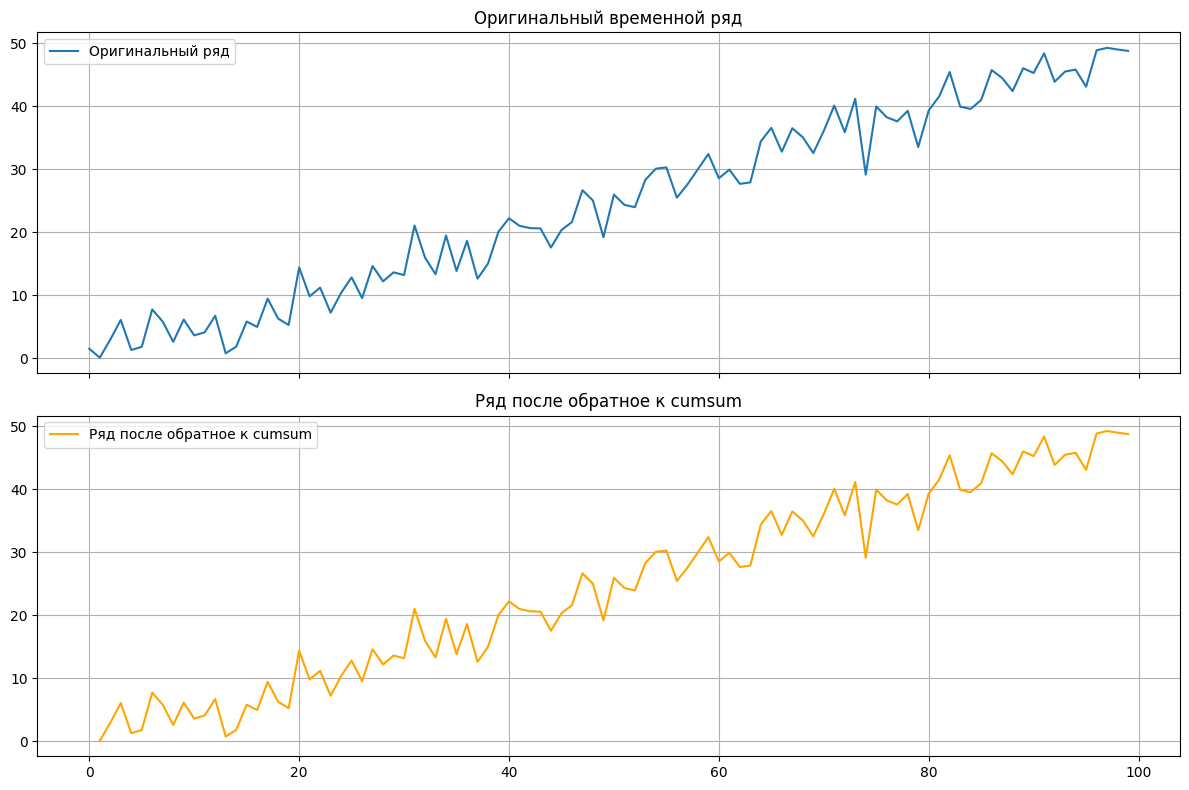

In [33]:
# Визуализация результатов
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axs[0].plot(time_series, label="Оригинальный ряд")
axs[0].set_title("Оригинальный временной ряд")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(inverse_cumsum, color='orange', label="Ряд после обратное к cumsum")
axs[1].set_title("Ряд после обратное к cumsum")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
в: Сглаживание скользящим средним, LOWESS, Hodrick–Prescott, которые могут быть объединены под "скользящие и адаптивные фильтры"?

### Метод 6: Преобразование в темпы роста (pct_change)

Что делает:
Вычисляет относительное изменение от предыдущего значения:
𝑟𝑡=(𝑦𝑡−𝑦𝑡−1)/𝑦𝑡−1  = 𝑦𝑡/𝑦𝑡-1  -  1

Используется:
В экономике и финансах — анализ доходностей, прироста спроса и т.п.

Плюсы:
- Удаляет линейный/экспоненциальный тренд
- Делает ряд "более стационарным" по масштабу

Минусы:
- Нестабильно при 𝑦𝑡−1≈0
- Потеря масштаба (работаешь уже не с уровнем, а с ростом)

In [35]:
pct_growth = time_series.pct_change().dropna()

pct_growth_result = adfuller(pct_growth)
print(f'p-value: {pct_growth_result[1]}')

p-value: 0.0003352051060890558


**p-value < 0.05 → ряд стационарный**

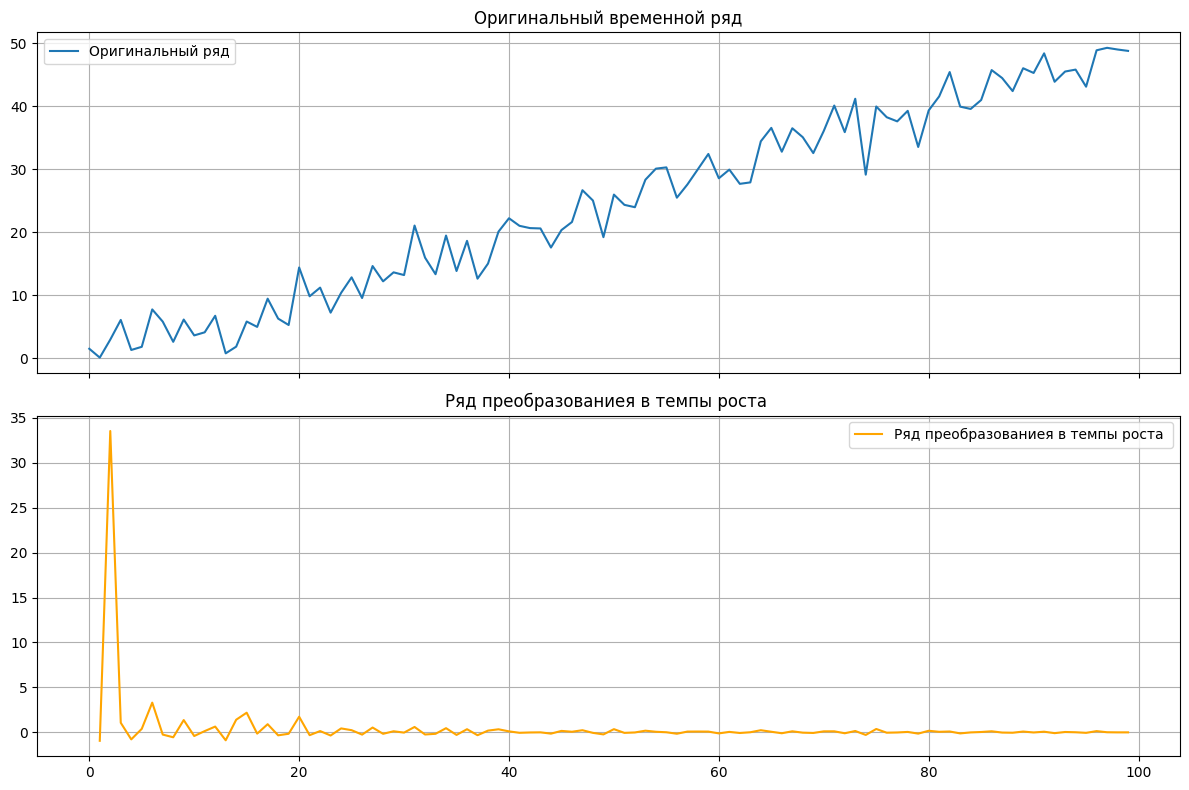

In [37]:
# Визуализация результатов
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axs[0].plot(time_series, label="Оригинальный ряд")
axs[0].set_title("Оригинальный временной ряд")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(pct_growth, color='orange', label="Ряд преобразованиея в темпы роста ")
axs[1].set_title("Ряд преобразованиея в темпы роста ")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

### Метод 7: Преобразование в прирост (delta)

In [38]:
delta = time_series.diff().dropna()

delta_result = adfuller(delta)
print(f'p-value: {pct_growth_result[1]}')

p-value: 0.0003352051060890558


**p-value < 0.05 → ряд стационарный**

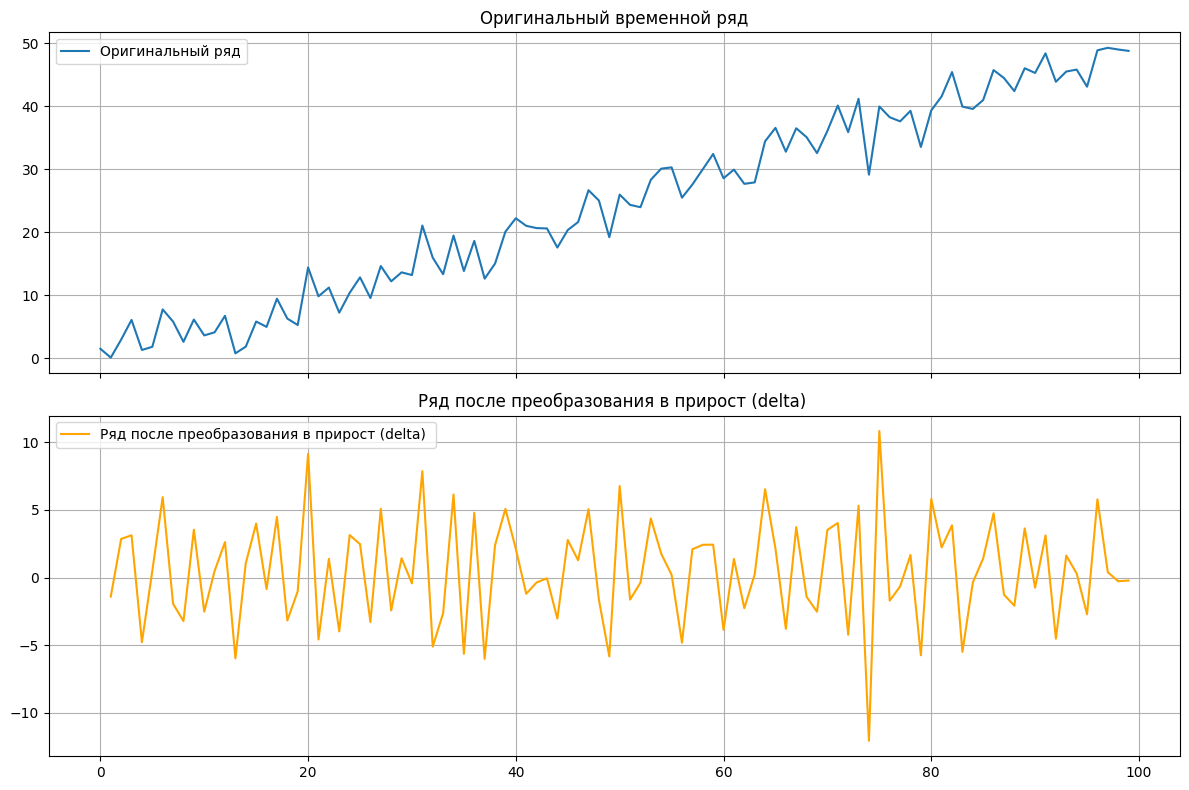

In [39]:
# Визуализация результатов
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axs[0].plot(time_series, label="Оригинальный ряд")
axs[0].set_title("Оригинальный временной ряд")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(delta, color='orange', label="Ряд после преобразования в прирост (delta) ")
axs[1].set_title("Ряд после преобразования в прирост (delta) ")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

### Метод 8: SSA (Singular Spectrum Analysis)
Что делает:
Раскладывает временной ряд на сумму компонент (тренд, сезонность, шум)
при помощи SVD (сингулярного разложения) скользящего окна.

Этапы:
- Построение матрицы траекторий с помощью окон (lags)
- SVD-разложение
- Группировка компонент (например, 1-я компонента — тренд)
- Обратное преобразование (reconstruction)

Плюсы:
- Мощный, не требует жёсткой параметризации
- Умеет работать с нелинейными трендами

Минусы:
- Требует выбора окна, немного «чёрный ящик»
- Вычислительно затратен

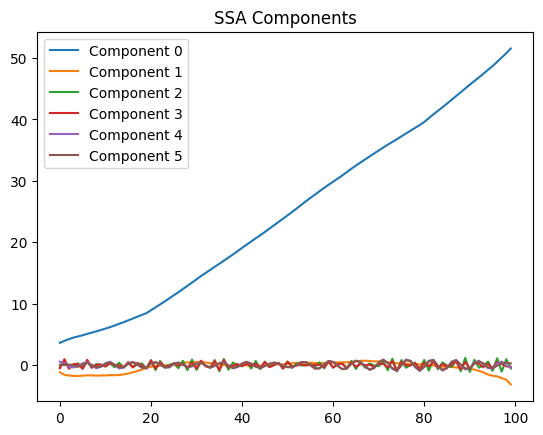

In [20]:
# SSA из pyts
ssa = SingularSpectrumAnalysis(window_size=20)
components = ssa.fit_transform(time_series.values.reshape(1, -1))

for i in range(6):
    plt.plot(components[0, i], label=f'Component {i}')
plt.legend()
plt.title('SSA Components')
plt.show()



In [21]:
# Восстановим тренд (визуапльно он компонента 1)
trend_component = components[0, 0]
detrended = time_series - trend_component

# ADF-тест
adf_result = adfuller(detrended)
print(f"ADF p-value (pyts SSA detrended): {adf_result[1]:.5f}")


ADF p-value (pyts SSA detrended): 0.00000


**p-value < 0.05 → ряд стационарный** 

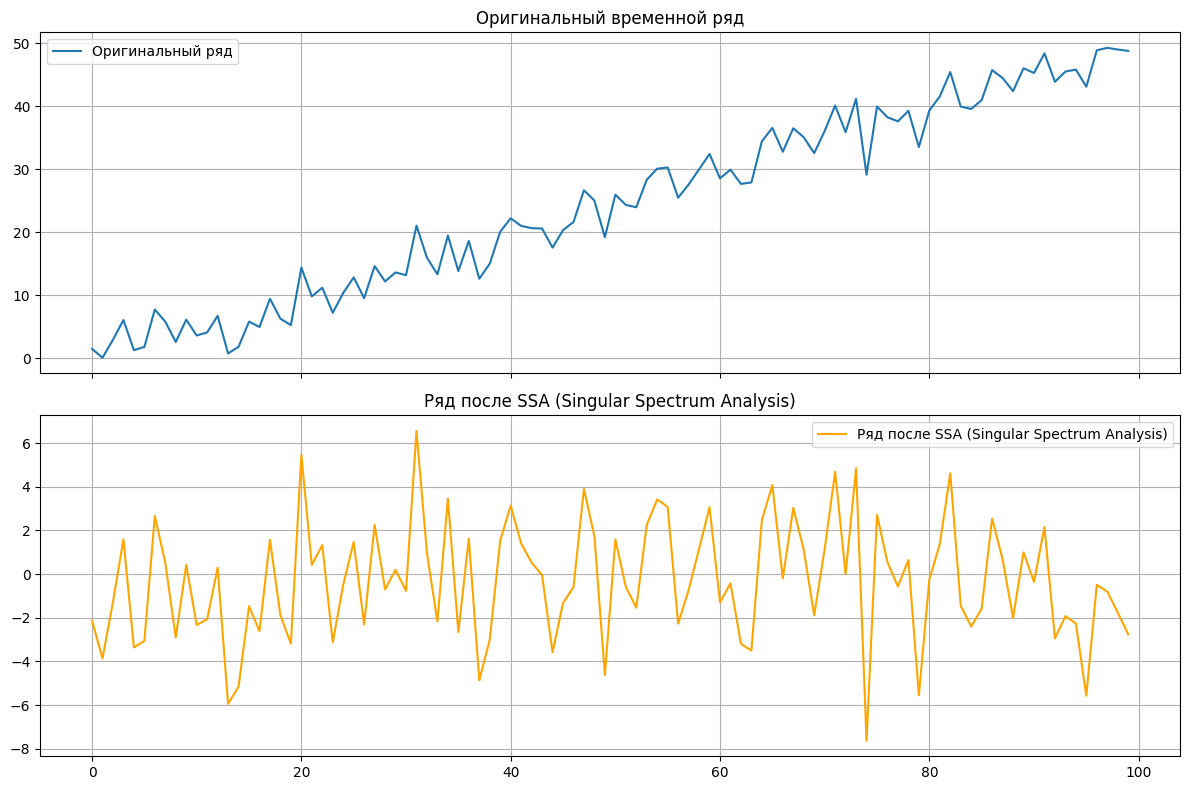

In [22]:
# Визуализация результатов
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axs[0].plot(time_series, label="Оригинальный ряд")
axs[0].set_title("Оригинальный временной ряд")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(detrended, color='orange', label="Ряд после SSA (Singular Spectrum Analysis)")
axs[1].set_title("Ряд после SSA (Singular Spectrum Analysis)")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

### Метод 9. Скользящая средняя (Rolling stats)
Если в данных есть медленно меняющийся тренд, можно сгладить его скользящим окном (rolling mean) и вычесть этот сглаженный тренд.

ADF p-value (rolling mean): 0.00000


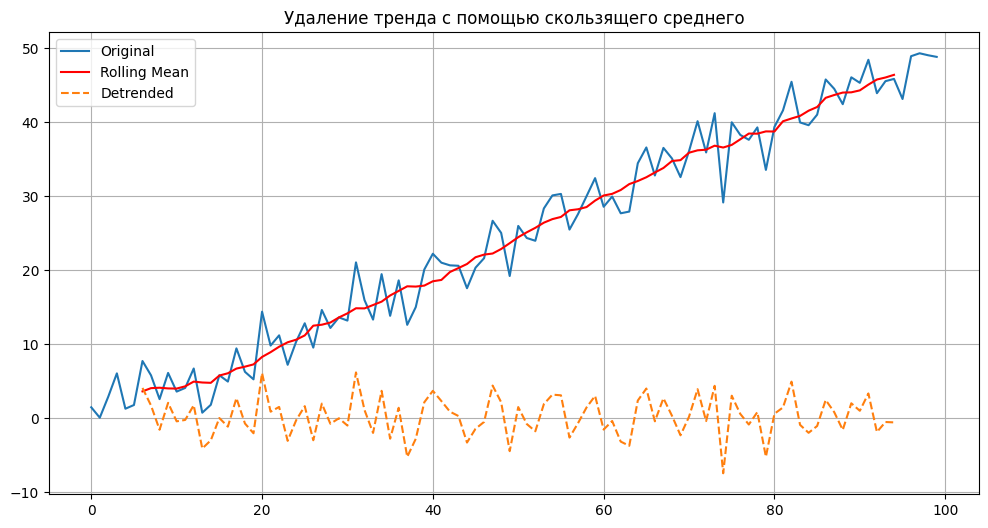

In [35]:
window_size = 12  # подбирается в зависимости от масштаба тренда
rolling_mean = time_series.rolling(window=window_size, center=True).mean()

# Вычитаем скользящее среднее → устраняем тренд
detrended_rolling = time_series - rolling_mean
detrended_rolling = detrended_rolling.dropna()

adf_result_roll = adfuller(detrended_rolling)
print(f"ADF p-value (rolling mean): {adf_result_roll[1]:.5f}")

# Визуализация

plt.figure(figsize=(12, 6))
plt.plot(time_series, label="Original")
plt.plot(rolling_mean, label="Скользящее сренее", color="red")
plt.plot(detrended_rolling, label="После скользяего среднего", linestyle="--")
plt.legend()
plt.title("Удаление тренда с помощью скользящего среднего")
plt.grid(True)
plt.show()

**p-value < 0.05 → ряд стационарный**

In [37]:
for w in [6, 12, 18, 24]:
    rolling_mean = time_series.rolling(window=w, center=True).mean()
    detrended = time_series - rolling_mean
    detrended = detrended.dropna()
    pvalue = adfuller(detrended)[1]
    print(f"Window={w}: ADF p-value = {pvalue:.4f}")


Window=6: ADF p-value = 0.0000
Window=12: ADF p-value = 0.0000
Window=18: ADF p-value = 0.0000
Window=24: ADF p-value = 0.0000


Window=6: ADF p-value = 0.0000
Window=12: ADF p-value = 0.0000
Window=18: ADF p-value = 0.0000
Window=24: ADF p-value = 0.0000


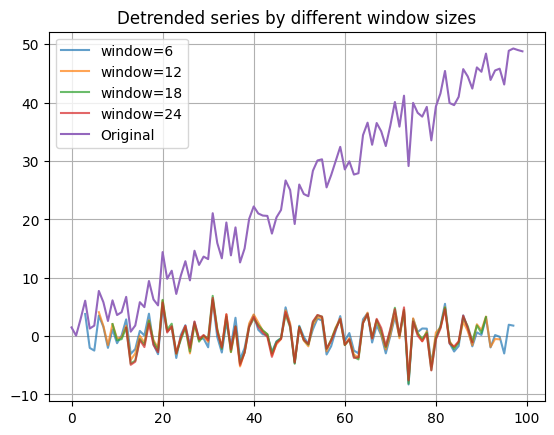

In [42]:
for w in [6, 12, 18, 24]:
    rolling_mean = time_series.rolling(window=w, center=True).mean()
    detrended = time_series - rolling_mean
    detrended = detrended.dropna()
    pvalue = adfuller(detrended)[1]
    print(f"Window={w}: ADF p-value = {pvalue:.4f}")
    plt.plot(detrended, label=f'window={w}', alpha=0.7)
    
plt.plot(time_series, label="Original")
plt.title("Detrended series by different window sizes")
plt.legend()
plt.grid(True)
plt.show()

### Метод 10: ARIMA-дисференцирование

1. Что делает:
В модели ARIMA компонент I(d) отвечает за стационарность:
применяется d-разностей:

𝑦𝑡(1)=𝑦𝑡−𝑦𝑡−1 ⇒ 𝑦𝑡(2)=𝑦𝑡(1)−𝑦𝑡−1(1)

Используется:
В классическом моделировании временных рядов — если ADF-тест показывает нестационарность

Плюсы:
- Теоретически обоснован
- Снимает тренды вплоть до полиномиальных
- 
Минусы:
- Можно переусердствовать (переразностить)
- Не всегда удобно интерпретировать результат

In [10]:
arima_model = ARIMA(time_series, order=(0, 1, 0)).fit()

# Получим явно разности
arima_diff = pd.Series(arima_model.model.endog.ravel()).diff().dropna()


arima_diff_result = adfuller(arima_diff)
print(f'p-value: {arima_diff_result[1]}')

p-value: 9.019393985742474e-06


**p-value < 0.05 → ряд стационарный** 

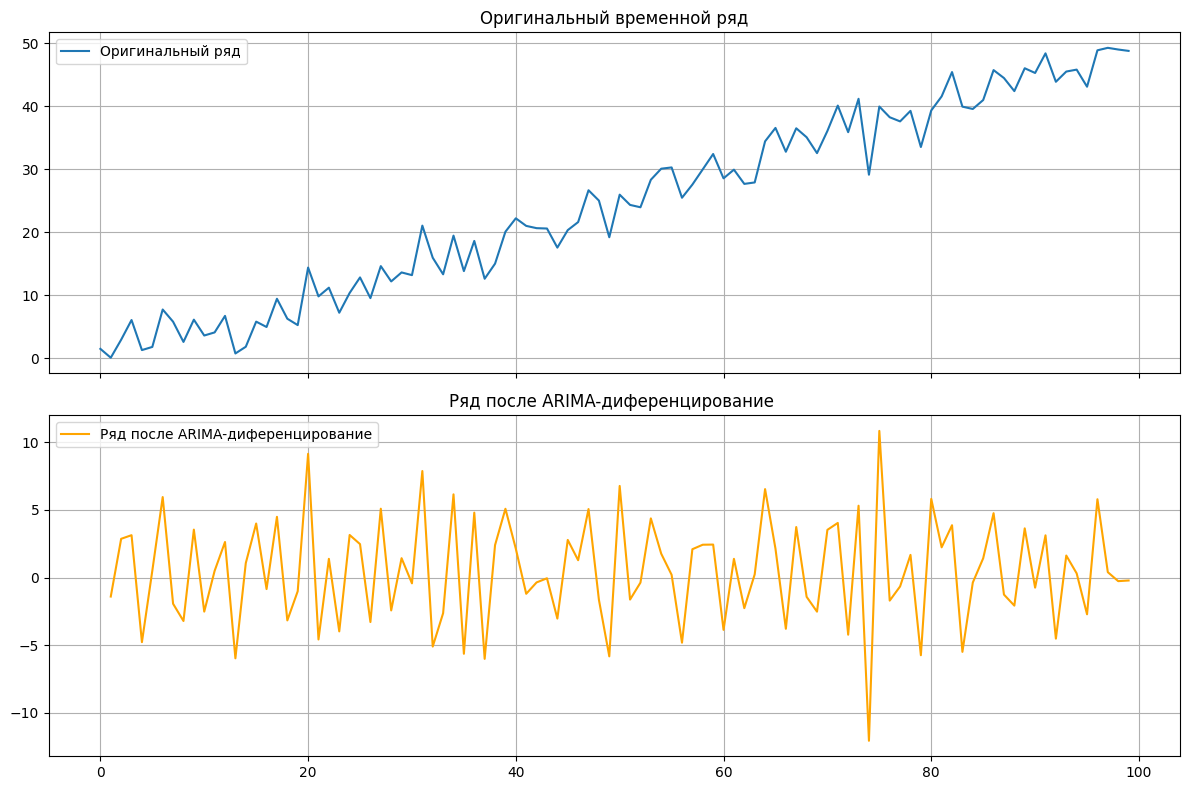

In [11]:
# Визуализация результатов
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axs[0].plot(time_series, label="Оригинальный ряд")
axs[0].set_title("Оригинальный временной ряд")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(arima_diff, color='orange', label="Ряд после ARIMA-диференцирование")
axs[1].set_title("Ряд после ARIMA-диференцирование ")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

### Метод 11: Логарифмические разности (log-differencing)
Если тренд мультипликативный (экспоненциальный рост/падение), можно взять логарифм, а затем дифференцировать — это превращает мультипликативный тренд в аддитивный и устраняет его.
Метод не работает если нет мультипликативного тренда
Этот метод «заточен» под взаимопропорциональные изменения (когда каждое новое значение = предыдущее × кое-что).
Например: продажи растут на 10% каждый месяц → логарифм переводит в линейный рост.

Малые колебания или нулевая дисперсия после лог-диффа:
ADF не любит «слишком гладкие» ряды — p-value может быть высоким, даже если визуально ряд «ровный».

| Признак ряда                                    | Стоит применять log-diff?               |
| ----------------------------------------------- | --------------------------------------- |
| Экспоненциальный рост (или спад)                | ✅ Да                                    |
| Финансовые данные (ценовые индексы, доходности) | ✅ Да                                    |
| Малые значения, близкие к нулю                  | ❌ Нет — лог даст -inf                   |
| Отрицательные значения                          | ❌ Нет                                   |
| Линейный тренд                                  | ⚠️ Лучше обычная разность или `rolling` |


ADF p-value (log differencing): 0.16918


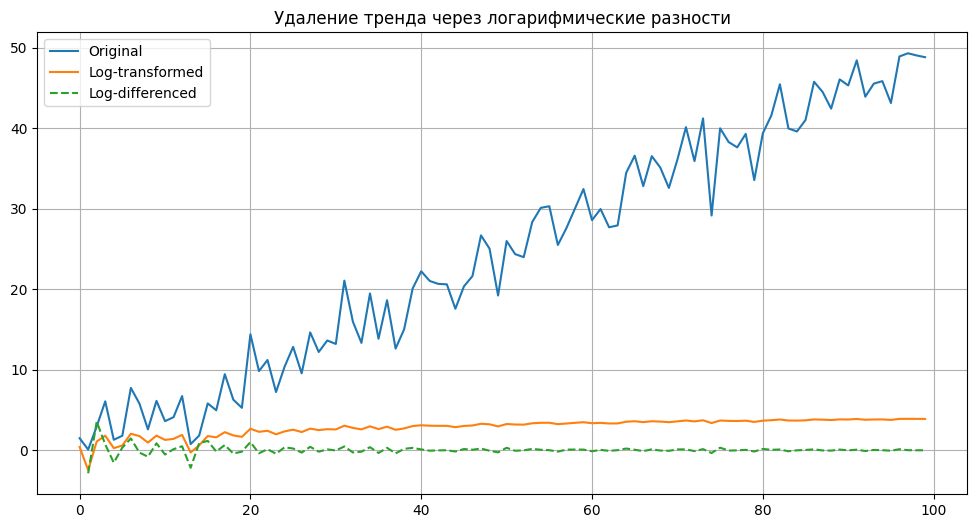

In [36]:
# Логарифм (важно: данные должны быть > 0)
log_ts = np.log(time_series[time_series > 0])

# Дифференцирование логарифма
log_diff = log_ts.diff().dropna()

# ADF-тест
adf_result = adfuller(log_diff)
print(f"ADF p-value (log differencing): {adf_result[1]:.5f}")

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(time_series, label="Original")
plt.plot(log_ts, label="Log-transformed")
plt.plot(log_diff, label="Log-differenced", linestyle="--")
plt.legend()
plt.title("Удаление тренда через логарифмические разности")
plt.grid(True)
plt.show()

**p-value > 0.05 → ряд нестационарный** 

## Методы борьбы с сезонностью

Методы:

- STL-декомпозиция
- Сезонное дифференцирование (seasonal differencing)
- Seasonal Adjustment(эконометрические методы)
- Fourier-фильтрация
- SSA (Singular Spectrum Analysis)
- ARIMA-диссференцирование

### Функции позволяющие вычислить сезонность

✅ 1. Автокорреляционная функция (ACF)
Самый популярный способ.

- Построить ACF-график (from statsmodels.graphics.tsaplots import plot_acf)
- Посмотреть, через какой лаг идут первые значимые пики (не убывающие к 0)
- → этот лаг и есть предполагаемый сезонный период.

- from statsmodels.graphics.tsaplots import plot_acf
- plot_acf(seasonal_series, lags=40)
- plt.show()

✅ 2. Fourier-анализ / спектральная плотность
- Можно разложить ряд по частотам и найти доминирующие.
  
- from scipy.signal import periodogram
- freqs, psd = periodogram(seasonal_series)
- dominant_freq = freqs[np.argmax(psd[1:]) + 1]  # пропускаем freq=0
- seasonal_period = int(round(1 / dominant_freq))
- print("Предполагаемый сезонный период:", seasonal_period)

✅ 3. Seasonal-Trend Decomposition Using LOESS (STL) с перебором
- Если всё сложно — несколько вариантов period (например, 6, 12, 24) и смотреть, где лучше визуально выделяется сезонность или меньше остатки (residuals).

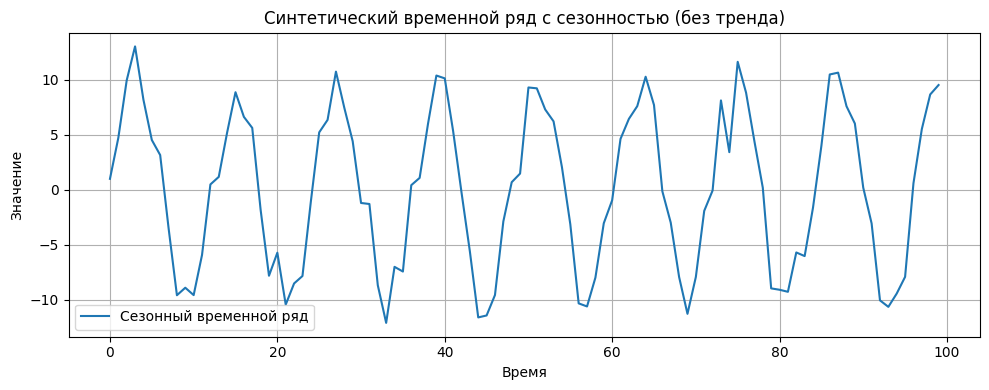

0     0.993428
1     4.723471
2     9.955631
3    13.046060
4     8.191947
dtype: float64

In [2]:
# Генерация синтетического сезонного ряда (без тренда)
np.random.seed(42)
t = np.arange(100)
seasonal_pattern = 10 * np.sin(2 * np.pi * t / 12)  # 12-периодная сезонность
noise = np.random.normal(0, 2, size=100)
seasonal_series = pd.Series(seasonal_pattern + noise)

# Построение графика
plt.figure(figsize=(10, 4))
plt.plot(seasonal_series, label="Сезонный временной ряд")
plt.title("Синтетический временной ряд с сезонностью (без тренда)")
plt.xlabel("Время")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

seasonal_series.head()

#### ACF-график

<Figure size 1000x400 with 0 Axes>

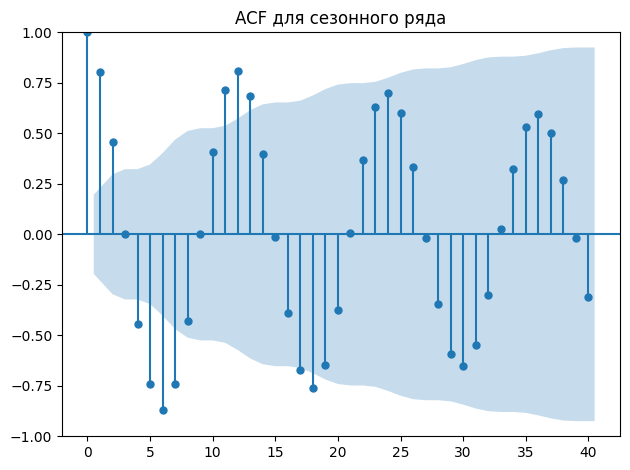

In [18]:
plt.figure(figsize=(10, 4))
plot_acf(seasonal_series, lags=40)
plt.title("ACF для сезонного ряда")
plt.tight_layout()
plt.show()


#### Спектральный анализ

In [19]:
freqs, psd = periodogram(seasonal_series)
dominant_freq_index = np.argmax(psd[1:]) + 1  # пропускаем нулевую частоту
dominant_freq = freqs[dominant_freq_index]
seasonal_period = int(round(1 / dominant_freq))

seasonal_period

12

#### Из обоих методов видим что сезонность равна 12 (что соответвует тому что мы ее такой и задали)

### Метод 1: STL-декомпозиция (с вычитанием сезооности)

In [20]:
stl = STL(seasonal_series, period=12)  # Период —  вычисленный
res = stl.fit()
stl_detrended = seasonal_series - res.seasonal

stl_result = adfuller(stl_detrended)
print(f'p-value: {stl_result[1]}')

p-value: 0.005621232107849189


**p-value < 0.05 → ряд стационарный** 

### Метод 2: Сезонное дифференцирование (seasonal differencing)

In [ ]:
Если сезонность происходит, скажем, каждые 12 шагов, то мы можем вычислить:
diff_seasonal = series[t] - series[t - 12]
Это и есть сезонное дифференцирование, формально:
Yt′ =Yt −Yt−s
s — длина сезона (например, 12 для месячных данных с годовой сезонностью).

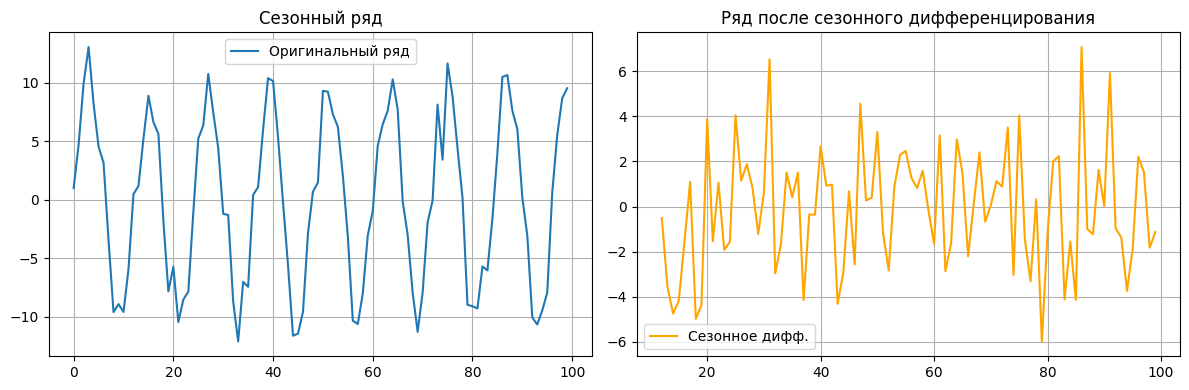

p-value: 0.005621232107849189


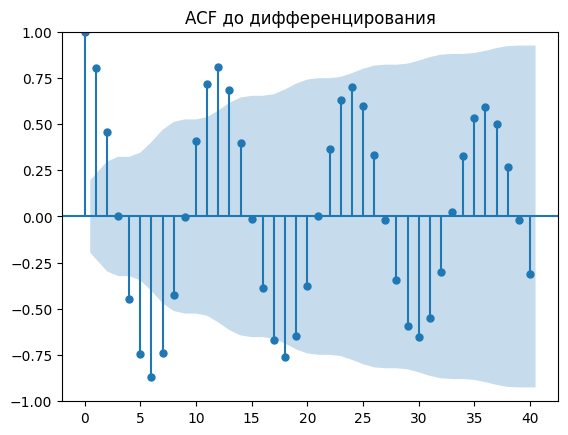

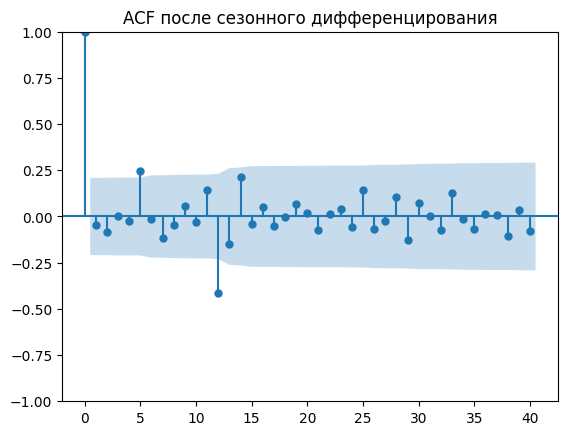

In [25]:
# Сезонное дифференцирование с лагом 12
seasonal_diff = seasonal_series.diff(12)

# Визуализация
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(seasonal_series, label="Оригинальный ряд")
plt.title("Сезонный ряд")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(seasonal_diff, label="Сезонное дифф.", color="orange")
plt.title("Ряд после сезонного дифференцирования")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# ACF до и после
plot_acf(seasonal_series.dropna(), lags=40, title="ACF до дифференцирования")
plot_acf(seasonal_diff.dropna(), lags=40, title="ACF после сезонного дифференцирования")

stl_result = adfuller(stl_detrended)
print(f'p-value: {stl_result[1]}')

**p-value < 0.05 → ряд стационарный** 

### Метод 3. Seasonal Adjustment
Seasonal Adjustment — как эконометрическая группа методов, например:
| Метод                             | Инструмент       | Описание                 |
| --------------------------------- | ---------------- | ------------------------ |
| **X-12-ARIMA**                    | US Census Bureau | Старый стандарт          |
| **X-13ARIMA-SEATS**               | US Census Bureau | Современный мощный метод |
| **TRAMO/SEATS**                   | Bank of Spain    | Популярен в ЕС           |
| **eviews, JDemetra+, R packages** |                  | Официальные реализации   |

X-13 и подобные — жестко структурированы, требуют форматированного ввода и используются на макроуровне (экономика, статистика)

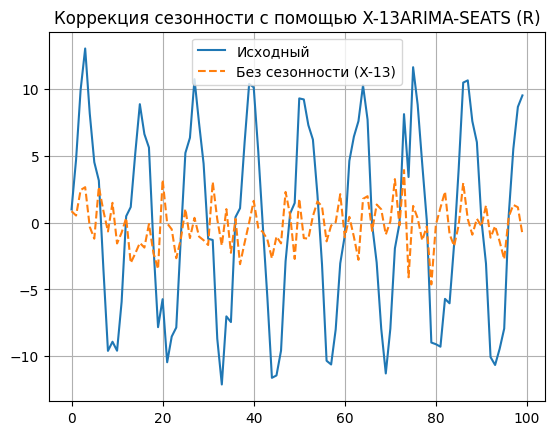

p-value: 5.272932425522535e-18


In [4]:
# Импортируем R-пакет seasonal
seasonal = importr('seasonal')

# Конвертируем pandas → R time series
with localconverter(ro.default_converter + pandas2ri.converter):
    r_ts = ro.conversion.py2rpy(seasonal_series)

# Оборачиваем в ts объект с периодом 12
base = importr('base')
stats = importr('stats')
ts_r = stats.ts(r_ts, frequency=12, start=ro.IntVector([2000, 1]))

# Применяем X13
res = seasonal.seas(ts_r)

# Извлекаем скорректированный ряд
adjusted = base.as_numeric(seasonal.final(res))

# Назад в pandas
with localconverter(ro.default_converter + pandas2ri.converter):
    adjusted_pd = ro.conversion.rpy2py(adjusted)

# Построим график
import matplotlib.pyplot as plt
plt.plot(seasonal_series, label="Исходный")
plt.plot(adjusted_pd, label="Без сезонности (X-13)", linestyle="--")
plt.legend()
plt.grid(True)
plt.title("Коррекция сезонности с помощью X-13ARIMA-SEATS (R)")
plt.show()

adjusted_pd_result = adfuller(adjusted_pd)
print(f'p-value: {adjusted_pd_result[1]}')

**p-value < 0.05 → ряд стационарный** 

### Метод 4. Fourier-фильтрация
Это способ разложения временного ряда на синусоиды разных частот (через БПФ, Fast Fourier Transform), чтобы:
Удалить высокочастотный шум
Или наоборот — вырезать низкочастотную (сезонную) компоненту
d — интервал между отсчётами по времени (в единицах времени)



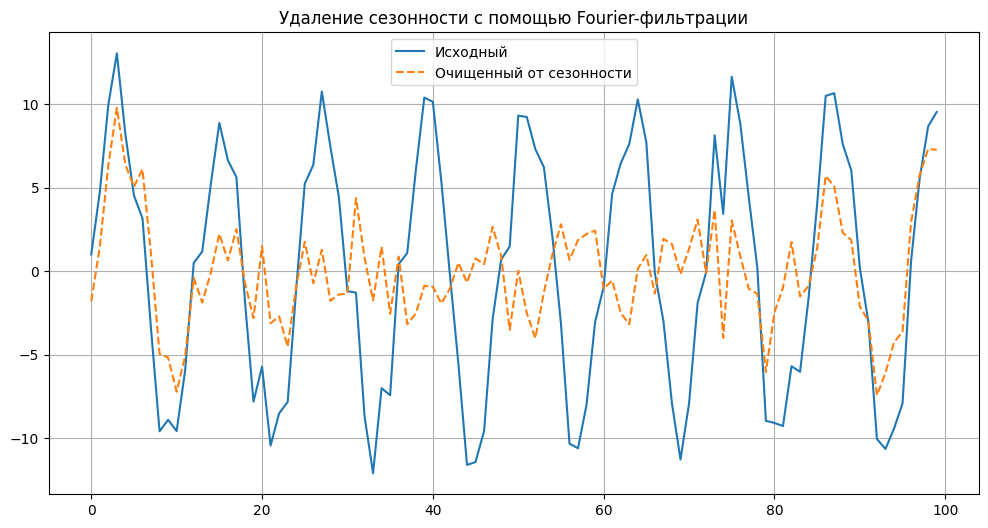

p-value: 3.6243431185569355e-10


In [12]:
ts = seasonal_series.copy()
ts = ts - ts.mean()  # Центрируем, чтобы убрать DC-компонент

n = len(ts)

# Fourier-преобразование
fft = np.fft.fft(ts)
frequencies = np.fft.fftfreq(n, d=1)

# Обнулим сезонные частоты (например, 1/12, 2/12 и т.п.)
seasonal_freqs = [1/12, 2/12]
filtered_fft = fft.copy()
for i, freq in enumerate(frequencies):
    if any(np.isclose(abs(freq), sf, atol=0.01) for sf in seasonal_freqs):
        filtered_fft[i] = 0

# Обратное преобразование
filtered = np.fft.ifft(filtered_fft).real

# График
plt.figure(figsize=(12,6))
plt.plot(seasonal_series, label='Исходный')
plt.plot(seasonal_series.index, filtered, label='Очищенный от сезонности', linestyle='--')
plt.legend()
plt.grid(True)
plt.title('Удаление сезонности с помощью Fourier-фильтрации')
plt.show()

filtered_result = adfuller(filtered)
print(f'p-value: {filtered_result[1]}')

**p-value < 0.05 → ряд стационарный** 

### Метод 5. SSA (основное поиск компонент)

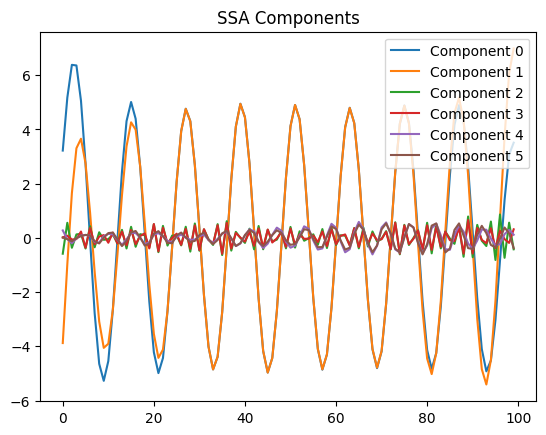

In [14]:
# Инициализация SSA
ssa2 = SingularSpectrumAnalysis(window_size=24)
components = ssa2.fit_transform(seasonal_series.values.reshape(1, -1))

for i in range(6):
    plt.plot(components[0, i], label=f'Component {i}')
plt.legend()
plt.title('SSA Components')
plt.show()


In [16]:

# Визуально определяем, что компоненты 0 и 1 — это сезонность
seasonal_component = components[0, 0] + components[0, 1]

# Удаляем сезонность из ряда
deseasonalized2 = seasonal_series - seasonal_component

# ADF-тест
adf_result2 = adfuller(deseasonalized2)
print(f"ADF p-value (SSA deseasonalized): {adf_result2[1]:.5f}")


ADF p-value (SSA deseasonalized): 0.02141


**p-value < 0.05 → ряд стационарный**

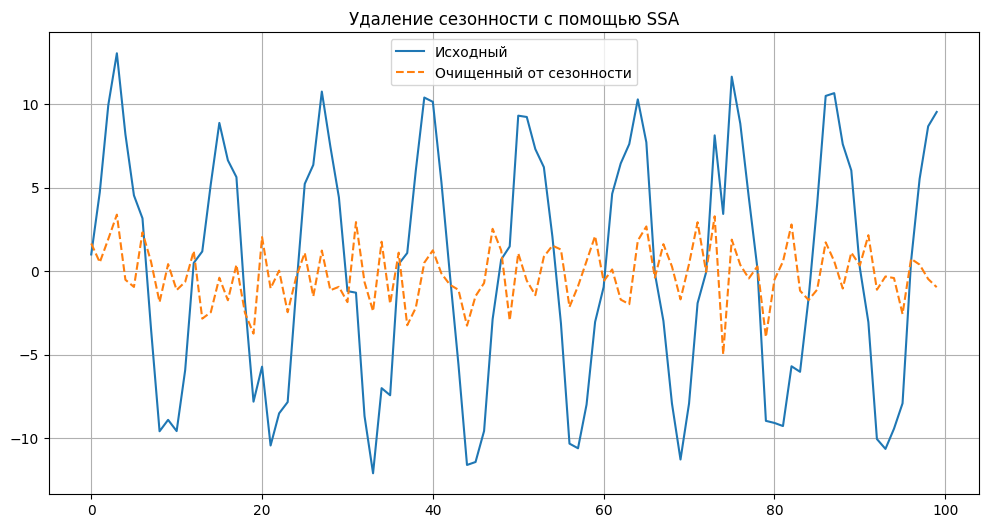

In [17]:
# График
plt.figure(figsize=(12,6))
plt.plot(seasonal_series, label='Исходный')
plt.plot(deseasonalized2, label='Очищенный от сезонности', linestyle='--')
plt.legend()
plt.grid(True)
plt.title('Удаление сезонности с помощью SSA')
plt.show()

#### Автоматизация поиска компонент (сведение графика к численным значениям(чреез квадрат) и выбор набибольших)

In [24]:
# SSA
ssa3 = SingularSpectrumAnalysis(window_size=20)
components3 = ssa3.fit_transform(seasonal_series.values.reshape(1, -1))
components3 = components3[0]  # убираем batch размерность


Component 0: Energy = 1622.14
Component 1: Energy = 955.43
Component 2: Energy = 15.54
Component 3: Energy = 7.81
Component 4: Energy = 10.13
Component 5: Energy = 7.93
Component 6: Energy = 6.52
Component 7: Energy = 4.70
Component 8: Energy = 6.80
Component 9: Energy = 5.33
Component 10: Energy = 4.15
Component 11: Energy = 4.18
Component 12: Energy = 4.53
Component 13: Energy = 9.69
Component 14: Energy = 3.37
Component 15: Energy = 2.23
Component 16: Energy = 1.89
Component 17: Energy = 1.24
Component 18: Energy = 1.44
Component 19: Energy = 1.58


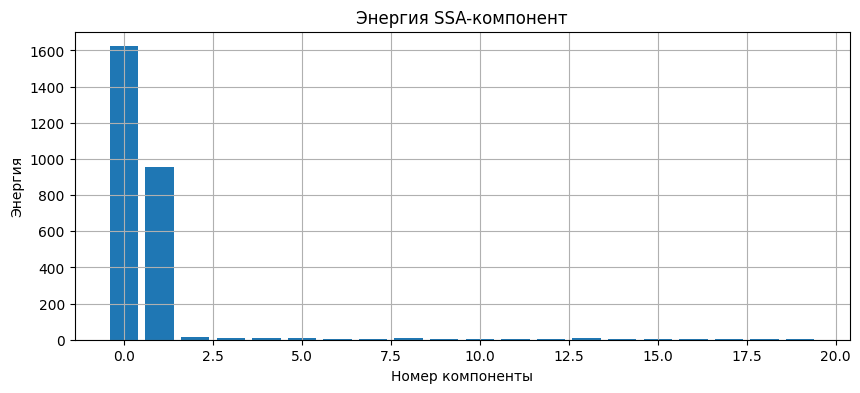

In [26]:
energies = np.sum(components3**2, axis=1)

for i, e in enumerate(energies):
    print(f"Component {i}: Energy = {float(e):.2f}")

plt.figure(figsize=(10, 4))
plt.bar(range(len(energies)), energies)
plt.title("Энергия SSA-компонент")
plt.xlabel("Номер компоненты")
plt.ylabel("Энергия")
plt.grid(True)
plt.show()

ADF p-value (SSA deseasoned): 0.02348


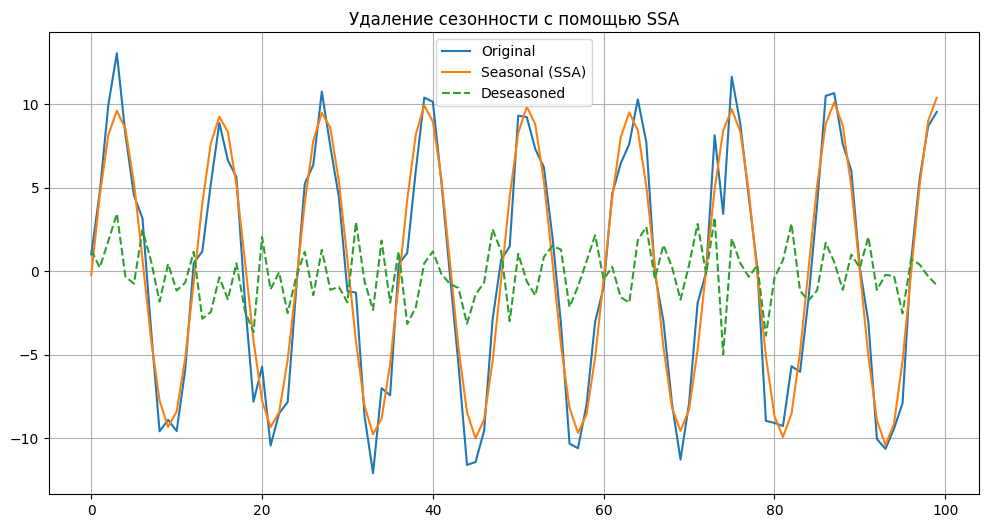

In [29]:
sorted_indices = np.argsort(-energies)
top_k = 2  # берём первые 2
seasonal_component3 = np.sum(components3[sorted_indices[:top_k]], axis=0)
deseasoned3 = seasonal_series - seasonal_component3

adf_result = adfuller(deseasoned3)
print(f"ADF p-value (SSA deseasoned): {adf_result[1]:.5f}")

plt.figure(figsize=(12, 6))
plt.plot(seasonal_series, label="Original")
plt.plot(seasonal_component3, label="Seasonal (SSA)")
plt.plot(deseasoned3, label="Deseasoned", linestyle='--')
plt.legend()
plt.title("Удаление сезонности с помощью SSA")
plt.grid(True)
plt.show()


**p-value < 0.05 → ряд стационарный**

### Метод 6: ARIMA-дисференцирование (для очистки от сезонности)
- Пусть сезонный период m=12 (месяцы)
- order=(p,d,q) — обычные параметры (для удаления тренда можно d=0 или 1)
- seasonal_order=(P,D,Q,m) — сезонные параметры, где D — порядок сезонного дифференцирования

ADF p-value (seasonal differencing): 0.00015


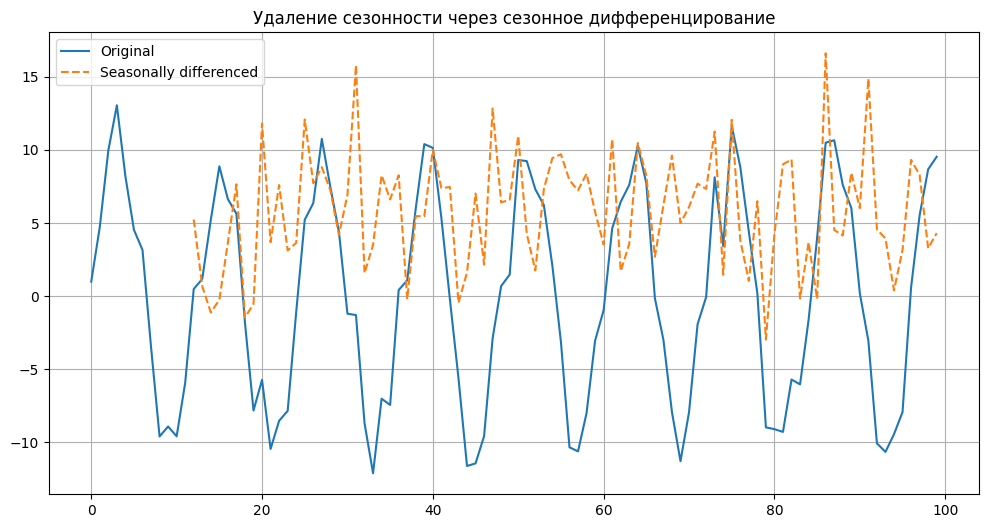

In [32]:
# Чтобы удалить сезонность, делаем сезонное дифференцирование D=1:
model = SARIMAX(seasonal_series, order=(0, 0, 0), seasonal_order=(0, 1, 0, 12))
fit = model.fit(disp=False)

# Получаем сезонно разностный ряд (очищенный от сезонности)
seasonally_differenced = fit.resid  

# Чтобы получить чистый ряд (без сезонности), можно взять сезонно разностный ряд:
seasonally_differenced = time_series.diff(12).dropna()

adf_result = adfuller(seasonally_differenced)
print(f"ADF p-value (seasonal differencing): {adf_result[1]:.5f}")


plt.figure(figsize=(12, 6))
plt.plot(seasonal_series, label="Original")
plt.plot(seasonally_differenced, label="Seasonally differenced", linestyle='--')
plt.legend()
plt.title("Удаление сезонности через сезонное дифференцирование")
plt.grid(True)
plt.show()

**p-value < 0.05 → ряд стационарный**

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -230.977
Date:                            Срд, 04 чэр 2025   AIC                            471.953
Time:                                    14:44:58   BIC                            484.979
Sample:                                         0   HQIC                           477.225
                                            - 100                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0001      0.001     -0.086      0.932      -0.003       0.002
ma.L1          0.0807      0.091   

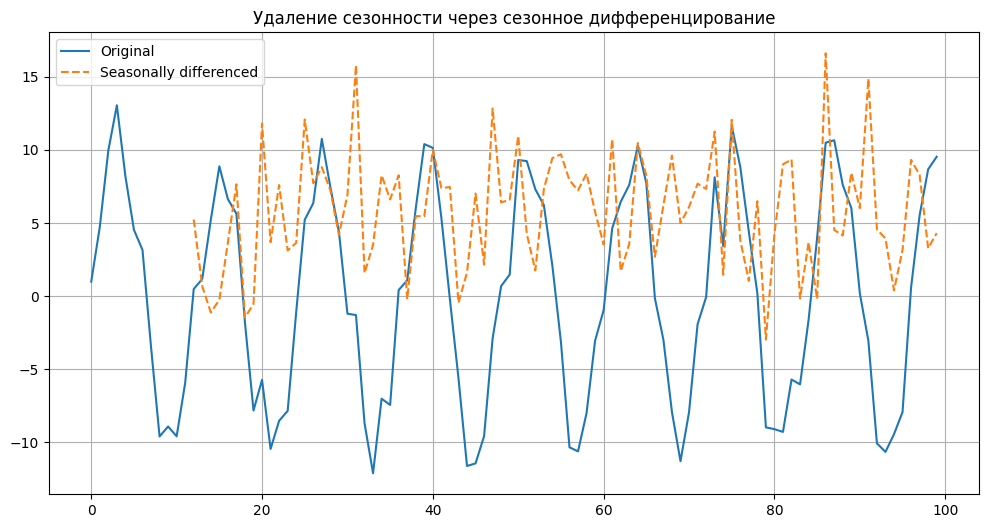

In [34]:
model = auto_arima(seasonal_series, seasonal=True, m=12)
print(model.summary())

seasonally_differenced_auto = time_series.diff(12).dropna()

# Проверка стационарности
adf_result_auto = adfuller(seasonally_differenced_auto)
print(f"ADF p-value (seasonal differencing): {adf_result_auto[1]:.5f}")

plt.figure(figsize=(12, 6))
plt.plot(seasonal_series, label="Original")
plt.plot(seasonally_differenced_auto, label="Seasonally differenced", linestyle='--')
plt.legend()
plt.title("Удаление сезонности через сезонное дифференцирование")
plt.grid(True)
plt.show()

**p-value < 0.05 → ряд стационарный**

## Методы стабилизации дисперсии

Методы

- Логарифмирование (y > 0, иначе сдвиг )
- Корень (sqrt, pow)	 (y > 0, иначе сдвиг )
- Box-Cox (y > 0, иначе сдвиг )
- Скользящая средняя (Rolling stats)
- Логарифмические разности (log-differencing)

| Метод                     | Цель                        | Убирает тренд? | Стабилизирует дисперсию? | Комментарий                                   |
| ------------------------- | --------------------------- | -------------- | ------------------------ | --------------------------------------------- |
| Логарифмирование          | Сгладить дисперсию          | ❌              | ✅                        | Простое сжатие больших значений               |
| Корень                    | Сгладить дисперсию          | ❌              | ✅                        | Используется если log не подходит             |
| **Box-Cox**               | Стабилизация + нормализация | ❌              | ✅                        | Авто-оценка λ, требует `y > 0`                |
| Логарифмические разности  | Убрать тренд + дисперсию    | ✅              | ✅                        | Только положительные `y`, чувствителен к шуму |
| Скользящая средняя        | Убрать тренд / сгладить     | ✅              | 🔸 Частично              | Чувствителен к выбору `w`                     |
| `(y - MA)/STD` (Z-score)  | Стандартизация              | 🔸 Частично    | ✅                        | Центрирует и нормирует окно                   |


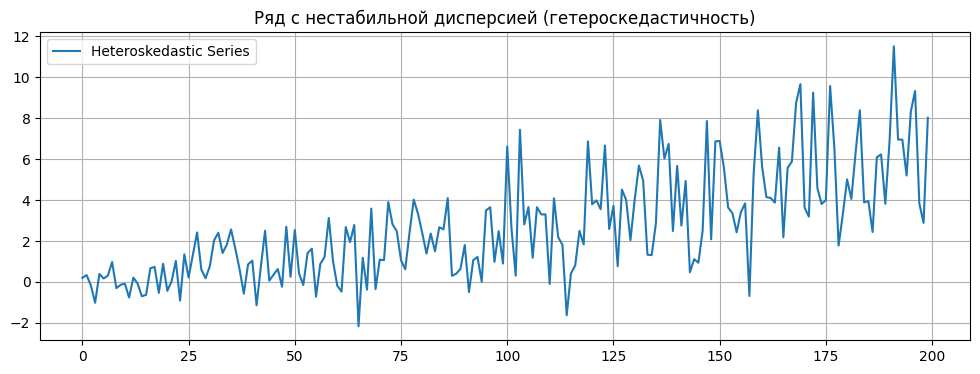

In [2]:
# Сгенерируем синтетически данные для работы с дисперсией
n = 200
trend = np.linspace(0, 5, n)
heteroskedastic_noise = np.random.normal(scale=np.linspace(0.5, 3, n), size=n)

dis_series = trend + heteroskedastic_noise
dis_ts = pd.Series(dis_series)

plt.figure(figsize=(12, 4))
plt.plot(dis_ts, label='Heteroskedastic Series')
plt.title('Ряд с нестабильной дисперсией (гетероскедастичность)')
plt.grid(True)
plt.legend()
plt.show()


In [4]:
# Исходный ряд
ts = dis_ts.copy()

min_val = ts.min()
if min_val <= 0:
    shift = abs(min_val) + 1e-3
else:
    shift = 0

ts_shifted = ts + shift




### Метод 1. Логарифмирование (если нет 0/отрицательных). Просто логарифмируем

Значение  p -  1.9183309223194066e-21


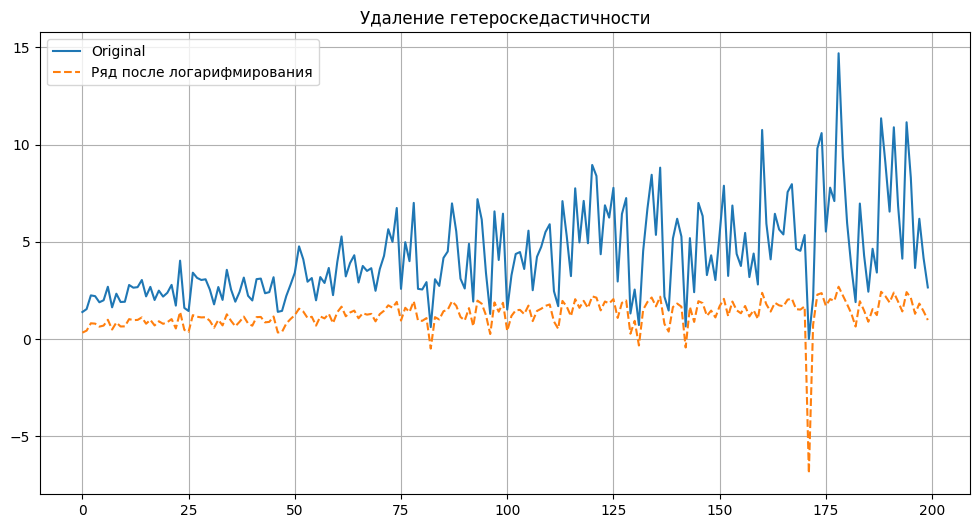

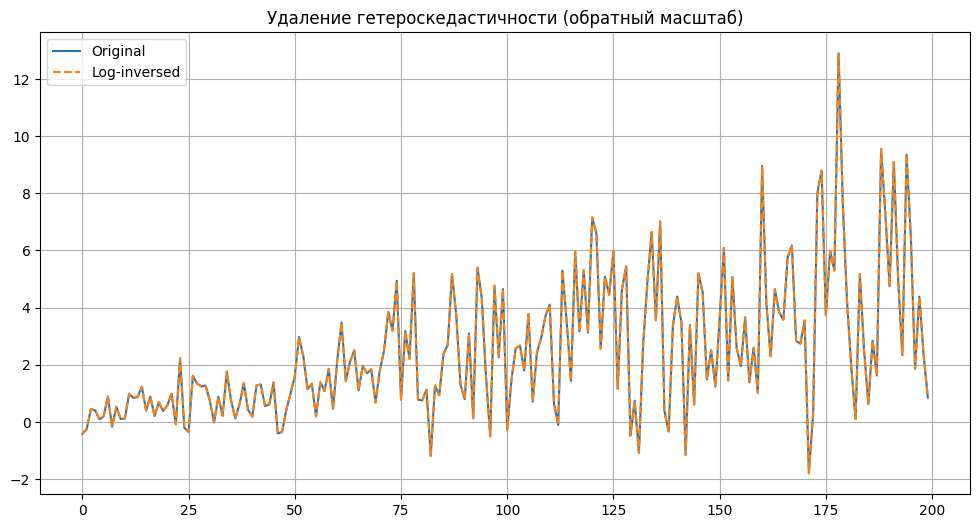

In [61]:
log = np.log(ts_shifted)
adf_log = adfuller(log.dropna())[1]
print('Значение  p - ',adf_log)

plt.figure(figsize=(12, 6))
plt.plot(ts_shifted, label="Original")
plt.plot(log, label="Ряд после логарифмирования", linestyle='--')
plt.legend()
plt.title("Удаление гетероскедастичности")
plt.grid(True)
plt.show()

# Восстанавливаем в оригинальынй масштаь
reconstructed = np.exp(log) - shift

plt.figure(figsize=(12, 6))
plt.plot(ts, label="Original")
plt.plot(reconstructed, label="Log-inversed", linestyle='--')
plt.legend()
plt.title("Удаление гетероскедастичности (обратный масштаб)")
plt.grid(True)
plt.show()

**p-value < 0.05 → ряд стационарный**

### Метод 2. Корень (Просто извлекаем корень)

Значение  p -  0.7433340485358146


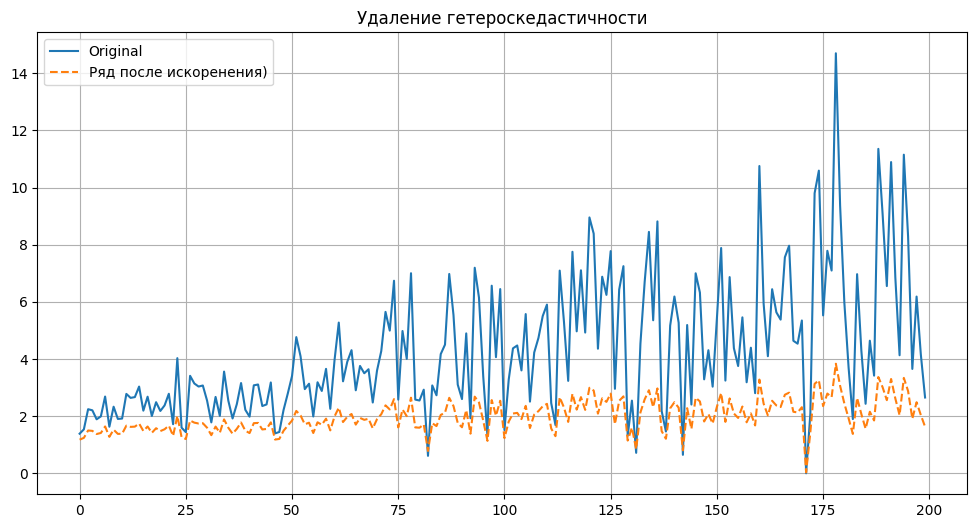

In [62]:

sqrt = np.sqrt(ts_shifted + 1e-6)
adf_sqrt = adfuller(sqrt.dropna())[1]
print('Значение  p - ',adf_sqrt)

plt.figure(figsize=(12, 6))
plt.plot(ts_shifted, label="Original")
plt.plot(sqrt, label="Ряд после искоренения)", linestyle='--')
plt.legend()
plt.title("Удаление гетероскедастичности")
plt.grid(True)
plt.show()


**p-value > 0.05 → ряд нестационарный**

### Метод 3. Box-Cox
Box-Cox —
Формула преобразования
Для положительных значений ряда 
𝑦𝑡>0
𝑦𝑡(𝜆)={𝑦𝑡𝜆−1𝜆,если 𝜆≠0
      ln(𝑦𝑡),если 𝜆=0
λ — параметр преобразования, который выбирается так, чтобы максимизировать "нормальность" и стационарность преобразованного ряда.
При 
𝜆=1 — преобразование не меняет данные (идентичное).

При 
𝜆=0 — это логарифмическое преобразование.

Зачем это нужно?
Стабилизация дисперсии: если дисперсия меняется с уровнем ряда (гетероскедастичность), Box-Cox помогает сделать дисперсию более постоянной.
Приближение к нормальному распределению: многие статистические методы лучше работают при нормальных данных.
Улучшение свойств для моделей: ряд становится более пригодным для таких моделей, как ARIMA.
Как подбирается 𝜆

Обычно 
λ выбирается автоматически через метод максимального правдоподобия, минимизирующий ошибку модели или отклонение от нормальности.

В scipy.stats есть функция boxcox, которая подбирает 𝜆 оптимально на основе входных данных.

Ограничения и нюансы
Данные должны быть положительными (иначе надо сдвигать).

Параметр 
λ — вещественное число, часто в интервале [−5,5]
Если λ близок к 0, часто используют логарифмирование.

Значение  p -  0.7438163259637095


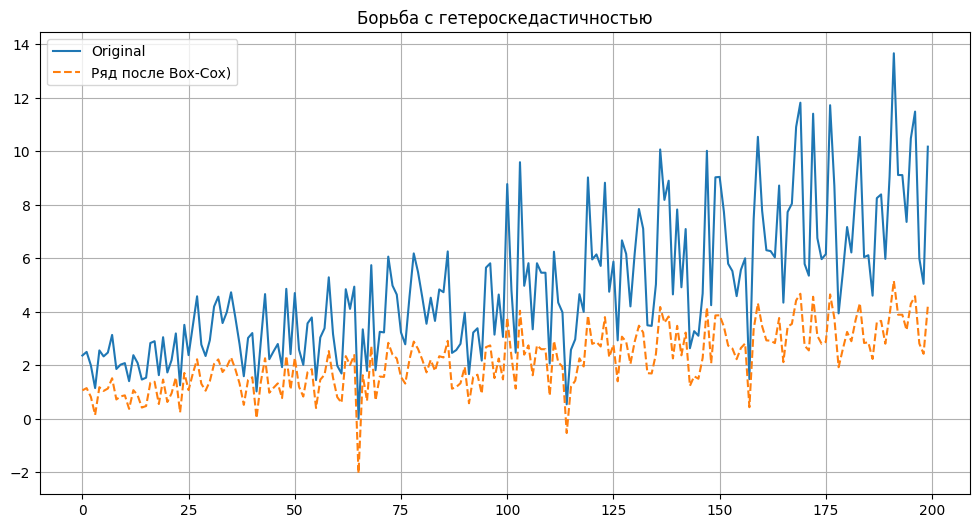

In [6]:
boxcox_transformed, lam = boxcox(ts_shifted + 1e-6)
adf_boxcox = adfuller(boxcox_transformed)[1]

print('Значение  p - ',adf_boxcox)

plt.figure(figsize=(12, 6))
plt.plot(ts_shifted, label="Original")
plt.plot(boxcox_transformed, label="Ряд после Box-Cox)", linestyle='--')
plt.legend()
plt.title("Борьба с гетероскедастичностью")
plt.grid(True)
plt.show()



**p-value > 0.05 → ряд нестационарный**

### Модель 4. Скользящая средняя (Rolling stats)


In [67]:
for w in [6, 12, 18, 24]:
    rolling_mean = ts.rolling(window=w, center=True).mean()
    detrended = time_series - rolling_mean
    detrended = detrended.dropna()
    pvalue = adfuller(detrended)[1]
    print(f"Window={w}: ADF p-value = {pvalue:.4f}")


Window=6: ADF p-value = 0.9374
Window=12: ADF p-value = 0.7590
Window=18: ADF p-value = 0.5678
Window=24: ADF p-value = 0.8320


Значение  p -  1.5209339355021612e-21


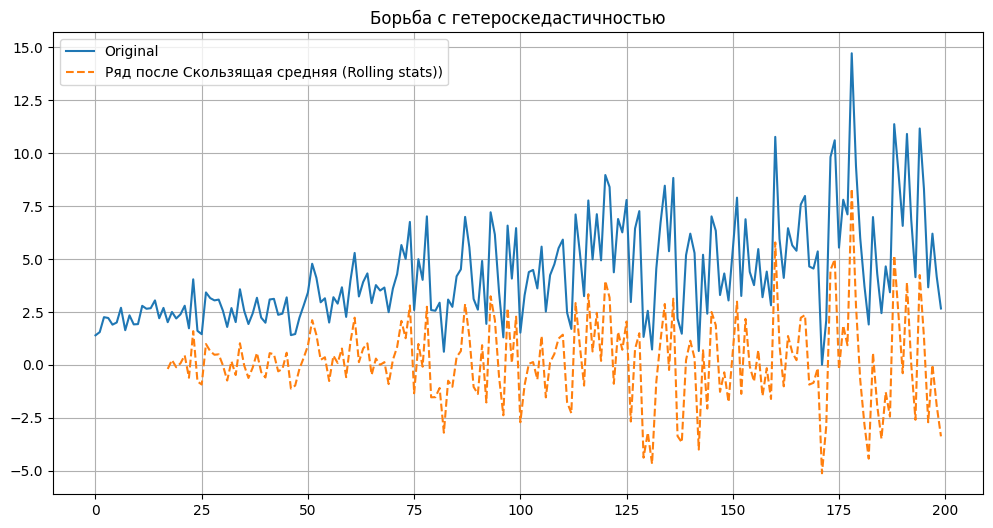

In [73]:
window = 18
rolling = ts - ts.rolling(window).mean()
adf_rolling = adfuller(rolling.dropna())[1]

print('Значение  p - ',adf_rolling)

plt.figure(figsize=(12, 6))
plt.plot(ts_shifted, label="Original")
plt.plot(rolling, label="Ряд после Скользящая средняя (Rolling stats))", linestyle='--')
plt.legend()
plt.title("Борьба с гетероскедастичностью")
plt.grid(True)
plt.show()


**p-value < 0.05 → ряд стационарный**

### Метод 5: Логарифмические разности (log-differencing)

Значение  p -  5.61888105892708e-12


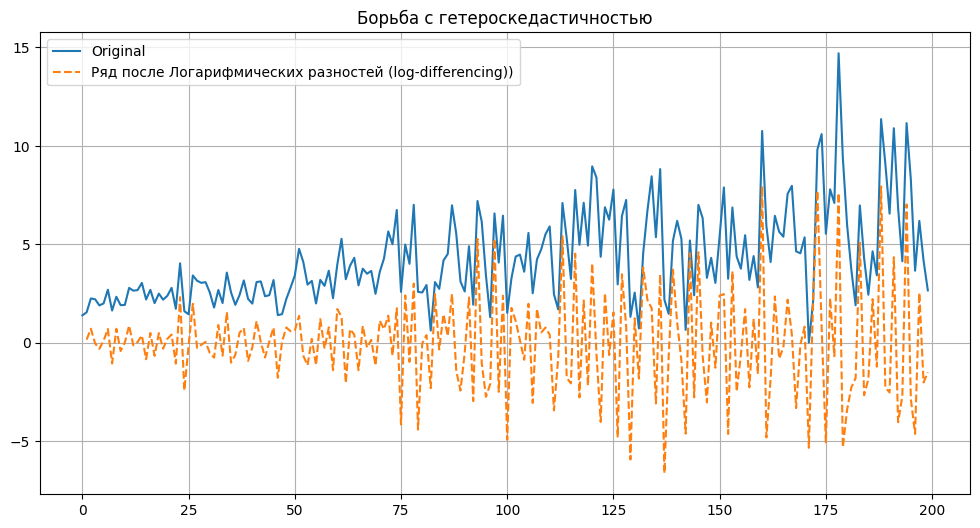

In [72]:
log_diff = ts.diff()
adf_logdiff = adfuller(log_diff.dropna())[1]

print('Значение  p - ',adf_logdiff)

plt.figure(figsize=(12, 6))
plt.plot(ts_shifted, label="Original")
plt.plot(log_diff, label="Ряд после Логарифмических разностей (log-differencing))", linestyle='--')
plt.legend()
plt.title("Борьба с гетероскедастичностью")
plt.grid(True)
plt.show()


**p-value < 0.05 → ряд стационарный**

In [71]:
print("ADF p-values (↓ лучше):")
print(f"Original:     {adfuller(df['Original'])[1]:.5f}")
print(f"Log:          {adf_log:.5f}")
print(f"Sqrt:         {adf_sqrt:.5f}")
print(f"Box-Cox:      {adf_boxcox:.5f} (λ = {lam:.3f})")
print(f"RollingDiff:  {adf_rolling:.5f}")
print(f"LogDiff:      {adf_logdiff:.5f}")

ADF p-values (↓ лучше):
Original:     0.78600
Log:          0.00000
Sqrt:         0.74333
Box-Cox:      0.73100 (λ = 0.433)
RollingDiff:  0.00000
LogDiff:      0.00000


Для гетероскедастичных рядов с трендом:
Логарифмирование + разности — наиболее надёжный и простой метод.
Box-Cox хорош, если параметры удачно подобраны и ряд не содержит нулей/отрицательных значений.
Скользящая статистика — больше для сглаживания, не всегда улучшает стационарность.
НАдо проверять визуально — ADF не всегда ловит проблемы с изменением дисперсии.

## Методы работы с выбросами

Методы:
- Winsorization	
- Удаление выбросов	Z-оценка, IQR и др.	

| Метод             | Сохраняет данные? | Простота | Риски и ограничения                  |
| ----------------- | ----------------- | -------- | ------------------------------------ |
| Winsorization     | Да                | Высокая  | Искажает данные, но сохраняет размер |
| Удаление выбросов | Нет               | Средняя  | Потеря данных, если выбросов много   |


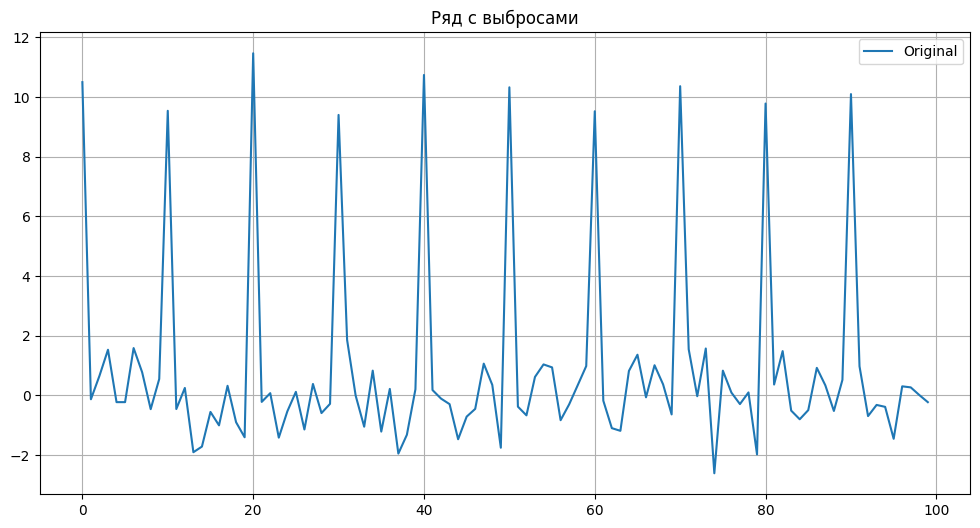

Значение  p -  0.05429189659215418


In [11]:
# Генерируем данные с выбросами
np.random.seed(42)
data = np.random.normal(loc=0, scale=1, size=100)
data[::10] += 10  # Добавим выбросы каждые 10 элементов
data_ser = pd.Series(data)

plt.figure(figsize=(12, 6))
plt.plot(data_ser, label="Original")
plt.legend()
plt.title("Ряд с выбросами")
plt.grid(True)
plt.show()

adf_data = adfuller(data_ser.dropna())[1]

print('Значение  p - ',adf_data)

### Метод 1. Winsorization — Винзоризация
Вместо удаления выбросов, их значения заменяются на ближайшие «нормальные» значения (например, заменяем очень большие значения на верхний перцентиль, а очень маленькие — на нижний).
Пример:
Если выброс — очень большое значение в хвосте, то его «обрезают» до, скажем, 95-го перцентиля.
Аналогично с нижним хвостом — обрезают до 5-го перцентиля.

Преимущества:
Сохраняется количество наблюдений
Меньшая потеря данных, чем при удалении

Недостатки:
Некоторые значения искусственно ограничены, что может исказить анализ

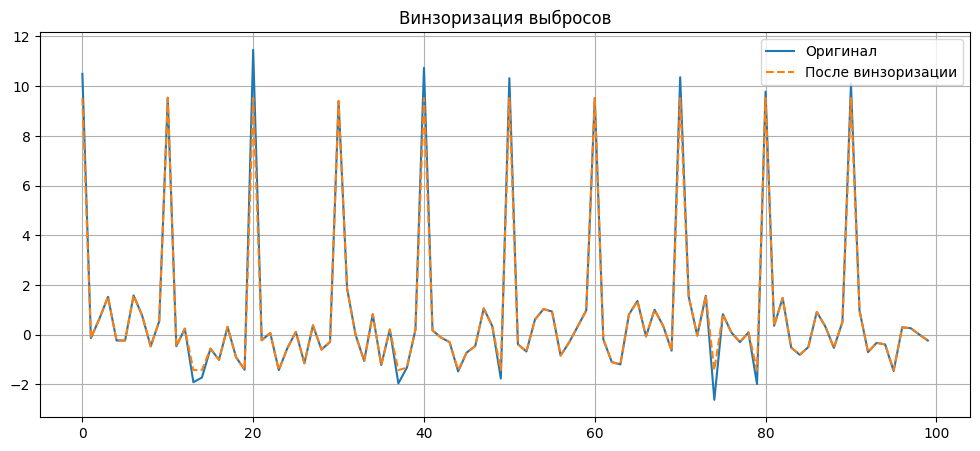

ADF p-value после винзоризации: 0.17784597641150834


In [29]:
# Винзоризация: обрезаем 5% с каждой стороны
winsorized_data = winsorize(data_ser, limits=[0.08, 0.08])

winsorized_array = np.asarray(winsorized_data)

# Если хотите обратно Series (для удобства)
winsorized_series = pd.Series(winsorized_array, index=data_ser.index)

plt.figure(figsize=(12, 5))
plt.plot(data_ser, label='Оригинал')
plt.plot(winsorized_series, label='После винзоризации', linestyle='--')
plt.legend()
plt.title('Винзоризация выбросов')
plt.grid()
plt.show()

# ADF-тест (всё на массиве или Series без пропусков)
winsor_pvalue = adfuller(winsorized_series)[1]

print('ADF p-value после винзоризации:', winsor_pvalue)

### Метод 2. Удаление выбросов (Z-оценка, IQR)

a) Метод Z-оценки
- Вычисляем Z-оценки: насколько каждое значение отклоняется от среднего в единицах стандартного отклонения.
- Значения с |Z| > порог (обычно 3) считаются выбросами и удаляются.

б)Вычисляем Q1 (25-й перцентиль) и Q3 (75-й перцентиль).
- IQR = Q3 - Q1.
- Выбросы — точки, выходящие за границы:
- [Q1 - 1.5IQR, Q3 + 1.5IQR]
- Такие точки удаляются или обрезаются.

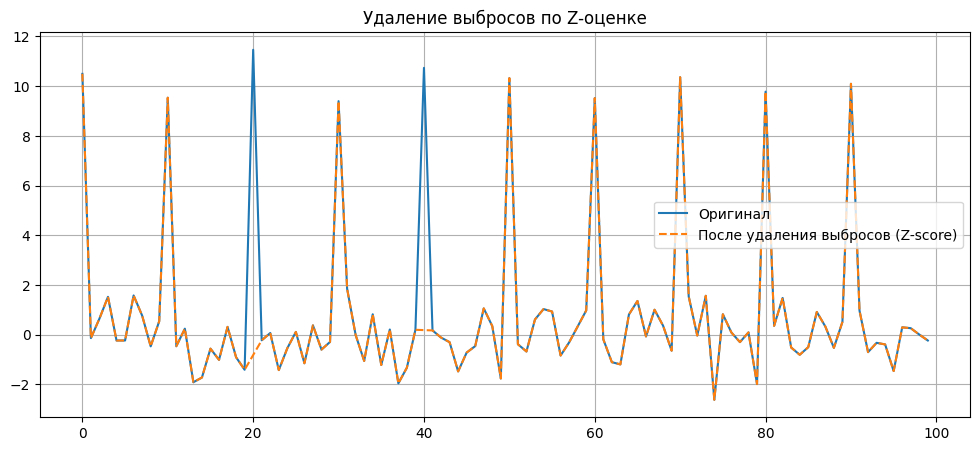

Значение  p -  0.24075153544750927


In [27]:
z_scores = stats.zscore(data_ser)
filtered_entries = np.abs(z_scores) < 3
cleaned_series = data_ser[filtered_entries]



plt.figure(figsize=(12, 5))
plt.plot(data_ser, label='Оригинал')
plt.plot(cleaned_series, label='После удаления выбросов (Z-score)', linestyle='--')
plt.legend()
plt.title('Удаление выбросов по Z-оценке')
plt.grid()
plt.show()

cleaned_data = adfuller(cleaned_series.dropna())[1]
print('Значение  p - ',cleaned_data)

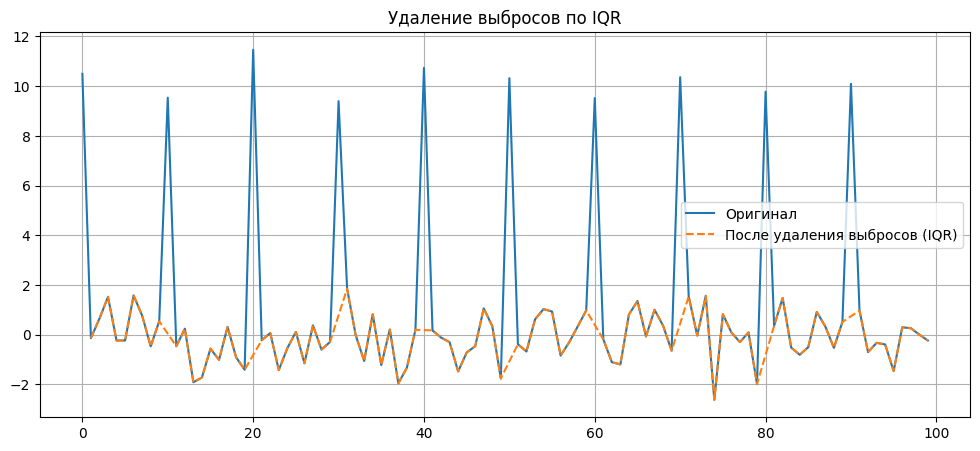

Значение  p -  0.02312138809188452


In [28]:
Q1 = data_ser.quantile(0.25)
Q3 = data_ser.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_series = data_ser[(data_ser >= lower_bound) & (data_ser <= upper_bound)]

plt.figure(figsize=(12, 5))
plt.plot(data_ser, label='Оригинал')
plt.plot(filtered_series, label='После удаления выбросов (IQR)', linestyle='--')
plt.legend()
plt.title('Удаление выбросов по IQR')
plt.grid()
plt.show()

filtered_series_data = adfuller(filtered_series.dropna())[1]
print('Значение  p - ',filtered_series_data)

Винзоризация и Z-оценка — методы обработки выбросов, которые могут уменьшить влияние экстремальных значений, но не всегда улучшают свойства ряда для стационарности (ADF-тест). Иногда выбросы "замаскировывают" нестационарность, и их удаление может сделать тренды или сезонность более явными.
Метод IQR (интерквартильный размах) — более жёсткий и зачастую эффективный способ убрать аномалии, при этом, похоже, он помог добиться более выраженной стационарности.

## Методы работы с масштабированием и шумами

Методы:
- Z-преобразование (x - μ) / σ	
- Мин-Макс масштабирование	
- Робастное шкалирование	
- Эксп. сглаживание
- Holt’s Linear Trend Method (двойное сглаживание)
- Holt-Winters (тройное сглаживание)
- Wavelet-декомпозиция
- Скользящее среднее
- PCA
- SVD
- Empirical Mode Decomposition (EMD)	
- Бинаризация
- Кластеризация	
- Kalman filter	


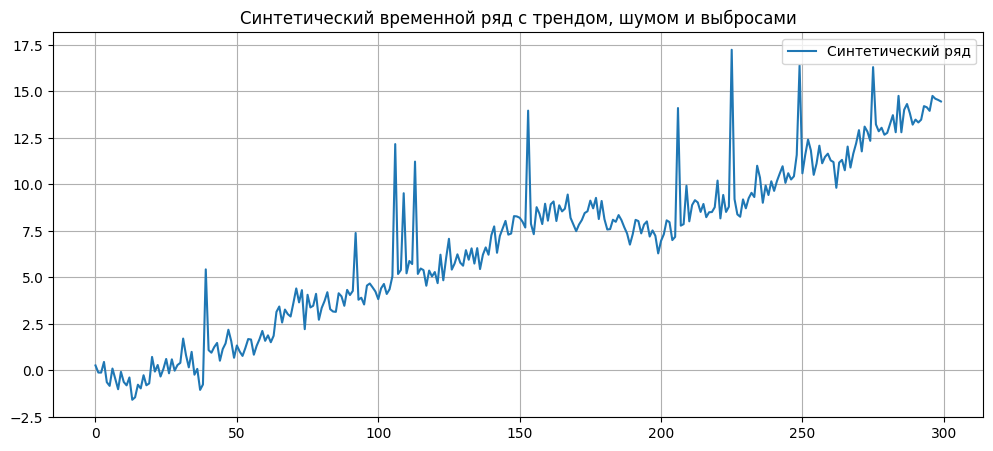

ADF p-value: 0.90703


In [37]:
# Генерация данных
np.random.seed(42)
n = 300

# Компоненты
trend = np.linspace(0, 10, n)
noise = np.random.normal(scale=0.5, size=n)
spikes = np.zeros(n)
spikes[np.random.choice(n, 10, replace=False)] = np.random.normal(5, 2, size=10)  # выбросы
jumps = np.random.normal(0, 0.2, size=n).cumsum()

# Итоговый ряд
raw_series = trend + noise + spikes + jumps
ts = pd.Series(raw_series)

# Визуализация
plt.figure(figsize=(12, 5))
plt.plot(ts, label="Синтетический ряд")
plt.title("Синтетический временной ряд с трендом, шумом и выбросами")
plt.grid()
plt.legend()
plt.show()

p_z_base = adfuller(ts)[1]
print(f"ADF p-value: {p_z_base:.5f}")

### Метод 1. Z-преобразование (x - μ) / σ	
📌 Z-преобразование (Стандартизация)
- Формула: 𝑧=(𝑥−𝜇) / 𝜎
- Цель: привести данные к нулевому среднему и единичному стандартному отклонению.

📌 Преимущества:
- Убирает масштаб, полезно для моделей, чувствительных к масштабу признаков.
- Хорошо работает, если данные приближены к нормальному распределению.

📌 Ограничения:
- Неустойчив к выбросам (т.к. использует среднее и стандартное отклонение).

| Эффект                                                 | Объяснение                                                                                                                                                   |
| ------------------------------------------------------ | ------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| 📉 Тренд может стать слабее                            | Z-преобразование "центрирует" ряд: вычитает среднее, нормируя относительно стандартного отклонения. Это *может маскировать слабый тренд*, особенно линейный. |
| 🔇 Снижение шума и выбросов (визуально)                | Масштаб всех колебаний становится сопоставимым (в пределах ±2-3σ), поэтому выбросы становятся менее "выпирающими".                                           |
| 🧪 ADF p-value улучшился или остался примерно таким же | Иногда стандартизация помогает стационарности, иногда нет (ADF реагирует на автокорреляции, не только на масштаб).                                           |


- Z-преобразование не удаляет тренд, оно лишь убирает масштаб.
- Поэтому в задачах устранения тренда или сезонности — метод вспомогательный, но не финальный.
- Однако для моделей, чувствительных к масштабу (SVM, KNN, градиентные модели) — это обязательный preprocessing.


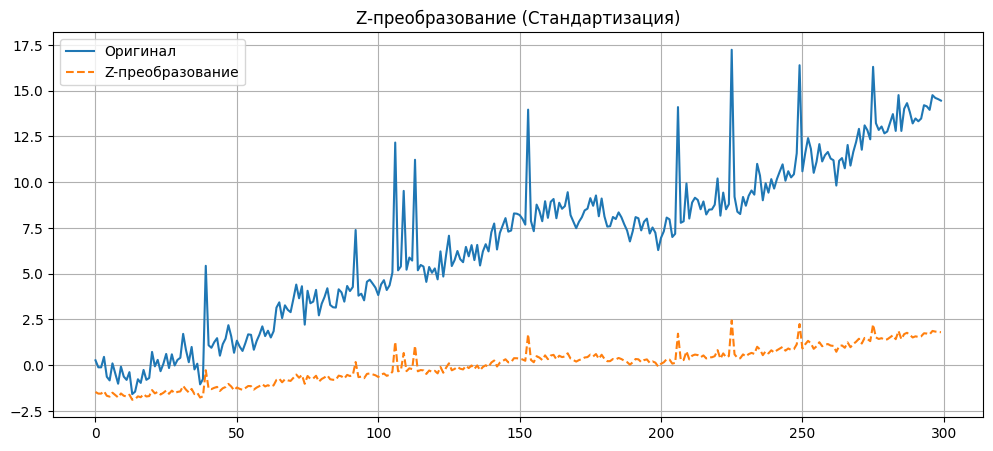

ADF p-value после Z-преобразования: 0.90703


In [38]:
scaler = StandardScaler()
z_scaled = scaler.fit_transform(ts.values.reshape(-1, 1)).flatten()

# Визуализация
plt.figure(figsize=(12, 5))
plt.plot(ts, label='Оригинал')
plt.plot(z_scaled, label='Z-преобразование', linestyle='--')
plt.title('Z-преобразование (Стандартизация)')
plt.grid()
plt.legend()
plt.show()

# ADF-тест

p_z = adfuller(z_scaled)[1]
print(f"ADF p-value после Z-преобразования: {p_z:.5f}")

### Метод 2. Масштабирование min-max
- Преобразует данные по формуле: 𝑥scaled=𝑥−𝑥min⁡/𝑥max⁡−𝑥min
- ⁡Все значения попадают в диапазон [0, 1] (или любой другой при задании feature_range).
- Сохраняет форму распределения, но сжимает шкалу.
- Очень чувствительно к выбросам!



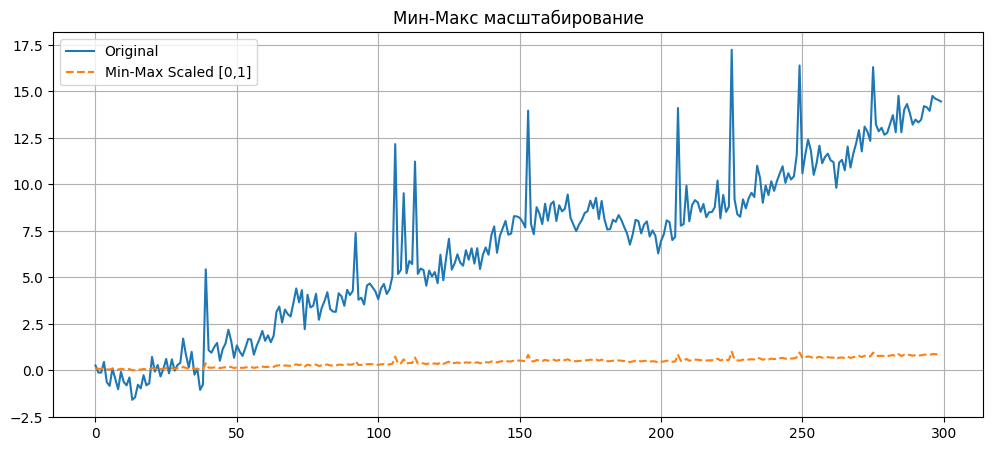

ADF p-value (Min-Max Scaled): 0.90703


In [40]:
scaler = MinMaxScaler()
minmax_scaled = scaler.fit_transform(ts.values.reshape(-1, 1)).flatten()

# Визуализация
plt.figure(figsize=(12, 5))
plt.plot(ts, label='Original')
plt.plot(minmax_scaled, label='Min-Max Scaled [0,1]', linestyle='--')
plt.title('Мин-Макс масштабирование')
plt.legend()
plt.grid(True)
plt.show()

# ADF-тест
pval_minmax = adfuller(minmax_scaled)[1]
print(f"ADF p-value (Min-Max Scaled): {pval_minmax:.5f}")

### Метод 3. Робастное масштабирование (RobustScaler)
Формула: 𝑥scaled=𝑥−median/IQR
где:
- median — медиана (устойчива к выбросам),
- IQR = Q3 - Q1 — межквартильный размах (обрезает 50% центра данных).

Отличие RobustScaler:
- Его сила не в улучшении стационарности, а в устойчивости к выбросам и асимметрии.
- Он особенно полезен перед ML-моделями, которым важна шкала, но нежелательны сильные выбросы (например, линейные модели, SVM и др.).

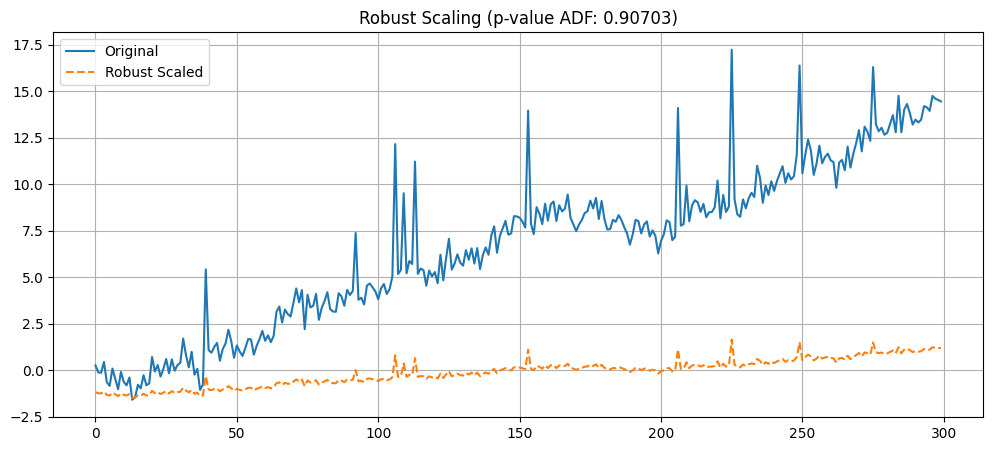

In [42]:
# Преобразуем в нужный формат
ts_values = ts.values.reshape(-1, 1)

# Применим робастное масштабирование
scaler = RobustScaler()
robust_scaled = scaler.fit_transform(ts_values).flatten()

# ADF-тест

adf_robust = adfuller(robust_scaled)[1]

# Визуализация
plt.figure(figsize=(12, 5))
plt.plot(ts, label='Original')
plt.plot(robust_scaled, label='Robust Scaled', linestyle='--')
plt.legend()
plt.grid()
plt.title(f'Robust Scaling (p-value ADF: {adf_robust:.5f})')
plt.show()



### Метод 4. Экспоненциальное сглаживание (Exponential Smoothing)
Exponential Smoothing — метод сглаживания, при котором:
Недавние значения получают больший вес, чем старые.
Вес убывает экспоненциально назад во времени.
В отличие от скользящего среднего, здесь нет фиксированного окна, и сглаживание более гибкое.

🧮 Формула (Simple ES) 𝑦^𝑡=𝛼𝑦𝑡+(1−𝛼)𝑦^𝑡
- 𝑦^𝑡  — сглаженное значение
- 𝑦𝑡 — текущее значение ряда
- α — параметр сглаживания (от 0 до 1)

- α→1: почти нет сглаживания
- α→0: сглаживание сильное

Простое экспоненциальное сглаживание (Simple ES) — сглаживает уровень ряда, но не учитывает тренд и сезонность. Оно помогает убрать шумы, но тренд и сезонность остаются.
Почему это важно?
- Эти методы — не для удаления тренда или сезонности, а для плавного приближения к данным, уменьшая шумы и выбросы без сильного искажения тренда или сезонности.
То есть:
- Если нужно сохранить форму ряда и убрать случайные флуктуации (шумы, выбросы) — эти методы отлично подходят.

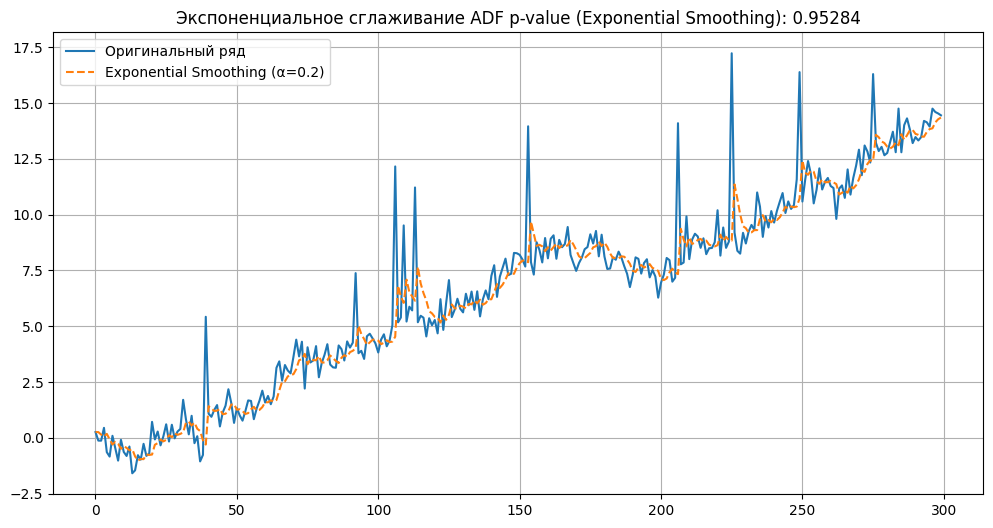

In [48]:
# Применим экспоненциальное сглаживание
model = SimpleExpSmoothing(ts).fit(smoothing_level=0.3, optimized=False)
smoothed_ts = model.fittedvalues
adf_exp = adfuller(smoothed_ts)[1]

plt.figure(figsize=(12, 6))
plt.plot(ts, label="Оригинальный ряд")
plt.plot(smoothed_ts, label="Exponential Smoothing (α=0.2)", linestyle='--')
plt.title(f"Экспоненциальное сглаживание ADF p-value (Exponential Smoothing): {adf_exp:.5f}")
plt.grid(True)
plt.legend()
plt.show()

### Метод 5. Holt’s Linear Trend Method (двойное сглаживание)
Этот метод учитывает:
Уровень (level) ряда
Тренд (trend)

📌 Формулы:

ℓ𝑡=𝛼𝑦𝑡+(1−𝛼)(ℓ𝑡−1+𝑏𝑡−1)
𝑏𝑡=𝛽(ℓ𝑡−ℓ𝑡−1)+(1−𝛽)𝑏𝑡−1
𝑦^𝑡+ℎ=ℓ𝑡+ℎ𝑏𝑡

Двойное сглаживание (Holt) — учитывает и уровень, и тренд. Сглаживает шумы, но сохраняет тренд, не убирает сезонность.
Почему это важно?
- Эти методы — не для удаления тренда или сезонности, а для плавного приближения к данным, уменьшая шумы и выбросы без сильного искажения тренда или сезонности.
То есть:
- Если нужно сохранить форму ряда и убрать случайные флуктуации (шумы, выбросы) — эти методы отлично подходят.

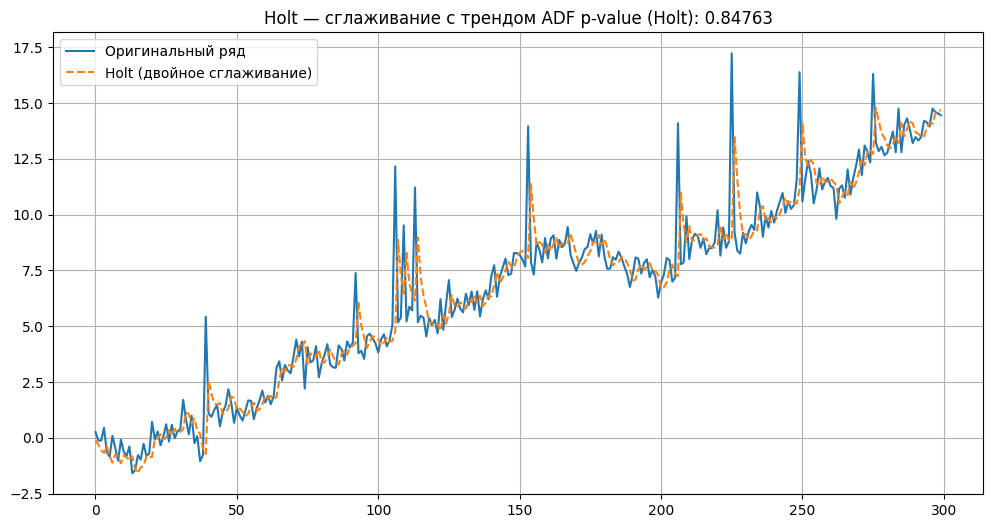

In [56]:
# Holt — сглаживание с трендом
holt_model = Holt(ts).fit(smoothing_level=0.5, smoothing_trend=0.1, optimized=False)
holt_smoothed = holt_model.fittedvalues

adf_holt = adfuller(holt_smoothed)[1]

plt.figure(figsize=(12, 6))
plt.plot(ts, label="Оригинальный ряд")
plt.plot(holt_smoothed, label="Holt (двойное сглаживание)", linestyle='--')
plt.title(f"Holt — сглаживание с трендом ADF p-value (Holt): {adf_holt:.5f}")
plt.grid(True)
plt.legend()
plt.show()



### Метод 6. Holt-Winters (тройное сглаживание)
Учитывает:
- Уровень
- Тренд
- Сезонность

Сезонность может быть:
- additive — если амплитуда сезонности примерно постоянна
- multiplicative — если амплитуда увеличивается с ростом уровня

Тройное сглаживание (Holt-Winters) — учитывает уровень, тренд и сезонность, что делает его хорошим для временных рядов с выраженной сезонностью. Он также сглаживает шумы, но старается сохранить структуру данных (тренд и сезонность).
Почему это важно?
- Эти методы — не для удаления тренда или сезонности, а для плавного приближения к данным, уменьшая шумы и выбросы без сильного искажения тренда или сезонности.
То есть:
- Если нужно сохранить форму ряда и убрать случайные флуктуации (шумы, выбросы) — эти методы отлично подходят.



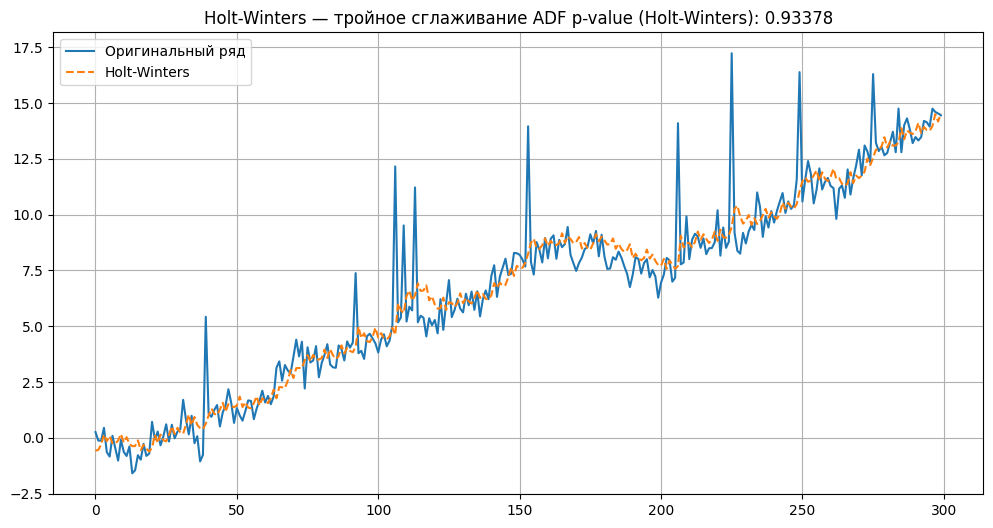

In [58]:
# Holt-Winters (пример с аддитивной сезонностью)
hw_model = ExponentialSmoothing(ts, trend='add', seasonal='add', seasonal_periods=6).fit()
hw_smoothed = hw_model.fittedvalues

adf_hw = adfuller(hw_smoothed)[1]

plt.figure(figsize=(12, 6))
plt.plot(ts, label="Оригинальный ряд")
plt.plot(hw_smoothed, label="Holt-Winters", linestyle='--')
plt.title(f"Holt-Winters — тройное сглаживание ADF p-value (Holt-Winters): {adf_hw:.5f}")
plt.grid(True)
plt.legend()
plt.show()



### Метод 7. Wavelet-декомпозиция

Вейвлет-преобразование разлагает сигнал (временной ряд) на разные уровни частот (детали и тренды) с помощью волновых функций (вейвлетов).

Вейвлет — это коротковременная волновая функция, похожая на «локализованную» синусоиду. В отличие от фурье-преобразования, которое анализирует частоты во всём ряду сразу, вейвлет-преобразование позволяет локализовать и по времени, и по частоте, что особенно полезно для временных рядов с нестационарностью, выбросами, шумами и др.

🔸 Как происходит разложение?
Вейвлет-декомпозиция делает следующее:

✅ Разбивает сигнал на:
- Аппроксимацию (A): низкочастотную часть — тренд, структура.
- Детали (D): высокочастотную часть — шум, резкие изменения.

🔁 На каждом уровне:

- К аппроксимации применяется сглаживающий фильтр.
- К деталям — высокочастотный фильтр.
- Затем результат сэмплируется (downsampling) — уменьшается размер в 2 раза.

📉 Процесс повторяется рекурсивно с аппроксимацией: это и есть уровни (level=1, level=2, ...).

| Вейвлет | Особенности                                                                                                   |
| ------- | ------------------------------------------------------------------------------------------------------------- |
| `haar`  | Самый простой (кусочно-постоянная функция). Быстрый, но грубый.                                               |
| `dbN`   | **Daubechies** — гладкие, хороши для анализа сигнала, `N` – номер (db4 = 4 нуля момента). Часто используется. |
| `symN`  | Симметричные Daubechies — меньше искажения на границах.                                                       |
| `coifN` | Coiflets — очень гладкие, подходят для точных вычислений.                                                     |
| `bior`  | Biorthogonal — можно использовать для точного восстановления сигнала.                                         |

Выбор вейвлета
- haar — если нужен быстрый и простой фильтр (например, убрать шумы на уровне сигнала).
- db4, db6 — более гладкие, популярны для экономических, инженерных данных.
- sym5 — если важна симметрия (например, чтобы избежать смещения на границах).
- coif или bior — если тебе важно высокое качество восстановления сигнала.

✅ Что обнулять:
- coeffs = [cA_N, cD_N, cD_{N-1}, ..., cD_1]
- Обнулять только coeffs[-1] (D1) → мягкое подавление шума.
- Обнулять coeffs[1:] → сильное сглаживание, почти без деталей.
- Обнулять coeffs[0] (аппроксимацию) → полная потеря структуры, почти всегда нежелательно.
📌 Итог:
coeffs[0] — несущая часть сигнала .
coeffs[1], coeffs[2], ... — можно подавлять для устранения шумов и выбросов.

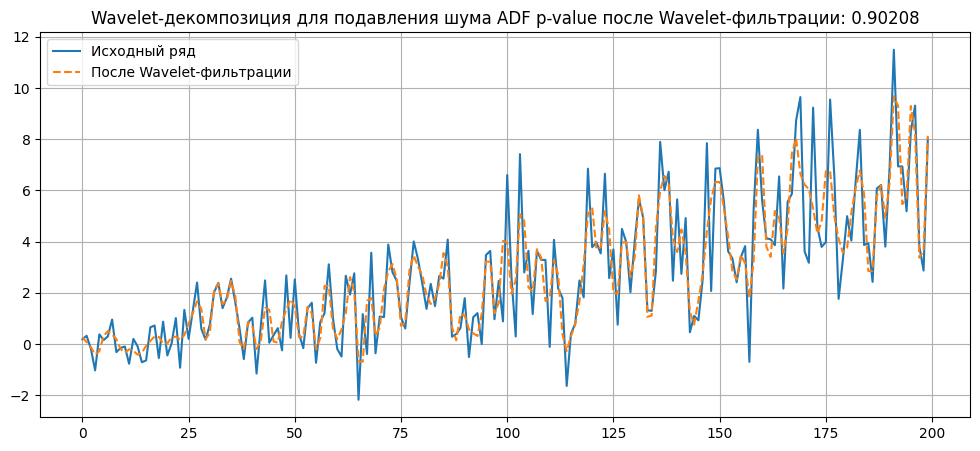

In [66]:
ts = dis_ts.copy()

# Вейвлет-декомпозиция на 1 уровне
wavelet = 'db4'  # или 'haar', 'sym5' и др.
coeffs = pywt.wavedec(ts, wavelet, level=2)

# Обнуляем детали (шум)
coeffs[-1] = np.zeros_like(coeffs[-1])  # убираем  шум

# Реконструкция сигнала (сглаженный ряд)
denoised_ts = pywt.waverec(coeffs, wavelet)

# ADF-тест
adf_wavelet = adfuller(denoised_ts[:len(ts)])[1]

# Визуализация
plt.figure(figsize=(12, 5))
plt.plot(ts, label='Исходный ряд')
plt.plot(denoised_ts, label='После Wavelet-фильтрации', linestyle='--')
plt.title(f'Wavelet-декомпозиция для подавления шума ADF p-value после Wavelet-фильтрации: {adf_wavelet:.5f}')
plt.grid(True)
plt.legend()
plt.show()



### Метод 8. Скользящее среднее (Rolling stats)
Ранее мы применяли скользящее среднее как способ борьбы с трендом, вычитая его из оригинального ряда.
Теперь же используем его как фильтр шума и средство сглаживания без вычитания — просто заменяем текущие значения локальной средней, чтобы:
- снизить выбросы
- уменьшить влияние высокочастотных колебаний
- сделать ряд более "предсказуемым"

💡 Пояснение:
- center=True означает, что среднее значение будет "в центре окна" (а не в конце).
- Чем больше окно, тем сильнее сглаживание, но выше риск потерять локальные особенности.
- Это простейший низкочастотный фильтр, аналогичный moving average в DSP.

| Цель                 | Скользящее среднее эффективно?                           |
| -------------------- | -------------------------------------------------------- |
| Подавление шума      | ✅ Да                                                     |
| Сохранение структуры | ⚠️ Частично (большое окно ≈ потеря особенностей)          |
| Борьба с трендом     | ✅ Если вычитается из исходного                           |
| Масштабирование      | ⚠️ Косвенно помогает, но лучше использовать нормализацию  |


✅ Что мы получаем:
- Чище и более "предсказуемый" ряд — легче анализировать, визуализировать, подбирать модель.
- Немного снижается p-value ADF, но стационарности это гарантировать не может, особенно если тренд или сезонность остались.




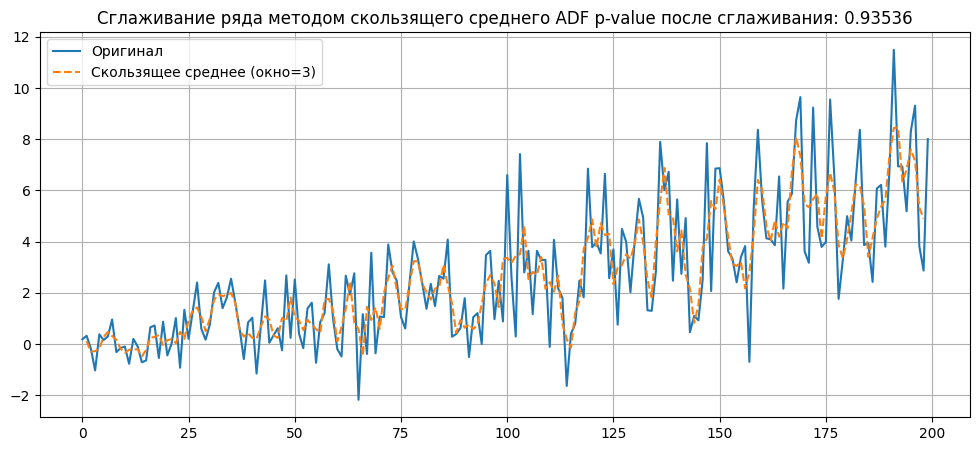

In [72]:
window_size = 3  # Размер окна

rolling_smoothed = ts.rolling(window=window_size, center=True).mean()

pval = adfuller(rolling_smoothed.dropna())[1]

plt.figure(figsize=(12, 5))
plt.plot(ts, label='Оригинал')
plt.plot(rolling_smoothed, label=f'Скользящее среднее (окно={window_size})', linestyle='--')
plt.legend()
plt.title(f'Сглаживание ряда методом скользящего среднего ADF p-value после сглаживания: {pval:.5f}')
plt.grid()
plt.show()


### Метод 9. PCA (Principal Component Analysis)
PCA обычно работает с многомерными данными, но для одномерного временного ряда его можно применить, используя метод вложенных окон (embedding), превращая временной ряд в матрицу из перекрывающихся окон. Это позволяет:
извлечь основные тренды;
убрать высокочастотный шум;
получить сглаженный ряд, восстанавливая его из 1–2 главных компонент.

Допустим, у нас есть ряд ts длиной n = 200. Делаем следующее:

window_size = 10
X = sliding_window_view(ts, window_size)
Теперь X — это матрица с размером (n - window_size + 1, window_size), в которой каждая строка — окно значений из ряда.

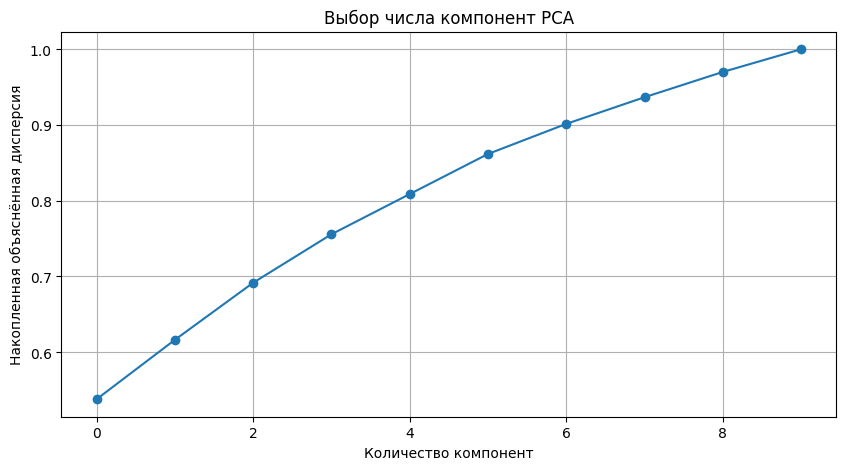

In [77]:
window_size = 10
X = sliding_window_view(ts, window_size)

pca_full = PCA()
pca_full.fit(X)

explained_variance_ratio = pca_full.explained_variance_ratio_

plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(explained_variance_ratio), marker='o')
plt.xlabel('Количество компонент')
plt.ylabel('Накопленная объяснённая дисперсия')
plt.title('Выбор числа компонент PCA')
plt.grid(True)
plt.show()

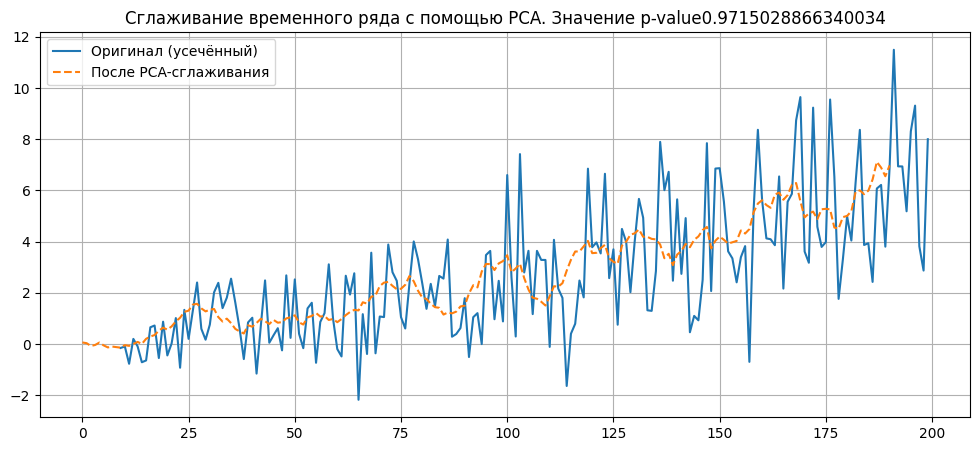

In [80]:
pca = PCA(n_components=7)  # Оставим только главную компоненту
X_pca = pca.fit_transform(X)
X_reconstructed = pca.inverse_transform(X_pca)

smoothed_pca = X_reconstructed.mean(axis=1)

pcaval = adfuller(smoothed_pca)[1]

plt.figure(figsize=(12, 5))
plt.plot(ts[window_size - 1:], label='Оригинал (усечённый)')
plt.plot(smoothed_pca, label='После PCA-сглаживания', linestyle='--')
plt.legend()
plt.title(f'Сглаживание временного ряда с помощью PCA. Значение p-value{pcaval}')
plt.grid(True)
plt.show()


### Метод 10.  SVD (сингулярное разложение) 
SVD — это разложение матрицы 𝑋 на три компоненты: 𝑋=𝑈⋅Σ⋅𝑉𝑇

- U — матрица левых сингулярных векторов (шаблоны);
- Σ — диагональная матрица с сингулярными числами (мощность компонентов);
- 𝑉𝑇 — матрица правых сингулярных векторов (коэффициенты).

🔹 Основная идея: убрать малые компоненты из Σ а потом восстановить матрицу. Это сглаживает шум, потому что шумы имеют малую энергию (низкие сигмы).

Подготовка временного ряда для SVD: вложение в траекторию
Чтобы применить SVD к ряду, нужно его превратить в матрицу. Обычно делают встраивание в траекторию (trajectory embedding):

Пример: если есть ряд длины 100 и окно 10, получится матрица  X размером примерно (100−10+1)×10

🔍 Преимущества:
Убирает высокочастотный шум.
Не требует знания тренда или сезонности.
Хорошо работает на синусоидах, периодичностях, экономических рядах.

⚠️ Недостатки:
Нужно выбрать окно и количество компонент.
Метод затратен по вычислениям.
Не работает на коротких рядах.



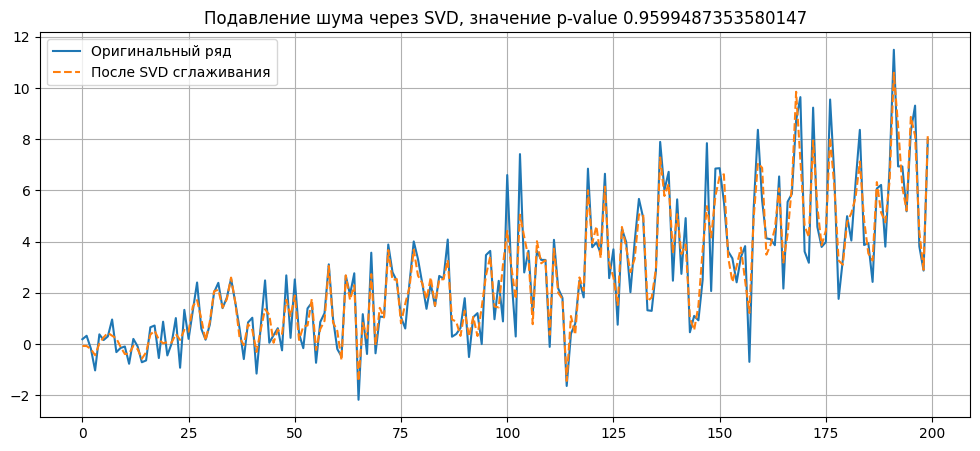

In [85]:
def embed_series(ts, window):
    """Преобразуем ряд в траекторную матрицу"""
    N = len(ts)
    return np.column_stack([ts[i:N - window + i + 1] for i in range(window)])

# Встроим ряд в матрицу
window = 20
# X = embed_series(ts.values, window)
X = sliding_window_view(ts, window_shape=window_size).copy()


# Применим SVD
U, S, VT = np.linalg.svd(X, full_matrices=False)

# Обнулим мелкие сингулярные значения (оставим 6 компонент)
k = 6
S_denoised = np.zeros_like(S)
S_denoised[:k] = S[:k]

# Восстановим матрицу
X_denoised = U @ np.diag(S_denoised) @ VT

# Обратно в ряд (берём среднее по диагоналям — Hankelization)
def diagonal_averaging(X):
    n_rows, n_cols = X.shape
    N = n_rows + n_cols - 1
    result = np.zeros(N)
    count = np.zeros(N)

    for i in range(n_rows):
        for j in range(n_cols):
            result[i + j] += X[i, j]
            count[i + j] += 1
    return result / count

ts_denoised = diagonal_averaging(X_denoised)

svdval = adfuller(ts_denoised)[1]

# Визуализация
plt.figure(figsize=(12, 5))
plt.plot(ts, label='Оригинальный ряд')
plt.plot(ts_denoised, label='После SVD сглаживания', linestyle='--')
plt.legend()
plt.title(f'Подавление шума через SVD, значение p-value {svdval}')
plt.grid(True)
plt.show()


| Характеристика                                | PCA                                            | SVD                                 |
| --------------------------------------------- | ---------------------------------------------- | ----------------------------------- |
| Основан на                                    | Ковариационной матрице                         | Непосредственно на исходной матрице |
| Требует центрирования                         | Да                                             | Нет обязательно                     |
| Чувствителен к масштабам                      | Да                                             | Меньше                              |
| Универсальность                               | Не работает на не-квадратных матрицах напрямую | Да                                  |
| Вычислительная стоимость                      | Быстрее                                        | Немного дороже, но стабильнее       |
| Подходит для временных рядов (через вложение) | Да, но не оптимально                           | Лучше всего                         |

PCA и SVD оба хороши для подавления шума, но:
SVD = более универсальный, прямой и устойчивый подход.
PCA = более экономный, когда ты уверен, что данные хорошо центрированы и тебе нужно интерпретировать компоненты.

| Свойство                      | `sliding_window_view`                                | Ручной `for`-цикл или `np.stack` |
| ----------------------------- | ---------------------------------------------------- | -------------------------------- |
| Возвращает                    | `view` (ленивый доступ к данным)                     | `ndarray` (копия данных)         |
| Требует `copy()`              | Да (иначе SVD/восстановление могут быть нестабильны) | Нет                              |
| Производительность            | Очень быстрая (без копирования)                      | Медленнее (делает копии)         |
| Применим к многомерным данным | Да                                                   | Требует дополнительных обработок |


Когда применять SVD / PCA:
- Цель: уменьшить размерность и/или удалить шум в "чистом" ряду, где уже удалены тренды и сезонность.

📌 Перед предсказанием, особенно при обучении моделей.
- Требует предварительной стационарности или нормализации.
- Работает на принципе глобальной структуры дисперсии.
- Плохо работает на "сыром" сигнале — тренды, сезонность искажают компоненты.

🔧 Пример:
Выделили тренд и сезонность (например, x_t = Trend + Seasonality + Noise), и вот Noise  обрабатываем через PCA/SVD, чтобы получить гладкий сигнал.

### Метод 11. EMD (Empirical Mode Decomposition) 
EMD разлагает временной ряд на сумму компонентов, называемых IMF (Intrinsic Mode Functions) + остаток:
- ts=IMF1+IMF2+⋯+IMF𝑛+residual 
- IMF1 — высокочастотный шум (наиболее колеблющаяся часть).
- Последующие IMF всё более сглаженные.
- Последний компонент — остаточный тренд.

В EMD количество IMF-компонент определяется в процессе итеративного извлечения осциллирующих сигналов, пока в остатке не останется:
- либо монотонная часть (тренд),
- либо сигнал без экстремумов (условие остановки).

То есть:
- EMD не требует заранее указывать число компонент (в отличие от PCA/SVD).
- Он автоматически разбивает ряд на нужное количество IMF-компонент в зависимости от количества максимумов и минимумов.

📐 Условие IMF:
- Компонента считается IMF, если:
- Количество нулевых пересечений ≈ количество экстремумов.
- Среднее значение между локальными максимумами и минимумами ≈ 0.

🔁 Алгоритм сжатый:
- Находятся локальные максимумы и минимумы.
- Строятся огибающие через сплайны.
- Вычисляется средняя огибающая m(t).
- Вычисляется h(t) = x(t) - m(t) — если удовлетворяет условиям IMF → сохраняем как IMF₁.
- Остаток r(t) = x(t) - IMF₁ становится новым входом.
- Повторяем, пока остаток не станет неосциллирующим.

🔢 Сколько компонентов бывает?
- Обычно 5–10 IMF вполне достаточно.
Их число зависит от:
- длины ряда,
- количества и глубины осцилляций,
- уровня шума и сложности сигнала.
  
| Характеристика     | EMD                       | PCA/SVD                               |
| ------------------ | ------------------------- | ------------------------------------- |
| Кол-во компонент   | Определяется *алгоритмом* | Нужно задавать/отбирать по доле       |
| Основной принцип   | Локальные частоты         | Глобальная дисперсия                  |
| Применимость       | Нелинейные, нестац. ряды  | Линейные, желательно стац. ряды       |
| Частотное значение | Да (IMF ≈ частоты)        | Нет (главные компоненты по дисперсии) |

✅ Когда применять EMD (Empirical Mode Decomposition):
Цель: "разобрать" сигнал на осциллирующие компоненты (IMF), даже если он еще не обработан.

📌 Можно применять на любом сигнале, даже с трендом/сезонностью.
- Автоматически отделяет высокочастотный шум от низкочастотных колебаний.
- Подходит для нестационарных и нелинейных временных рядов.
- Часто используется как первый шаг перед анализом тренда или даже перед STL/seasonal decomposition.
- 🔧 Пример:
-Нужно выделить тренд из "грязного" временного ряда → удаляем первые IMF (высокочастотный шум), остаток — более гладкий и пригоден для дальнейшего анализа.


| Свойство                    | PCA / SVD         | EMD                             |
| --------------------------- | ----------------- | ------------------------------- |
| Применение                  | После очистки     | Можно на "сыром" сигнале        |
| Удаление шумов              | Да                | Да                              |
| Выделение тренда/сезонности | Нет               | Частично возможно через остаток |
| Зависит от ков. матрицы     | Да (особенно PCA) | Нет                             |
| Поддерживает нелинейность   | Нет               | Да                              |
| Частотное разложение        | Нет               | Да (приближённо)                |


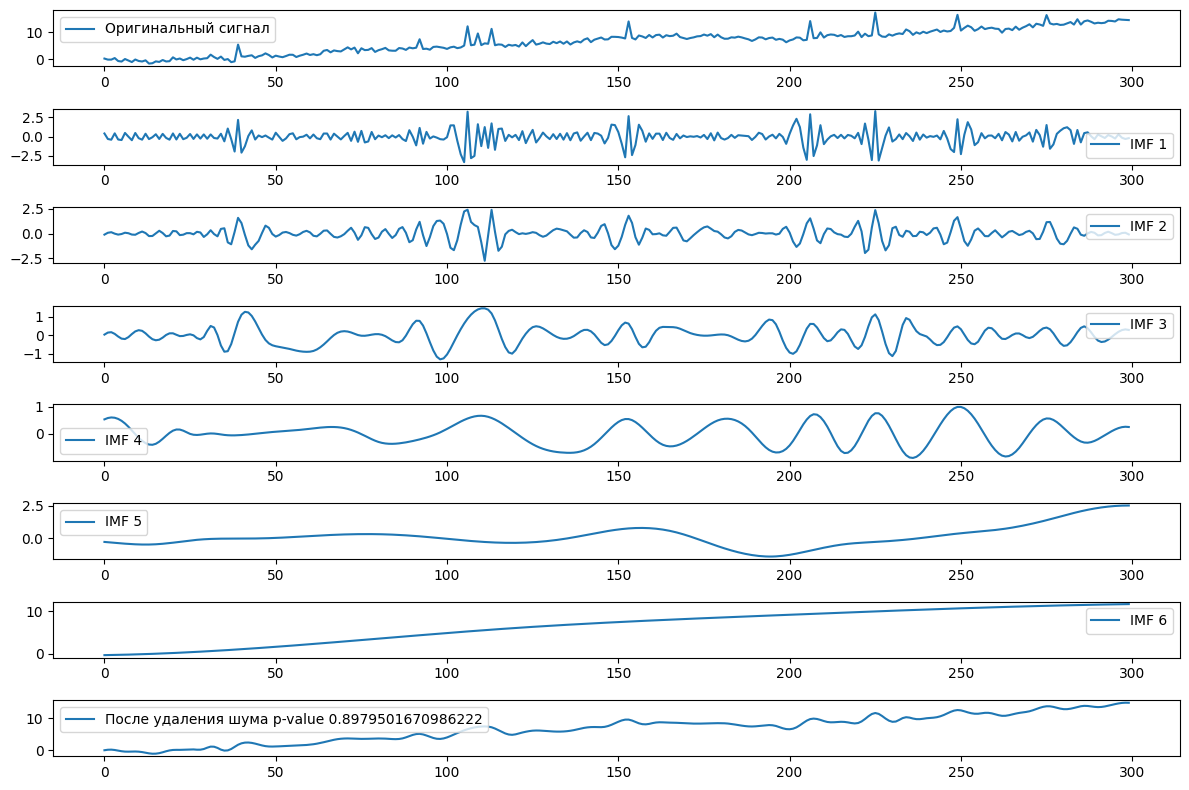

In [91]:
# EMD
emd = EMD()
imfs = emd(raw_series)

# Визуализация
plt.figure(figsize=(12, 8))
plt.subplot(len(imfs)+2, 1, 1)
plt.plot(raw_series, label='Оригинальный сигнал')
plt.legend()

# Все IMFs
for i, imf in enumerate(imfs):
    plt.subplot(len(imfs)+2, 1, i+2)
    plt.plot(imf, label=f'IMF {i+1}')
    plt.legend()

# Восстановленный сигнал без первых IMF (например, IMF1 — шум)
denoised = np.sum(imfs[2:], axis=0)
EMDval = adfuller(denoised)[1]
plt.subplot(len(imfs)+2, 1, len(imfs)+2)
plt.plot(denoised, label=f'После удаления шума p-value {EMDval}')
plt.legend()
plt.tight_layout()
plt.show()


### Метод 12. Бинаризация временного ряда

Что это?
- Превращение непрерывного ряда в дискретный с помощью порога (threshold), например:
- Превратить значения выше среднего в 1, ниже — в 0.
- Или использовать несколько уровней (мультирская бинаризация).
    
Для чего?
- Упростить данные, выделить основные паттерны (например, рост/падение).
- Сгладить шум, отсеять мелкие колебания.

Бинаризация хороша для упрощения и выделения ключевых изменений (рост/падение, сигналы).

Мультиуровневая бинаризация (multi-threshold binarization)
- Вместо одного порога можно взять несколько порогов и разбить данные на несколько уровней. Например:
- Данные меньше первого порога — уровень 0
- Между первым и вторым порогом — уровень 1
- Между вторым и третьим — уровень 2
- И т.д.

Это позволяет кодировать ряд как категориальный с несколькими состояниями, а не просто 0/1.
Мультиуровневая бинаризация — позволяет разбить ряд на категории по нескольким уровням, полезна для упрощения с сохранением детализации.


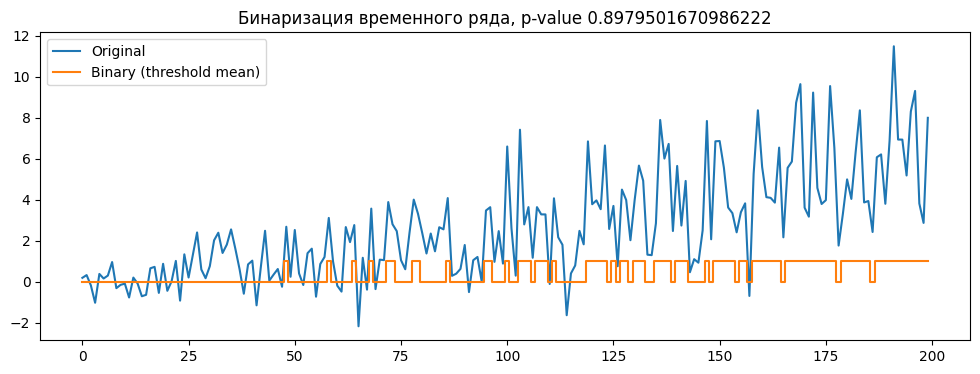

In [92]:
# Порог — среднее значение ряда
threshold = ts.mean()

# Бинаризация
binary_ts = (ts > threshold).astype(int)
binval = adfuller(denoised)[1]

plt.figure(figsize=(12,4))
plt.plot(ts, label='Original')
plt.step(ts.index, binary_ts, label='Binary (threshold mean)', where='mid')
plt.legend()
plt.title(f"Бинаризация временного ряда, p-value {binval}")
plt.show()

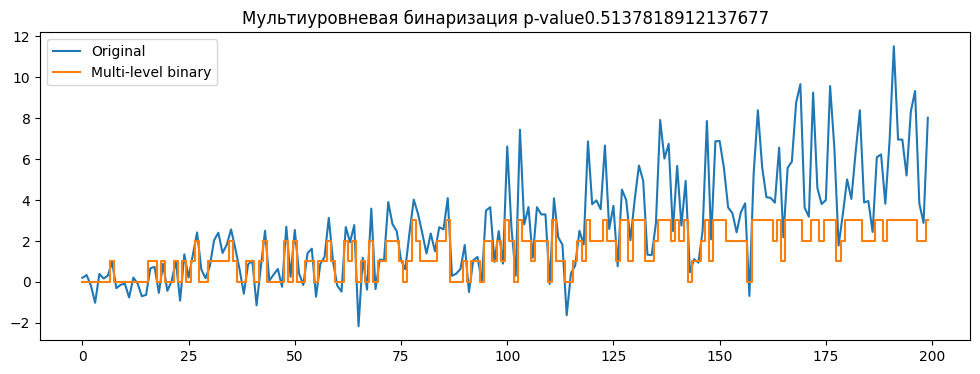

In [95]:
# Выбираем пороги — например, квартили
thresholds = ts.quantile([0.25, 0.5, 0.75]).values

def multi_level_binarize(x, thresholds):
    if x < thresholds[0]:
        return 0
    elif x < thresholds[1]:
        return 1
    elif x < thresholds[2]:
        return 2
    else:
        return 3

multi_binary = ts.apply(lambda x: multi_level_binarize(x, thresholds))

multi_binaryval = adfuller(multi_binary)[1]

plt.figure(figsize=(12, 4))
plt.plot(ts, label='Original')
plt.step(ts.index, multi_binary, label='Multi-level binary', where='mid')
plt.legend()
plt.title(f'Мультиуровневая бинаризация p-value{multi_binaryval}')
plt.show()

### Метод 13.Кластеризация

Что это?
- Разбиение точек ряда (или сегментов ряда) на группы (кластеры) с похожими признаками.

Зачем?
- Выделить похожие состояния, паттерны или фазы во временном ряде.
- Упростить анализ, обнаружить структуру.

Как кластеризовать временной ряд:
- Можно разбить ряд на окна фиксированной длины.
- Для каждого окна посчитать признаки (среднее, дисперсия, тренд и т.д.).
- Кластеризовать эти окна с помощью алгоритмов, например KMeans.

Кластеризация помогает находить повторяющиеся паттерны или сегменты с похожим поведением, особенно в сложных данных.

Кластеризация с расширенными признаками
- Вместо двух простых признаков (среднее и стандартное отклонение) можно добавить:
- Медиану
- Максимум и минимум
- Коэффициент асимметрии (skewness)
- Куртозис (kurtosis)
- Автокорреляция
- Тренд (например, коэффициент наклона линейной регрессии на окне)
- Энергия сигнала (сумма квадратов значений)
- И др.

Это даст более глубокое представление о каждом окне и улучшит качество кластеризации.
Кластеризация с расширенными признаками — даёт возможность более точно разделять разные «типы» поведения в ряде, учитывая не только среднее и дисперсию, но и форму распределения, тренды и др.

Кластеризация, особенно с расширенным набором признаков (включая статистики формы распределения, тренды, автокорреляции и др.), может помочь выделить и выявить сложные паттерны в данных, в том числе:
- Цикличности и сезонность с разной частотой и амплитудой
- Периоды с разным уровнем шума и нестабильности
- Переходы между разными режимами поведения временного ряда (например, разные «состояния» рынка или процесса)
- Аномалии и редкие события, которые могут формировать отдельные кластеры
- Потому что кластеризация группирует похожие по форме и поведению сегменты ряда, выделяя закономерности, которые могут не быть очевидными при простом визуальном или статистическом анализе.

Ключевое:
Качество выявления таких циклов сильно зависит от того, какие признаки используются для кластеризации — чем информативнее и разнообразнее признаки, тем более точные и интерпретируемые кластеры.

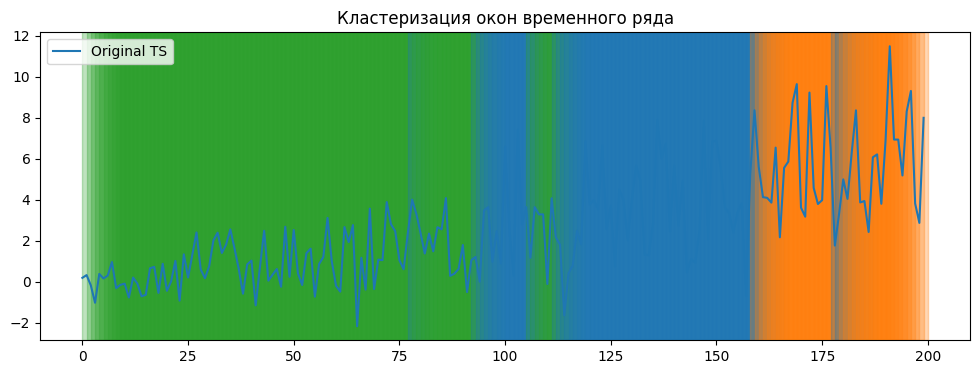

In [94]:
window_size = 10
n_clusters = 3

# Создадим признаки — среднее и стандартное отклонение в окнах
def extract_features(ts, window_size):
    features = []
    for i in range(len(ts) - window_size + 1):
        window = ts[i:i+window_size]
        mean = window.mean()
        std = window.std()
        features.append([mean, std])
    return np.array(features)

features = extract_features(ts, window_size)

# Кластеризация
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(features)

# Визуализируем кластеры по временному ряду (сдвинем по длине окон)
plt.figure(figsize=(12,4))
plt.plot(ts, label='Original TS')
for i, c in enumerate(clusters):
    plt.axvspan(i, i + window_size, color=f'C{c}', alpha=0.3)
plt.title('Кластеризация окон временного ряда')
plt.legend()
plt.show()


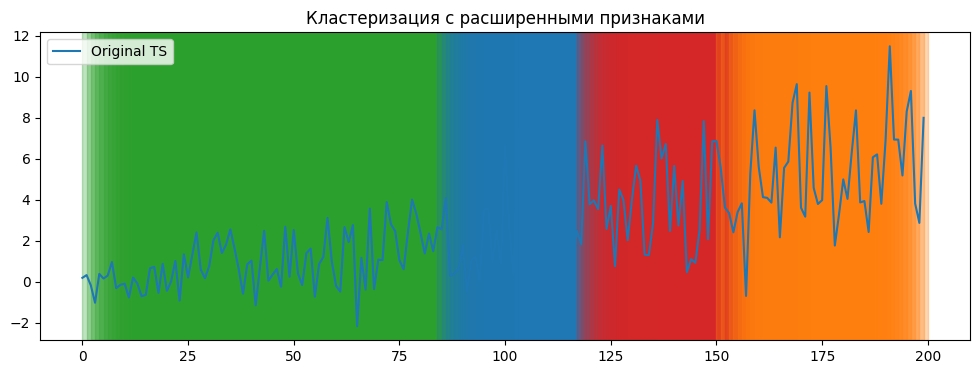

In [97]:
def extract_features_extended(ts, window_size):
    features = []
    for i in range(len(ts) - window_size + 1):
        window = ts[i:i+window_size]
        
        mean = window.mean()
        median = window.median()
        std = window.std()
        minimum = window.min()
        maximum = window.max()
        skewness = skew(window)
        kurt = kurtosis(window)
        energy = np.sum(window**2)
        
        # Тренд (наклон линейной регрессии)
        X = np.arange(window_size).reshape(-1, 1)
        model = LinearRegression().fit(X, window.values)
        trend = model.coef_[0]
        
        features.append([mean, median, std, minimum, maximum, skewness, kurt, energy, trend])
    return np.array(features)

window_size = 20

features = extract_features_extended(ts, window_size)

# Кластеризация
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(features)

plt.figure(figsize=(12,4))
plt.plot(ts, label='Original TS')
for i, c in enumerate(clusters):
    plt.axvspan(i, i + window_size, color=f'C{c}', alpha=0.3)
plt.title('Кластеризация с расширенными признаками')
plt.legend()
plt.show()

### Метод 14. Kalman filter	

Kalman filter (Калмановский фильтр) — это рекурсивный алгоритм оценки состояния динамической системы из серии наблюдений, которые содержат шумы и ошибки. В простом виде он:
- Предсказывает новое состояние на основе предыдущего
- Обновляет предсказание с учётом нового наблюдения
- Автоматически балансирует доверие между моделью и наблюдениями
- Это очень эффективно для «шумных» данных, где нужно получить сглаженную оценку реального сигнала.
- 
Как работает Kalman filter для временного ряда?
Модель состояния: Считаем, что ряд описывается скрытым (неизмеримым) состоянием, которое изменяется по простой модели (например, случайное блуждание).
Наблюдения: Мы видим только «зашумленные» данные, которые зависят от этого скрытого состояния.
Фильтр: Итеративно обновляет оценку скрытого состояния, уменьшая шум.

Ключевые параметры Kalman filter:
transition_matrices — как состояние меняется со временем (обычно 1 для простого случайного блуждания)
observation_matrices — как наблюдения связаны с состоянием (1, если напрямую)
observation_covariance — шум измерения (чем больше, тем больше доверия модели)
transition_covariance — шум модели (чем больше, тем модель более подвижна)

Итог:
Kalman filter — отличный метод для онлайн-фильтрации шума и получения сглаженного ряда
Работает рекурсивно, может быть встроен в реальное время
Можно настроить под онкретный тип данных и шума
Подходит как для трендов, так и для случайных процессов



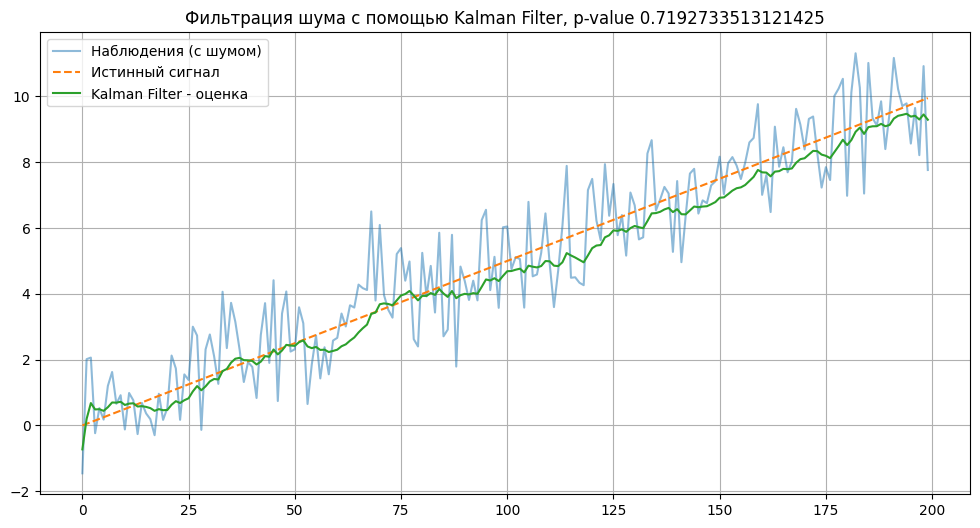

In [101]:
# Создаём шумный временной ряд (с трендом + шум)
n = 200
time = np.arange(n)
true_signal = 0.05 * time  # линейный тренд
noise = np.random.normal(0, 1, size=n)
observations = true_signal + noise


# Инициализация фильтра Калмана
kf = KalmanFilter(transition_matrices=[1], observation_matrices=[1],
                  initial_state_mean=0, initial_state_covariance=1,
                  observation_covariance=1, transition_covariance=0.01)

# Применяем фильтр
state_means, state_covariances = kf.filter(observations)
kalman_binaryval = adfuller(state_means.flatten())[1]

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(time, observations, label='Наблюдения (с шумом)', alpha=0.5)
plt.plot(time, true_signal, label='Истинный сигнал', linestyle='--')
plt.plot(time, state_means.flatten(), label='Kalman Filter - оценка')
plt.legend()
plt.title(f'Фильтрация шума с помощью Kalman Filter, p-value {kalman_binaryval}')
plt.grid(True)
plt.show()

# Методы предектирования (Arima/13ARIMA/Holt/LSTM)
| Характеристика          | ARIMA                                                                | Holt (и ETS-модели)                                                 |
| ----------------------- | -------------------------------------------------------------------- | ------------------------------------------------------------------- |
| **Тип модели**          | Статистическая модель на основе авторегрессии и скользящего среднего | Метод экспоненциального сглаживания                                 |
| **Работа с трендом**    | Через дифференцирование (например, `d=1`)                            | Явно моделирует тренд (линейный, экспоненциальный и др.)            |
| **Сезонность**          | SARIMA/ARIMA(X) — вручную добавляется                                | ETS — поддерживает сезонность                                       |
| **Входные параметры**   | `p`, `d`, `q` (ARIMA), дополнительно `P`, `D`, `Q`, `s` для SARIMA   | Уровень, тренд, сезонность (и их тип: аддитивный/мультипликативный) |
| **Тип данных**          | Требует стационарного ряда (или делает стационарным через `d`)       | Может работать с нестационарными рядами                             |
| **Механизм прогноза**   | Статистическая регрессия на лаги и ошибки                            | Сглаженные веса недавних наблюдений                                 |
| **Типичная реализация** | `ARIMA(p,d,q)` в `statsmodels`, `auto_arima`                         | `Holt`, `ExponentialSmoothing` в `statsmodels`                      |


## Arima
🧠 Как ARIMA работает внутри?
ARIMA состоит из:
AR (авторегрессия): модель использует прошлые значения ряда.
I (интегрирование): дифференцирует ряд, чтобы убрать тренд.
MA (скользящее среднее): модель использует ошибки прошлых предсказаний.

ARIMA не делает экспоненциальное сглаживание сам по себе. Но в принципе, оба метода можно рассматривать как частные случаи линейных временных моделей, просто они подходят к задаче по-разному.

📌 Пример: где что применяют
ARIMA хороша, если:
Ряд может быть сделан стационарным.
Наблюдается автокорреляция.
Важен контроль над структурой модели.

Holt/ETS хороши, если:

Ряд нестационарный, и xочется явно учитывать тренд/сезонность.
Нужно быстро получить предсказание без глубокого анализа лагов и ошибок.

Модель ARIMA (AutoRegressive Integrated Moving Average) используется для моделирования и прогнозирования временных рядов, особенно нестационарных (т.е. среднее/дисперсия меняются со временем).

Обозначение ARIMA(p, d, q):
- p — число авторегрессий (AR): модель использует предыдущие значения (y[t-1], y[t-2], ...) для предсказания.
- d — порядок интегрирования (разностей): сколько раз нужно взять разность, чтобы ряд стал стационарным.
- q — число скользящих средних (MA): модель использует предыдущие ошибки предсказаний (e[t-1], e[t-2], ...).

2. Зачем нужно восстановление ряда (typ='levels')
- Если  указываешь d=1, то ARIMA работает не с самим рядом, а с его первой разностью, т.е.:
𝑦𝑡′=𝑦𝑡−𝑦𝑡−1
- Когда  делаешь предсказание, оно будет в разностной форме. А если хочешь предсказать исходные значения, поэтому используешь typ="levels" — это говорит модели: восстанови предсказания к оригинальному масштабу (y_t), а не к разностям (Δy_t).
- Если typ='linear' (по умолчанию), то получишм предсказания на дифференцированном ряду.

3. Что выводит auto_arima()
- auto_arima делает перебор моделей ARIMA(p,d,q) с разными параметрами и выбирает ту, у которой наименьший AIC.

4. Что такое AIC?
- AIC (Akaike Information Criterion) — метрика качества модели:
- чем меньше AIC, тем лучше модель (считается балансом между качеством и сложностью).
- AIC = -2 * логарифм правдоподобия + 2 * число параметров


5. Что показывает summary()
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(4, 1, 0)   Log Likelihood                -244.844
AIC                            501.689
BIC                            517.260
HQIC                           507.989

- Dep. Variable: переменная, которую мы моделируем
- SARIMAX: в основе ARIMA лежит модель SARIMAX из statsmodels
- AIC, BIC, HQIC: метрики сравнения моделей
- coef: коэффициенты модели (intercept, AR1, AR2, …)
- sigma²: дисперсия остатков
- Ljung-Box: проверка автокорреляции остатков
- Jarque-Bera: проверка на нормальность остатков
- H: тест на гетероскедастичность



### Как ARIMA делает предсказание (восстановление из дифференцированного ряда) (предектирование )

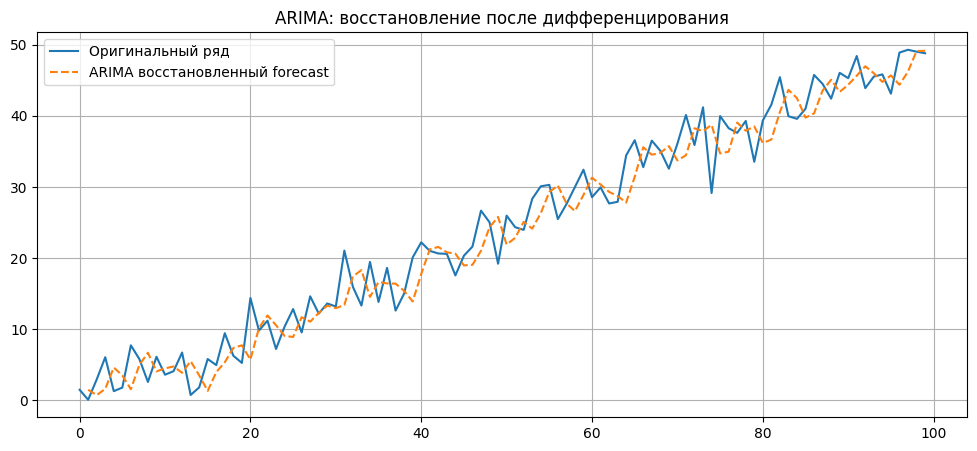

In [13]:
# ARIMA с дифференцированием
model = ARIMA(time_series, order=(1, 1, 0))
fitted = model.fit()

# Предсказание на тех же точках (in-sample)
forecast = fitted.predict(start=1, end=99, typ="levels")  # 'levels' → восстановленный ряд

# Визуализация
plt.figure(figsize=(12, 5))
plt.plot(time_series, label='Оригинальный ряд')
plt.plot(forecast, label='ARIMA восстановленный forecast', linestyle='--')
plt.legend()
plt.title("ARIMA: восстановление после дифференцирования")
plt.grid(True)
plt.show()

### Автоматический подбор p, d, q с pmdarima.auto_arima

In [4]:
# Подавляем только FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

# auto_arima сам определит p,d,q и покажет AIC
stepwise_model = auto_arima(time_series,
                            start_p=0, start_q=0,
                            max_p=5, max_q=5,
                            seasonal=False,
                            d=None,  # позволяет подобрать d автоматически
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

print(stepwise_model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=553.903, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=529.003, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=553.386, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=518.891, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=515.244, Time=0.04 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=501.689, Time=0.05 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=502.325, Time=0.06 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=521.697, Time=0.03 sec

Best model:  ARIMA(4,1,0)(0,0,0)[0] intercept
Total fit time: 1.075 seconds
                               SARIMAX Results                                
Dep. Variable:                      y

In [3]:
# Задаем диапазон для p, d, q
p_range = range(0, 6)
d_range = range(0, 3)  # до второй разности обычно достаточно
q_range = range(0, 6)

# Генерируем все возможные комбинации (p, d, q)
pdq = list(itertools.product(p_range, d_range, q_range))

# Храним результаты
results = []
best_aic = np.inf
best_order = None
best_model = None

# Подавляем предупреждения (о ненахождении корней и пр.)
warnings.filterwarnings("ignore")

for order in pdq:
    try:
        model = ARIMA(time_series, order=order)
        fitted = model.fit()
        aic = fitted.aic
        results.append((order, aic))
        
        if aic < best_aic:
            best_aic = aic
            best_order = order
            best_model = fitted
    except:
        continue

# Сортировка моделей по AIC
results.sort(key=lambda x: x[1])

print("Топ-5 моделей по AIC:")
for order, aic in results[:5]:
    print(f"ARIMA{order} — AIC: {aic:.2f}")

print("\nЛучшая модель:")
print(f"ARIMA{best_order} — AIC: {best_aic:.2f}")
print(best_model.summary())

Топ-5 моделей по AIC:
ARIMA(0, 2, 2) — AIC: 496.52
ARIMA(2, 2, 4) — AIC: 497.47
ARIMA(0, 2, 3) — AIC: 498.49
ARIMA(1, 2, 2) — AIC: 498.49
ARIMA(1, 2, 3) — AIC: 498.82

Лучшая модель:
ARIMA(0, 2, 2) — AIC: 496.52
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:                 ARIMA(0, 2, 2)   Log Likelihood                -245.259
Date:                Wed, 04 Jun 2025   AIC                            496.518
Time:                        11:49:50   BIC                            504.272
Sample:                             0   HQIC                           499.654
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

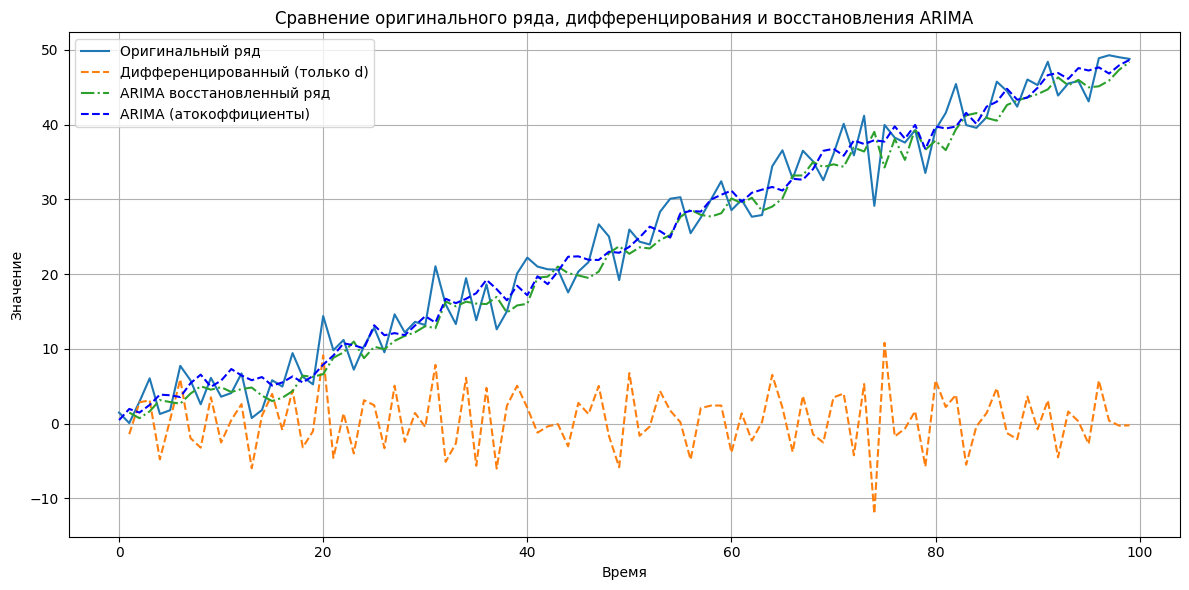

In [8]:
# Дифференцирование
time = np.arange(100)
diff_series = np.diff(time_series)

# Обучим ARIMA с d=1 (автоматически устраняет тренд)
model = ARIMA(time_series, order=(2, 1, 2))
fitted = model.fit()

# Восстановленный in-sample прогноз (тип levels)
restored = fitted.predict(start=1, end=99, typ='levels')


# Обучим ARIMA с учетмоп оказателей
fitted_arima = stepwise_model.fit(time_series)
restored_arima = fitted_arima.predict_in_sample()

# Построим графики
plt.figure(figsize=(12, 6))
plt.plot(time, time_series, label='Оригинальный ряд')
plt.plot(time[1:], diff_series, label='Дифференцированный (только d)', linestyle='--')
plt.plot(time[1:], restored, label='ARIMA восстановленный ряд', linestyle='-.')
plt.plot(restored_arima, label="ARIMA (атокоффициенты)", linestyle="--", color="blue")
plt.title('Сравнение оригинального ряда, дифференцирования и восстановления ARIMA')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

На графике:
- 🔵 Оригинальный ряд — с чётко выраженным трендом.
- 🟠 Дифференцированный ряд — без тренда, колеблется около нуля.
- 🟢 Восстановленный ARIMA-прогноз — приближается к исходному ряду, восстанавливая уровень из предсказанных разностей.

🔍 Как видно:
- ARIMA сама устраняет тренд (через d=1),
- прогнозирует разности,
- и возвращает значения в исходную шкалу с помощью typ='levels'.

### Совсем ручная ARIMA(т.е она но кодом)

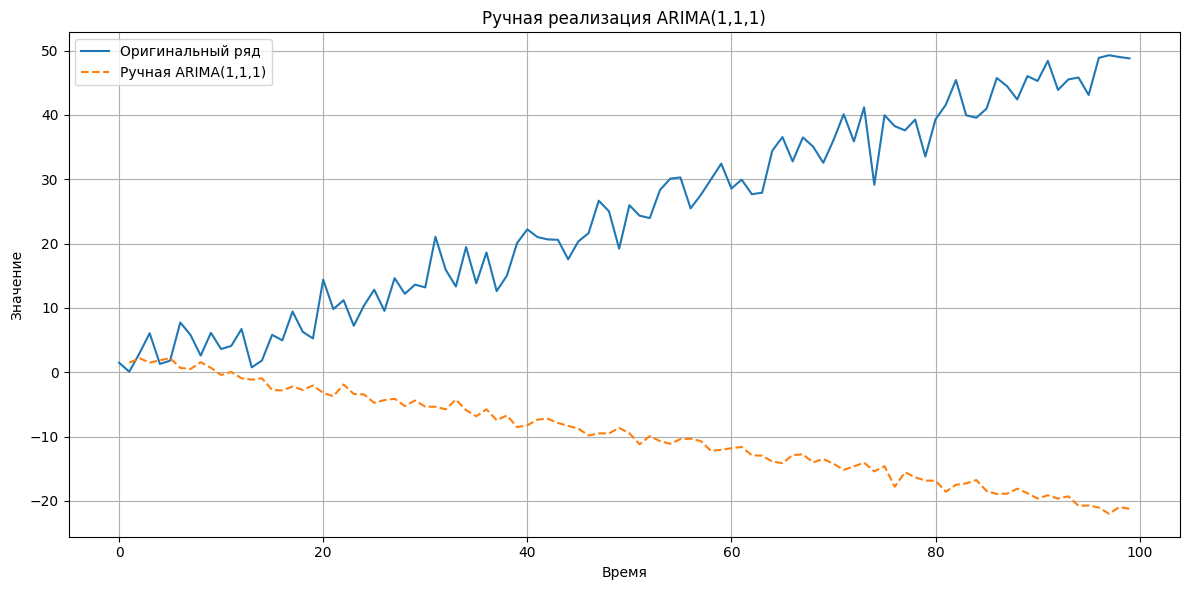

In [26]:
# Шаг 1: Дифференцирование
diff_series = np.diff(time_series)  # len = n - 1

# Подготовка данных для AR(1) + MA(1)
X_ar = diff_series[:-1].reshape(-1, 1)           # lagged values (AR)
y_target = diff_series[1:]                       # текущие значения
errors = diff_series[1:] - X_ar.flatten()        # приблизительные "ошибки", пока без MA

# Обучаем простую линейную модель AR(1)
model_ar = LinearRegression()
model_ar.fit(X_ar, y_target)

# Получаем предсказания AR
ar_pred = model_ar.predict(X_ar)

# Эмуляция MA(1): добавим ошибку предыдущего предсказания (приблизительно)
residuals = y_target - ar_pred
ma_component = np.roll(residuals, 1)
ma_component[0] = 0  # первая ошибка неизвестна

# Простая оценка модели ARIMA(1,1,1)
phi = model_ar.coef_[0]
theta = 0.5  # зададим MA коэффициент вручную
diff_pred = phi * X_ar.flatten() + theta * ma_component

# Восстановление в levels
y_restored = [time_series[0]]  # начальное значение
for dp in diff_pred:
    y_restored.append(y_restored[-1] + dp)
y_restored = np.array(y_restored)

# Построим график
plt.figure(figsize=(12, 6))
plt.plot(time, time_series, label='Оригинальный ряд')
plt.plot(time[1:], y_restored, label='Ручная ARIMA(1,1,1)', linestyle='--')
plt.title('Ручная реализация ARIMA(1,1,1)')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

На графике:
- Синяя линия — оригинальный временной ряд.
- Оранжевая пунктирная линия — ручная реализация ARIMA(1,1,1).

💡 Что мы сделали вручную:
- Вычислили разности (d=1),
- обучили линейную модель на предыдущих разностях (AR(1)),
- добавили приближенную MA-компоненту,
- восстановили предсказанный ряд в исходную шкалу.

реализация ARIMA(2,1,2)

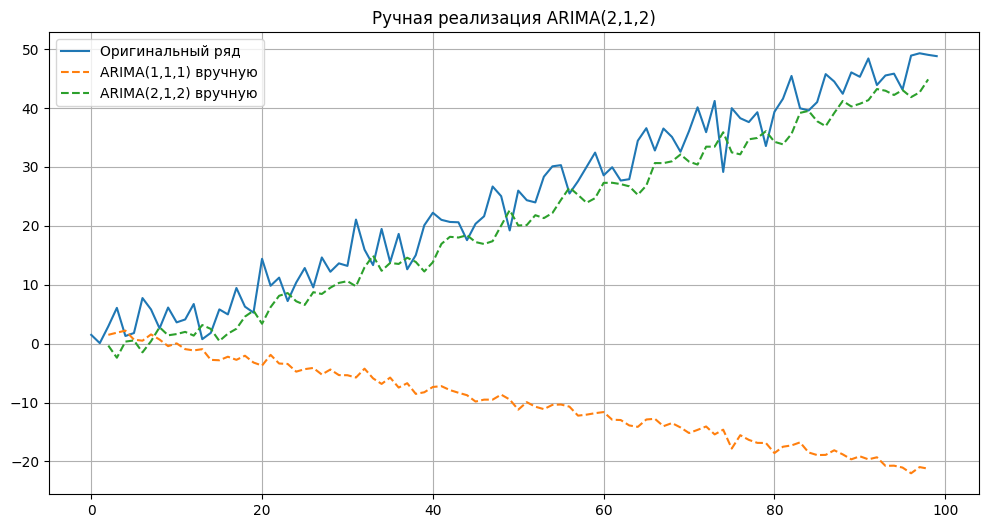

In [27]:

# 1. Дифференцируем (d=1)
diff_series = np.diff(time_series)  # len = N - 1

# 2. Подготовка лагов для AR(2)
X_ar_1 = diff_series[1:-1]   # y[t-1]
X_ar_2 = diff_series[:-2]    # y[t-2]
X_ar = np.column_stack([X_ar_1, X_ar_2])
y_target = diff_series[2:]   # y[t]

# 3. Обучаем модель AR(2)
model_ar2 = LinearRegression()
model_ar2.fit(X_ar, y_target)
phi1, phi2 = model_ar2.coef_

# 4. Предсказания AR(2)
ar_pred2 = model_ar2.predict(X_ar)
residuals2 = y_target - ar_pred2

# 5. Приблизительная реализация MA(2)
ma_component = np.zeros_like(y_target)
for t in range(2, len(y_target)):
    ma_component[t] = 0.5 * residuals2[t - 1] + 0.3 * residuals2[t - 2]  # θ₁=0.5, θ₂=0.3

# 6. Финальное предсказание дифференцированного ряда
diff_pred2 = ar_pred2 + ma_component

# 7. Восстановление уровневого ряда
# Нужно начать с time_series[0], а предсказания начинаются с индекса 2 (из-за лагов)
y_restored2 = list(time_series[:2])  # первые два значения из оригинального ряда

for dp in diff_pred2:
    y_restored2.append(y_restored2[-1] + dp)

y_restored2 = np.array(y_restored2)

# 8. Визуализация
plt.figure(figsize=(12, 6))
plt.plot(time_series, label="Оригинальный ряд")
plt.plot(range(2, len(y_restored)), y_restored[2:], label="ARIMA(1,1,1) вручную", linestyle="--")
plt.plot(range(2, len(y_restored2)), y_restored2[2:], label="ARIMA(2,1,2) вручную", linestyle="--")
plt.legend()
plt.title("Ручная реализация ARIMA(2,1,2)")
plt.grid(True)
plt.show()

## Предикты на основе 13ARIMA

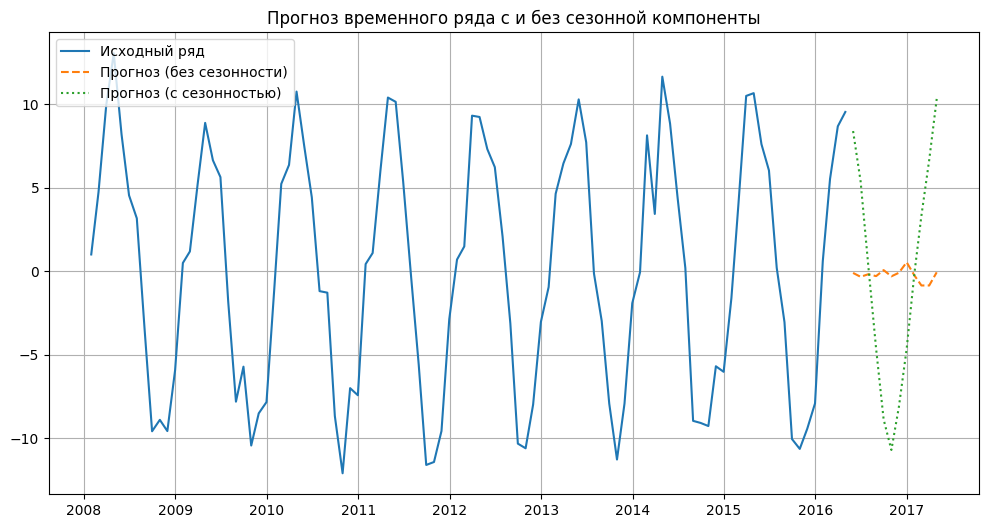

In [48]:
forecast = importr('forecast')
adjusted_ts = stats.ts(adjusted, frequency=12, start=ro.IntVector([2000, 1]))

# 3. Прогнозируем скорректированный ряд с auto_arima
fit = forecast.auto_arima(adjusted_ts)
fc = ro.r['forecast'](fit, h=12)

pred_adjusted = np.array(fc.rx2('mean'))

# 4. Извлекаем сезонную компоненту из X-13
seasonal_component = base.as_numeric(ro.r['seasonal'](res))
# Конвертируем в ts
seasonal_ts = stats.ts(seasonal_component, frequency=12, start=ro.IntVector([2000, 1]))

# Последние 12 значений сезонной компоненты для добавления к прогнозу (циклично)
seasonal_cycle = np.array(seasonal_component[-12:])

# 5. Формируем прогноз с возвращённой сезонностью
pred_with_season = pred_adjusted + seasonal_cycle

seasonal_series.index = pd.date_range(start='2008-01-01', periods=len(seasonal_series), freq='M')
# Создаём даты для прогноза
forecast_index = pd.date_range(
    start=seasonal_series.index[-1] + pd.offsets.MonthBegin(1),
    periods=12,
    freq='M'
)

# Построим график
plt.figure(figsize=(12,6))
plt.plot(seasonal_series.index, seasonal_series.values, label="Исходный ряд")
plt.plot(forecast_index, pred_adjusted, label="Прогноз (без сезонности)", linestyle="--")
plt.plot(forecast_index, pred_with_season, label="Прогноз (с сезонностью)", linestyle=":")
plt.legend()
plt.grid(True)
plt.title("Прогноз временного ряда с и без сезонной компоненты")
plt.show()

## Holt
Модель основанная на двойном экспоненциальном сглаживании
Что это: Экспоненциальное сглаживание с учетом тренда. Расширение простого экспоненциального сглаживания, которое учитывает не только уровень ряда, но и его тренд.

Основные параметры: уровень (уровень ряда), тренд (скорость изменения).

Формулы:

Уровень: 
𝑙𝑡=𝛼𝑦𝑡+(1−𝛼)(𝑙𝑡−1+𝑏𝑡−1)
Тренд: 
𝑏𝑡=𝛽(𝑙𝑡−𝑙𝑡−1)+(1−𝛽)𝑏𝑡−1
Прогноз: 
𝑦^𝑡+ℎ=𝑙𝑡+ℎ𝑏𝑡

где 

α,β — параметры сглаживания, 
h — горизонт прогноза.

Когда использовать: Когда ряд содержит тренд, но сезонность отсутствует.
Особенность: Простая, быстро обучается, хорошо работает на трендовых данных без сезонности.



In [10]:
holt_model = ExponentialSmoothing(time_series, trend="add", seasonal=None)
fitted_holt = holt_model.fit()
forecast_holt = fitted_holt.fittedvalues

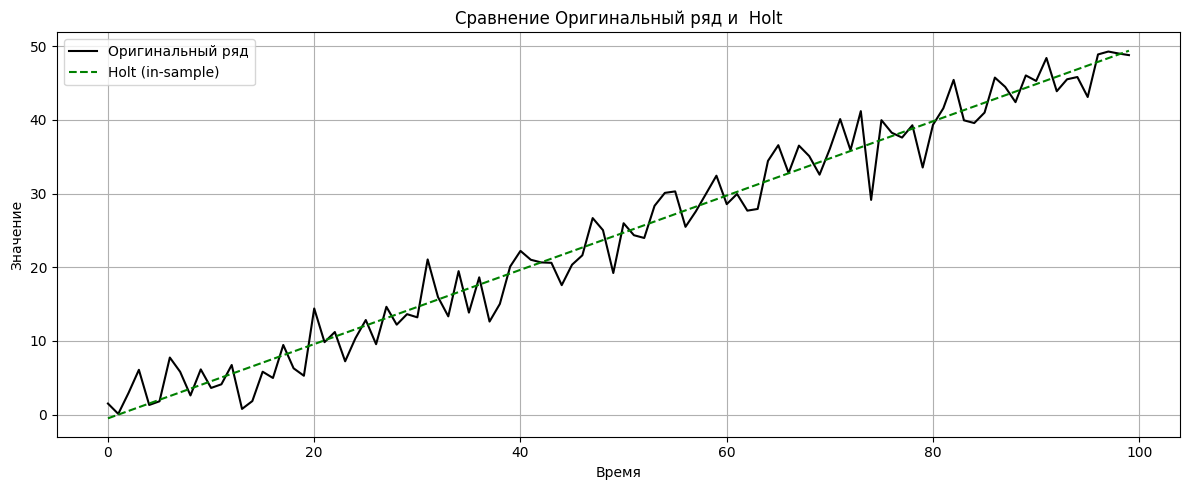

In [47]:
# Построение сравнения
plt.figure(figsize=(12, 5))
plt.plot(time_series, label="Оригинальный ряд", color="black")
plt.plot(forecast_holt, label="Holt (in-sample)", linestyle="--", color="green")
plt.title("Сравнение Оригинальный ряд и  Holt")
plt.xlabel("Время")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Holt-Winters (Triple Exponential Smoothing)
Модель основанная на тройном экспоненциальном сглаживании
Модель расширяет экспоненциальное сглаживание с двумя дополнительными компонентами:
- Уровень (Level) — текущий уровень ряда
- Тренд (Trend) — направление и скорость изменения
- Сезонность (Seasonality) — периодические колебания

Существует два варианта сезонности:
- Аддитивная — сезонные колебания примерно одинаковой амплитуды
- Мультипликативная — сезонные колебания зависят от уровня ряда (увеличиваются вместе с трендом)
- 
Формулы Holt-Winters (аддитивная сезонность)
Обозначения:
- α — параметр сглаживания уровня
- β — параметр сглаживания тренда
- γ — параметр сглаживания сезонности
- 𝐿𝑡  — уровень в момент 𝑡
- t𝑇 — тренд в момент 𝑡
- 𝑆𝑡 — сезонность в момент 𝑡
- 𝑦𝑡  — наблюдение в момент 𝑡
- m — длина сезона

Обновление компонентов:


\begin{cases}
L_t = \alpha (y_t - S_{t-m}) + (1 - \alpha)(L_{t-1} + T_{t-1}) \\
T_t = \beta (L_t - L_{t-1}) + (1 - \beta) T_{t-1} \\
S_t = \gamma (y_t - L_t) + (1 - \gamma) S_{t-m}
\end{cases}


Прогноз на \( h \) шагов вперед:


\[
\hat{y}_{t+h} = L_t + h T_t + S_{t-m+h \bmod m}
\]


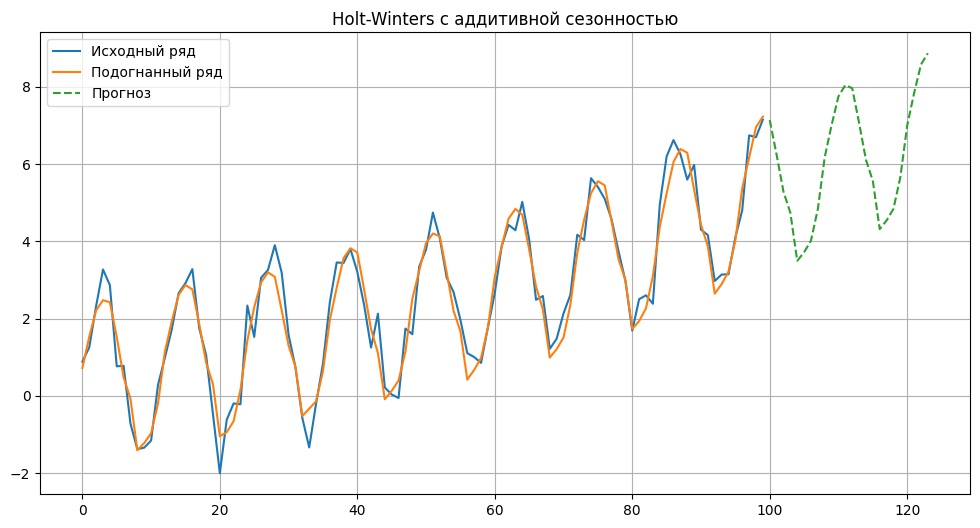

In [109]:
np.random.seed(0)
n = 100
t = np.arange(n)
season_length = 12

trend = 0.05 * t
seasonality = 2 * np.sin(2 * np.pi * t / season_length)
noise = np.random.normal(0, 0.5, n)

series = trend + seasonality + noise
ts = pd.Series(series)

# Применяем Holt-Winters с аддитивной сезонностью
model = ExponentialSmoothing(ts, trend='add', seasonal='add', seasonal_periods=season_length)
hw_fit = model.fit()

# Прогнозируем следующие 24 периода
forecast = hw_fit.forecast(24)

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(ts, label='Исходный ряд')
plt.plot(hw_fit.fittedvalues, label='Подогнанный ряд')
plt.plot(forecast, label='Прогноз', linestyle='--')
plt.legend()
plt.title('Holt-Winters с аддитивной сезонностью')
plt.grid()
plt.show()

## LSTM (Long Short-Term Memory)

LSTM (Long Short-Term Memory) — это вид рекуррентной нейронной сети, который умеет автоматически захватывать сложные временные зависимости в данных, включая:
- тренды,
- сезонности,
- шумы,
- нелинейные паттерны.

Основа модели:  слой self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
Вот ключевые особенности слоя:
- Последовательная обработка: LSTM обрабатывает входные данные как последовательность (временной ряд, текст, аудио и т.п.), а не как независимые примеры.
- Память и состояния: LSTM имеет внутреннее состояние (hidden state и cell state), которые позволяют ему «запоминать» информацию из предыдущих шагов последовательности. Это помогает эффективно работать с зависимостями во времени.

Параметры слоя:
- input_size — размер входного вектора на каждый временной шаг (например, 1 для одномерного ряда).
- hidden_size — размер скрытого состояния (сколько признаков будет у внутреннего состояния LSTM).
- num_layers — число LSTM-слоев (глубина рекуррентной сети).
- batch_first=True — формат входных данных [batch, seq_len, features] вместо [seq_len, batch, features], удобнее для большинства задач.

В отличие от классического dense-слоя, LSTM:
- Обрабатывает данные во временном порядке, поддерживая контекст.
- Может запоминать длинные зависимости и бороться с проблемой затухающего градиента (за счёт специальных механизмов гейтов).
- Используется именно для последовательных и временных данных.


Основная идея:
LSTM имеет ячейку памяти (cell state) и набор гейтов, которые контролируют, какую информацию сохранить, обновить или забыть. Это помогает "запоминать" важное на протяжении длительного времени.

Компоненты LSTM на каждом временном шаге 
Где:
σ — сигмоида
tanh — гиперболический тангенс
W_* — обучаемые весовые матрицы
b_* — обучаемые смещения
h_{t-1} — скрытое состояние предыдущего шага
x_t — вход текущего шага
c_t — состояние ячейки в момент t

Гейты:

- Forget Gate (Забывающий гейт):
f_t = σ(W_f · [h_{t-1}, x_t] + b_f)
Решает, какую информацию из памяти 𝑐𝑡−1  нужно забыть.
Значения 
𝑓𝑡 лежат между 0 и 1 (через сигмоид), где 0 — полностью забыть, 1 — сохранить.

- Input Gate (Входной гейт):
i_t = σ(W_i · [h_{t-1}, x_t] + b_i)
Решает, какую новую информацию добавить в память.

Candidate Cell State (Новый кандидат памяти):
ĉ_t = tanh(W_c · [h_{t-1}, x_t] + b_c)
Предлагает новую информацию, которую можно добавить.

Обновление состояния ячейки:
c_t = f_t * c_{t-1} + i_t * ĉ_t

Старая память  масштабируется забывающим гейтом 
Новая информация масштабируется входным гейтом 
Сложение дает обновленное состояние памяти.

Output Gate (Выходной гейт):
o_t = σ(W_o · [h_{t-1}, x_t] + b_o)
Решает, какую часть памяти показать на выходе.

Обновленное скрытое состояние:
h_t = o_t * tanh(c_t)
Это то, что передается дальше или используется в качестве вывода.

Почему это лучше классической RNN?
Классическая RNN просто обновляет состояние:
Она не имеет отдельной памяти и механизмов, чтобы запомнить, что важно, а что — забыть.

Это приводит к тому, что при длинных последовательностях градиенты либо «затухают», либо «взрываются», и обучение становится нестабильным.

LSTM благодаря гейтам может избирательно запоминать и забывать информацию, что позволяет ему работать с очень длинными временными зависимостями.


Epoch 10/100, Loss: 0.073997
Epoch 20/100, Loss: 0.069319
Epoch 30/100, Loss: 0.065516
Epoch 40/100, Loss: 0.064065
Epoch 50/100, Loss: 0.064206
Epoch 60/100, Loss: 0.063999
Epoch 70/100, Loss: 0.063928
Epoch 80/100, Loss: 0.063882
Epoch 90/100, Loss: 0.063832
Epoch 100/100, Loss: 0.063773


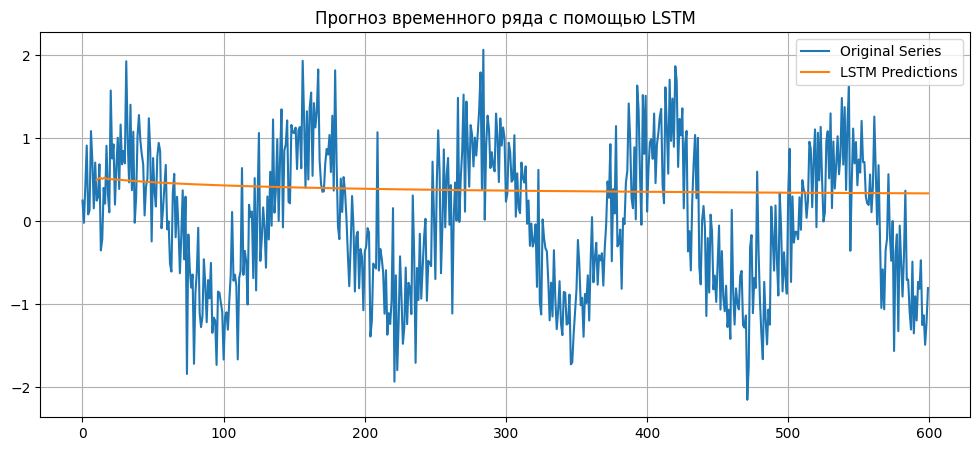

In [107]:
# 1. Генерация синтетического ряда 
np.random.seed(42)
n = 600
time = np.arange(n)
series = np.sin(0.05 * time) + 0.5 * np.random.randn(n)  # синус + шум

# 2. Нормализация ряда
scaler = MinMaxScaler(feature_range=(-1, 1))
series_norm = scaler.fit_transform(series.reshape(-1,1)).flatten()

# 3. Подготовка данных: формируем пары (X, y) с окном size=10
def create_sequences(data, seq_length=10):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
X, y = create_sequences(series_norm, seq_length)

# Конвертация в тензоры для PyTorch
X_t = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # (batch, seq_len, input_size=1)
y_t = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)  # (batch, output_size=1)

# 4. Определение модели LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # берем выход последнего шага
        out = self.linear(out)
        return out

model = LSTMModel()

# 5. Настройка оптимизатора и функции ошибки
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 6. Обучение модели
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_t)
    loss = criterion(output, y_t)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}')

# 7. Прогноз на весь ряд (рекурсивно)
model.eval()
predictions = []
input_seq = X_t[0].unsqueeze(0)  # берем первый пример (batch=1)
for _ in range(len(series_norm) - seq_length):
    with torch.no_grad():
        pred = model(input_seq)  # pred.shape = [batch, output_size] = [1,1]
        predictions.append(pred.item())
        pred = pred.unsqueeze(1)  # теперь shape [1,1,1]
        new_seq = torch.cat((input_seq[:,1:,:], pred), dim=1)
        input_seq = new_seq

# 8. Обратное преобразование масштаба
pred_inv = scaler.inverse_transform(np.array(predictions).reshape(-1,1)).flatten()

# 9. Визуализация
plt.figure(figsize=(12,5))
plt.plot(time, series, label='Original Series')
plt.plot(time[seq_length:], pred_inv, label='LSTM Predictions')
plt.legend()
plt.title('Прогноз временного ряда с помощью LSTM')
plt.grid()
plt.show()

## Сравнение коробчных моделей предектирования

1. Если используем классические "коробочные" методы (ARIMA, Holt, LSTM):
- Они обычно сами "обрабатывают" тренды и сезонность внутри своих моделей (например, ARIMA через дифференцирование, Holt-Winters через компоненты, LSTM — через обучение).
- Если мы уже отдельно почистили ряд (убрали тренд, сезонность, шумы), то применяя эти методы:
- можно применять на очищенных данных для повышения качества прогноза, ведь модельу проще учиться на более «ровном» ряде.
- Иногда имеет смысл убрать сезонность/тренд до модели, чтобы сосредоточиться только на остаточных компонентах (noise + irregular).
- Но тогда нужно помнить, что при прогнозировании придётся добавлять обратно сезонность и тренд, чтобы получить прогноз в исходном масштабе.

2. Если используем машинное обучение (XGBoost, RandomForest, Gradient Boosting, нейросети вне LSTM):
- Здесь часто применяют отдельное предварительное разложение временного ряда на компоненты (тренд, сезонность, остатки).
- Затем используют именно эти компоненты или остатки как фичи для обучения моделей ML.
- ML-модели в таком случае обычно лучше работают на "очищенных" данных, потому что сложные сезонные и трендовые паттерны трудно "поймать" напрямую.
- ML-модели часто дают более гибкие, нелинейные прогнозы, умеют учитывать сложные зависимости.



| Особенность          | ARIMA                                                          | X-13ARIMA                                                     | Holt                                    | Holt-Winters (HW)                                              | LSTM                                                                  |
| -------------------- | -------------------------------------------------------------- | ------------------------------------------------------------- | --------------------------------------- | -------------------------------------------------------------- | --------------------------------------------------------------------- |
| Модель               | Статистическая, основана на авторегрессии и скользящих средних | Расширенная ARIMA с учётом сезонности, календарных эффектов   | Экспоненциальное сглаживание с трендом  | Экспоненциальное сглаживание с трендом и сезонностью           | Нейросетевая, обучается на данных                                     |
| Предположения        | Линейность, стационарность (частично)                          | То же, плюс более гибкая обработка сезонности и спецэффектов  | Линейный тренд, без сезонности          | Линейный тренд + сезонность (аддитивная или мультипликативная) | Нет жёстких предположений о стационарности или линейности             |
| Обработка сезонности | Через SARIMA или доп. компоненты                               | Автоматическое выделение сезонных компонент                   | Не учитывает сезонность                 | Учитывает сезонность, адаптируется к разным типам сезонности   | Учится выделять сезонность сама                                       |
| Подходит для         | Простых/умеренных по сложности рядов                           | Больших, сложных рядов с сезонностью и календарными эффектами | Рядов с линейным трендом без сезонности | Рядов с трендом и ярко выраженной сезонностью                  | Сложных и нелинейных временных рядов                                  |
| Требования к данным  | Нужна очистка, предобработка                                   | Аналогично ARIMA, лучше с объемными данными                   | Требуется относительно гладкий тренд    | Требуется сезонность и тренд, без резких выбросов              | Может работать с «сырыми» данными, но нуждается в обучении на объёмах |


| Подход                                  | Особенности                                                                                                                  |
| --------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------- |
| Классические методы (ARIMA, Holt, LSTM) | Встроенная работа с трендом/сезонностью, удобны для «чистых» рядов, требуют меньше фич, сами прогнозируют.                   |
| Машинное обучение (XGBoost, др.)        | Требуют предварительной обработки и выделения признаков, работают лучше на "очищенных" данных, дают гибкость и нелинейность. |


Для простейших и умеренно сложных рядов — классические методы вполне подходят и часто удобнее.
Для сложных, сильно нерегулярных или многомерных рядов часто ML-подходы (XGBoost, LightGBM, нейросети) дают лучшие результаты, но требуют предобработки и больше инженерной работы.
